# Appendix
Old items that are mostly of historical interest. As with the main Models.ipynb, after importing we'll make some quick modifications to the data (so the items below still run if needed).

In [49]:
# Basic imports and setup
# See below for model-specific imports
from __future__ import print_function
from joblib import dump, load
import matplotlib.pyplot as plt
from multiprocessing import Pool
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import seaborn as sns
import tempfile
import time

# Model-specific imports
from dask_ml.preprocessing import Categorizer, DummyEncoder

from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier, RUSBoostClassifier
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.under_sampling import TomekLinks

import lime
import lime.lime_tabular

from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier, \
    RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer, Normalizer
from sklearn.svm import SVC

from statsmodels.discrete.discrete_model import Logit, LogitResults

%matplotlib inline

# Temporarily turn off warnings if they get to be too much
#import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv('data/all_years.csv', index_col=0)

# Group the columns into 1) raw input variables, 2) id variables of various things, 3) American Community Survey (census)
# variables, 4) NYC government-calculated variables, and 5) output variables.
#
# The ACS and NYC variables are generally calculated from the raw input variables - my initial expectation is that
# the raw input variables can be thought of as independent variables, and that the ACS and NYC variables are not
# independent even though they are not output variables.

raw_inp_vars = ['AGEP', 'Boro', 'CIT', 'DIS', 'ENG', 'ESR', 'Ethnicity', 'HHT', 'HIUnit_Head', 'HousingStatus', 'JWTR', 'LANX', 'MAR', 'MSP','NP', 'Off_Threshold', 'PreTaxIncome_PU', 'REL', 'SCH', 'SCHG', 'SCHL', 'SEX', 'TEN', 'WKHP', 'WKW', 'Year']
id_vars = ['HIUnit_ID', 'Povunit_ID', 'PWGTP', 'SERIALNO', 'SNAPUnit_ID', 'SPORDER', 'TaxUnit_ID', 'WGTP']
acs_vars = ['AgeCateg', 'INTP_adj', 'OI_adj', 'MRGP_adj', 'PA_adj', 'RETP_adj', 'RNTP_adj', 'SEMP_adj', 'SSIP_adj', 'SSP_adj',  'WAGP_adj']
nyc_vars = ['CitizenStatus',  'EducAttain', 'FTPTWork', 'FamType_PU', 'NYCgov_Childcare', 'NYCgov_Commuting', 'NYCgov_EITC', 'NYCgov_FICAtax', 'NYCgov_HEAP', 'NYCgov_Housing', 'NYCgov_Income', 'NYCgov_IncomeTax', 'NYCgov_MOOP', 'NYCgov_MedPremiums', 'NYCgov_MedSpending', 'NYCgov_Nutrition', 'NYCgov_REL', 'NYCgov_SFN', 'NYCgov_SFR', 'NYCgov_SNAP', 'NYCgov_SchoolBreakfast', 'NYCgov_SchoolLunch', 'NYCgov_Threshold', 'NYCgov_WIC', 'Povunit_Rel', 'SNAPUnit_Rel',  'TaxUnit_FILER', 'TaxUnit_FILESTAT', 'TaxUnit_FILETYPE', 'TaxUnit_Rel', 'TotalWorkHrs_PU']
output_vars = ['NYCgov_PovGap', 'NYCgov_Pov_Stat', 'NYCgov_PovGapIndex', 'Off_Pov_Stat']
all_columns = raw_inp_vars + id_vars + acs_vars + nyc_vars + output_vars

In [3]:
# Create codes for the raw input variables that are number-coded, so we can create charts that make sense
raw_codes = {'Boro': {1: 'Bronx', 2: 'Brooklyn', 3: 'Manhattan', 4: 'Queens', 5: 'Staten Island'},
         'CIT': {1: 'Birth', 2: 'Territories', 3: 'US Parents', 4: 'Naturalized', 5: 'No'},
         'DIS': {0: 'NA', 1: 'Yes', 2: 'No'},
         'ENG': {0: '<5', 1: 'Very Well', 2: 'Well', 3: 'Not well', 4: 'Not at all', 5: 'Only Eng'},
         'ESR': {0: '<16', 1: 'EMP', 2:'EMP/NAW', 3: 'UNEMP', 4: 'AF', 5: 'AF/NAW', 6:'NILF'},
         'Ethnicity': {1: 'White', 2: 'Black', 3: 'Asian', 4: 'Hispanic', 5: 'Other'},
         'HHT': {0: 'NA', 1: 'MAR', 2: 'MNW', 3: 'WNM', 4: 'Malone', 5: 'MNAlone', 6: 'Walone', 7: 'WNalone'},
         'HIUnit_Head': {0: 'Not Head', 1: 'Head', 2: 'Not Head'},
         'HousingStatus': {0: 'NA', 1: 'Public', 2: 'Mitchell', 3: 'Subsidy', 4: 'Regulated', 5: 'OtherReg', 6: 'MarketRate', 7: 'NoCash', 8: 'OwnF&C', 9: 'Own-Mortgage'},
         'JWTR': {0: 'NA', 1: 'Car', 2: 'Bus', 3:'Streetcar', 4:'Subway', 5:'RR', 6:'Ferry', 7:'Taxi', 8:'Motorcycle', 9:'Bike', 10:'Walk', 11:'Home', 12: 'Other'},
         'LANX': {0: 'NA', 1: 'Yes', 2: 'Only Eng'},
         'MAR': {1: 'Married', 2:'Widowed', 3:'Divorced', 4:'Separated', 5:'Never Married'},
         'MSP': {0: 'NA', 1: 'Yes', 2:'Spouse absent', 3:'Widowed', 4:'Divorced', 5:'Separated', 6:'Never Married'},
         'REL': {0: 'Self', 1:'Spouse', 2:'Child', 3:'Adopted', 4:'Stepchild', 5:'Sibling', 6:'Parent', 7:'Grandchild', 8:'Parent-in-law', 9:'Child-in-law', 10:'Other', 11:'Boarder', 12:'Roommate', 13:'Partner', 14:'Foster', 15:'OtherNR', 16:'Inst', 17:'NonInst'},
         'SCH': {0: 'NA', 1: 'NoPast3Mos', 2:'Public', 3:'Private/Home'},
         'SCHG': {0: 'NA', 1:'Preschool', 2:'Kindergarten', 3:'1', 4:'2', 5:'3', 6:'4', 7:'5', 8:'6', 9:'7', 10:'8', 11:'9', 12:'10', 13:'11', 14:'12', 15:'College', 16:'Grad school'},
         'SCHL': {0: 'NA', 1:'None', 2:'Preschool', 3:'Kindergarten', 4:'1', 5:'2', 6:'3', 7:'4', 8:'5', 9:'6', 10:'7', 11:'8', 12:'9', 13:'10', 14:'11', 15:'12-NoDip', 16:'Diploma', 17:'GED', 18:'<1yrCollege', 19:'CollNoDegree', 20:'Associates', 21:'Bachelors', 22:'Masters', 23:'Professional', 24:'Doctorate'},
         'SEX': {1:'Male', 2:'Female'},
         'TEN': {0: 'NA', 1:'Mortage', 2:'Free&Clear', 3:'Rent', 4:'OccButNoRent'},
         'WKW': {0:'NA', 1:'50-52', 2:'48-49', 3:'40-47', 4:'27-39', 5:'14-26', 6:'<13'},
        }

# Create codes for the nyc variables that are number-coded, so we can create charts that make sense
nyc_codes = {
    'CitizenStatus': {1: 'Birth', 2: 'Naturalized', 3: 'No'},
    'EducAttain': {0: 'NA', 1:'<HS', 2:'HS', 3:'SomeCollege', 4:'Bachelors+'},
    'FTPTWork': {1:'FTYR', 2:'<FTYR', 3:'None'},
    'FamType_PU': {1:'Family', 2:'Couple', 3:'M+kid', 4:'W+kid', 5:'Mnokid', 6:'Wnokid', 7:'Unrelated', 8:'UnrelAlone'},
    'NYCgov_REL': {0:'Self', 1:'Spouse', 2:'Child', 3:'Sibling', 4:'Parent', 5:'Grandkid', 6:'Inlaw', 7:'OtherRel', 8:'Boarder', 9:'Roommate', 10:'Partner', 11:'FosterKid', 12:'OtherNonRel'},
    'NYCgov_SFR': {0: 'NA', 1:'NoKids', 2:'Kids', 3:'OneParent', 4:'Kid', 5:'Kid-Monly', 6:'Kid-Wonly'},
    'Povunit_Rel': {1:'Head', 2:'Spouse/Ptnr', 3:'Child', 4:'Other'},
    'SNAPUnit_Rel': {1:'Head', 2:'Spouse/Ptnr', 3:'Child', 4:'Other'},
    'TaxUnit_FILER': {1:'Filer', 0:'Non-Filer'},
    'TaxUnit_FILESTAT': {0: 'NA', 1:'Joint', 2:'HH', 3:'MFS', 4:'Single'},
    'TaxUnit_FILETYPE': {0: 'NA', 1: 'Normal', 2:'Dependent', 3:'BelowThresh'},
    'TaxUnit_Rel': {1:'Head', 2:'Spouse/Ptnr', 3:'Child', 4:'Other', 5:'EIC', 6:'Relative'},
    'TotalWorkHrs_PU': {1:'3500+', 2:'2340-3500', 3:'1750-2340', 4:'<1750', 5:'None'}
    }

In [4]:
# Key dataframes of interest
# All 2016 data
all_2016 = df[df.Year == 2016]

# Our data set contains two sets of weights: household weights and person weights.  
# We need to separate out each column by whether it should be weighted as a household variable or a person variable.
# Lists to create weighted columns, separated based on whether they are personal or household statistics.
personal_vars = ['AGEP', 'Boro', 'CIT', 'SCH', 'SCHG', 'SCHL', 'SEX', 'ESR', 'ENG', 'LANX', 'MSP', 'MAR', 'NYCgov_EITC', 'WKW', 'WKHP', 'DIS', 'JWTR', 'WAGP_adj', 'INTP_adj', 'SEMP_adj', 'SSP_adj', 'SSIP_adj', 'PA_adj', 'RETP_adj', 'OI_adj', 'TaxUnit_Rel', 'NYCgov_REL', 'NYCgov_SFR', 'SNAPUnit_Rel', 'TaxUnit_FILER', 'TaxUnit_FILESTAT', 'TaxUnit_FILETYPE', 'Ethnicity', 'EducAttain', 'CitizenStatus', 'AgeCateg', 'FTPTWork', 'PWGTP'] 
pu_vars = ['MRGP_adj', 'RNTP_adj', 'NP', 'TEN', 'HHT', 'FamType_PU', 'HousingStatus', 'TotalWorkHrs_PU', 'PreTaxIncome_PU', 'NYCgov_Income', 'NYCgov_Threshold', 'NYCgov_Pov_Stat',  'NYCgov_Housing', 'NYCgov_Childcare', 'NYCgov_Commuting', 'NYCgov_MOOP', 'NYCgov_MedSpending', 'NYCgov_MedPremiums', 'NYCgov_HEAP', 'NYCgov_WIC', 'NYCgov_SNAP', 'NYCgov_SchoolLunch', 'NYCgov_SchoolBreakfast', 'NYCgov_Nutrition', 'NYCgov_FICAtax', 'NYCgov_IncomeTax', 'Off_Threshold', 'Off_Pov_Stat', 'NYCgov_PovGap', 'NYCgov_PovGapIndex', 'WGTP']
other_vars = ['HIUnit_Head', 'HIUnit_ID', 'NYCgov_SFN', 'Povunit_ID', 'Povunit_Rel', 'REL', 'SERIALNO', 'SNAPUnit_ID', 'SPORDER', 'TaxUnit_ID', 'Year']

### Feature Engineering - Adding New Poverty-Unit Variables Based on Personal Variables
Here's where we're actually adding new variables based on old variables.

From the personal-level features, we'll create new household-level features (e.g. number of kids, mean salary among 
adults, count of people making more than $30k, count of adults working between 14-26 hours/week, minimum salary among
adults working more than 26 hours/week, etc.)

This is a wall of text, not much exciting narrative here.

(Note on programming style/choices: the first function 'add_pu_columns' below is a real function, although it has a
kludge in case one of the summary calculations fails. (That happens rarely, but it's still a code smell.)

The second function, however, is not really a 'real' function; it's heavily hand-coded and relies on custom choices of
various groupings.  It was put into a function solely to comply with the DRY principle - in particular, this function
will typically be run twice (once for the whole grouping, and possibly once for a model run without the 'financial' 
features).  By putting it into a function for DRY purposes, we at least avoid accidentally running different code when we 
mean to run the same code).

In [28]:
def add_pu_columns(df, groups, group_names, categories, category_names, column):
    """
    Adds columns to dataframe 'df' containing calculations by poverty-unit, restricted by categories, considering groups.
    Calculations include any(), all(), min(), max(), count(), sum(), mean(), and % in given category.
    Input: a dataframe with multi-index consisting of 'SERIALNO', 'Povunit_ID', and 'SPORDER'; a set of masks and list of
    names for the groups; a set of masks and a list of names for the categories; and the column of interest.
    Output: no return value.  Inserts a series of columns into the dataframe including min, max, count, sum, any, all,
    % of total, and mean - within households, focusing on the groups and categories of interest. 
    """
    
    for group, group_name in zip(groups, group_names):
        for category, category_name in zip(categories, category_names):
            stacked = df[column][group & category].stack().groupby(['SERIALNO', 'Povunit_ID'])
            anys = stacked.any()
            # would love to use .all() here, but it would always be True because we filtered out everyone else
            mins = stacked.min()
            maxes = stacked.max()
            counts = stacked.count()
            sums = stacked.sum()
            means = sums/counts
            # The divisor below only restricts by 'groups' - so the final calculation is within a household, within
            # the group of interest (e.g. adults), what % is in the category of interest (e.g. works 40 hrs/week)
            divisor_for_percents = df[column][group].stack().groupby(['SERIALNO', 'Povunit_ID']).count()
            try:
                percents = counts.div(divisor_for_percents, axis=0)
                alls = percents == 1
            except: # if the calculation failed, leave percents and alls as a column of zeros
                df_len = len(df.groupby(['SERIALNO', 'Povunit_ID']).sum())
                percents = np.zeros(df_len)
                alls = np.zeros(df_len)
            
            # loop through, put in the dataframe, and fill in NAs of appropriate type
            series_and_names = zip([anys, alls, mins, maxes, counts, sums, means, percents], 
                                  ['any', 'all', 'min', 'max', 'count', 'sum', 'mean', '%'])
            for series, series_name in series_and_names:
                column_title = series_name + '_' + group_name + '_' + category_name
                df[column_title] = series
                if series_name in ['any', 'all']:
                    df[column_title] = df[column_title].fillna(False)
                else:
                    df[column_title] = df[column_title].fillna(0)
                    
def engineer_features(df, include_financials=True):
    """Create features for the dataframe. This function is heavily custom and was solely created for DRY-ness.
    Input: a poverty dataframe and whether or not to include financial features.
    Output: returns a copy of the dataframe summarized by poverty-unit, with *only* the new features included. 
    Prints progess updates to the screen as it goes.
    """

    time_0 = time.time()

    # Create dataframe to house new features 
    dfc = df.copy() # read as 'X new features'

    # Count the original # of features - later we'll just slice out the new features
    # Keep in mind that 'SERIALNO' and 'Povunit_ID' will go into the index, so we need to subtract 2 columns
    features_to_mask = len(dfc.columns) - 2
    
    # This is the largest # of people in a household; when we group the columns below, for each existing feature we'll
    # create one column for each person in a household - so we'll need to know this number at the end when we want to 
    # mask our existing features
    max_ppl = dfc.SPORDER.max()

    # First, some categoricals have odd ordering; remap them
    fix_orders = {'ENG': {0:0, 4:1, 3:2, 2:3, 1:4, 5:5}, 'WKW': {0:0, 6:1, 5:2, 4:3, 3:4, 2:5, 1:6}, 
                  'TotalWorkHrs_PU': {5:0, 4:1, 3:2, 2:3, 1:4}}
    dfc['ENG'] = dfc['ENG'].map(fix_orders['ENG'])
    dfc['WKW'] = dfc['WKW'].map(fix_orders['WKW'])
    dfc['TotalWorkHrs_PU'] = dfc['TotalWorkHrs_PU'].map(fix_orders['TotalWorkHrs_PU'])

    # Add column for total personal income
    if include_financials:
        dfc['TINP'] = dfc.WAGP_adj + dfc.INTP_adj + dfc.SEMP_adj + dfc.SSP_adj + dfc.SSIP_adj + \
                        dfc.PA_adj + dfc.RETP_adj + dfc.OI_adj

    # Grouping by SERIALNO and Povunit_ID, put SPORDER (person # in household) at the top as multi-index columns
    dfc = dfc.set_index(['SERIALNO', 'Povunit_ID', 'SPORDER']).unstack('SPORDER').fillna(0)

    # Create masks for age groups to use in creating new features
    mask_adult = (dfc.AgeCateg == 2) | (dfc.AgeCateg == 3)
    mask_65_plus = dfc.AgeCateg == 3
    mask_18_64 = dfc.AgeCateg == 2
    mask_kid = dfc.AgeCateg == 1
    mask_any_age = dfc.AgeCateg != 0
    mask_any = mask_any_age

    # add columns with age only, no categories
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']
    add_pu_columns(dfc, groups, group_names, [mask_any_age], ['age'], 'AGEP')

    # add columns for CIT
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    mask_non_cit = dfc.CIT == 5
    mask_cit = (dfc.CIT != 5) & (dfc.CIT != 0)
    mask_naturalized = dfc.CIT == 4

    categories = [mask_non_cit, mask_cit, mask_naturalized, mask_any]
    category_names = ['non-cit', 'citizen', 'naturalized_cit', 'any_CIT']

    add_pu_columns(dfc, groups, group_names, categories, category_names, 'CIT')
    add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with CIT')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for SCHL
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    mask_college_degree = (dfc.SCHL >= 21)
    mask_HS_diploma = (dfc.SCHL >= 17)
    mask_no_diploma = (dfc.SCHL <= 16)

    categories = [mask_college_degree, mask_HS_diploma, mask_no_diploma, mask_HS_diploma & ~mask_college_degree, mask_any]
    category_names = ['college', 'HS', 'no_diploma', 'diploma_no_bachelors', 'any_SCHL']

    add_pu_columns(dfc, groups, group_names, categories, category_names, 'SCHL')
    add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with SCHL')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for SEX
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    mask_male = dfc.SEX == 1
    mask_female = dfc.SEX == 2

    categories = [mask_male, mask_female, mask_any]
    category_names = ['male', 'female', 'any_SEX']

    add_pu_columns(dfc, groups, group_names, categories, category_names, 'SEX')
    add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with SEX')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for English ability (ENG)
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    # Keep in mind we switched ENG above so that 0 is NA, 1 is not at all, 2 is not very well, ..., 5 is only English
    mask_no_english = dfc.ENG == 1
    mask_eng_nvw = dfc.ENG == 2
    mask_sep_well = dfc.ENG == 3
    mask_eng_vw = dfc.ENG == 4
    mask_only_eng = dfc.ENG == 5

    categories = [mask_no_english, mask_eng_nvw, mask_sep_well, mask_eng_vw, mask_only_eng, mask_any]
    category_names = ['ENG_no', 'ENG_nvw', 'ENG_well', 'ENG_vw', 'ENG_only', 'ENG_any']

    add_pu_columns(dfc, groups, group_names, categories, category_names, 'ENG')
    add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with ENG')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for marital status (MSP)
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    mask_married = (dfc.MSP == 1) | (dfc.MSP == 2)
    mask_widowed = dfc.MSP == 3
    mask_sep_div = (dfc.MSP == 4) | (dfc.MSP == 5)
    mask_not_married = dfc.MSP == 6

    categories = [mask_married, mask_widowed, mask_sep_div, mask_not_married, mask_any]
    category_names = ['married', 'widowed', 'sep/divorced', 'not_married', 'any_MSP']

    add_pu_columns(dfc, groups, group_names, categories, category_names, 'MSP')
    add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with MSP')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for weeks worked (WKW) -- this is *weeks* worked last year, not *hours per week* (that's WKHP)
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    # Keep in mind we switched WKW above so that 0 is none, 1 is <14 weeks, 2 is 14-26 weeks, etc.
    mask_0_WKW = dfc.WKW == 0
    mask_u14_WKW = dfc.WKW == 1
    mask_14_26_WKW = dfc.WKW == 2
    mask_27_39_WKW = dfc.WKW == 3
    mask_40_47_WKW = dfc.WKW == 4
    mask_48_49_WKW = dfc.WKW == 5
    mask_50_52_WKW = dfc.WKW == 6

    categories = [mask_0_WKW, mask_u14_WKW, mask_14_26_WKW, mask_27_39_WKW, mask_40_47_WKW, mask_48_49_WKW, mask_50_52_WKW, 
                 (mask_40_47_WKW | mask_48_49_WKW | mask_50_52_WKW), ~mask_0_WKW, mask_any]
    category_names = ['no_work', '<14WKW', '14-26WKW', '27-39WKW', '40-47WKW', '48-49WKW', '50-52WKW', '>40WKW', 'nonzero_WKW',
                     'any_WKW']

    add_pu_columns(dfc, groups, group_names, categories, category_names, 'WKW')
    add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with WKW')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for usual hours worked per week last 12 months (WKHP)
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    mask_0_WKHP = dfc.WKHP == 0
    mask_u10_WKHP = dfc.WKHP < 10
    mask_u15_WKHP = dfc.WKHP < 15
    mask_u20_WKHP = dfc.WKHP < 20
    mask_u30_WKHP = dfc.WKHP < 30
    mask_u40_WKHP = dfc.WKHP < 40
    mask_u50_WKHP = dfc.WKHP < 50
    mask_50_plus_WKHP = dfc.WKHP >= 50
    mask_40_plus_WKHP = dfc.WKHP >= 40

    categories = [mask_0_WKHP, mask_u10_WKHP, mask_u15_WKHP, mask_u20_WKHP, mask_u30_WKHP, mask_u40_WKHP, 
                  mask_u50_WKHP, mask_50_plus_WKHP, mask_40_plus_WKHP, mask_any]
    category_names = ['no_work_hrs', '<10_work_hrs', '<15_work_hrs', '<20_work_hrs', '<30_work_hrs', '<40_work_hrs', 
                      '<50_work_hrs', '50_plus_work_hrs', '40_plus_work_hrs', 'any_WKHP']

    add_pu_columns(dfc, groups, group_names, categories, category_names, 'WKHP')
    add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with WKHP')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for disability status (DIS)
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    mask_DIS = dfc.DIS == 1
    mask_not_DIS = dfc.DIS == 2

    categories = [mask_DIS, mask_not_DIS, mask_any]
    category_names = ['DIS', 'not_DIS', 'any_DIS']

    add_pu_columns(dfc, groups, group_names, categories, category_names, 'DIS')
    add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with DIS')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for number of people (NP)
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    mask_1_NP = dfc.NP == 1
    mask_2_NP = dfc.NP == 2
    mask_3_NP = dfc.NP == 3
    mask_4_NP = dfc.NP == 4
    mask_5_NP = dfc.NP == 5
    mask_p5_NP = dfc.NP > 5
    mask_p6_NP = dfc.NP > 6
    mask_p8_NP = dfc.NP > 8
    mask_p10_NP = dfc.NP > 10
    mask_p12_NP = dfc.NP > 12

    categories = [mask_1_NP, mask_2_NP, mask_3_NP, mask_4_NP, mask_5_NP, mask_p5_NP, mask_p6_NP, mask_p8_NP, mask_p10_NP, 
                  mask_p12_NP, mask_any]
    category_names = ['NP1', 'NP2', 'NP3', 'NP4', 'NP5', 'NP>5', 'NP>6', 'NP>8', 'NP>10', 'NP>12', 'anyNP']

    add_pu_columns(dfc, groups, group_names, categories, category_names, 'NP')
    add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with NP')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for means of transportation to work (JWTR)
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    categories = [mask_any]
    category_names = ['work_trans']

    add_pu_columns(dfc, groups, group_names, categories, category_names, 'JWTR')
    # Since only doing this to get means/avgs on JWTR, no need to add the 'AGEP' version here
    #add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with JWTR')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for wages (WAGP_adj)
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    mask_0_WAG = dfc.WAGP_adj == 0
    mask_u10_WAG = dfc.WAGP_adj < 10000
    mask_u15_WAG = dfc.WAGP_adj < 15000
    mask_u20_WAG = dfc.WAGP_adj < 20000
    mask_u25_WAG = dfc.WAGP_adj < 25000
    mask_u30_WAG = dfc.WAGP_adj < 30000
    mask_u35_WAG = dfc.WAGP_adj < 35000
    mask_u40_WAG = dfc.WAGP_adj < 40000
    mask_u45_WAG = dfc.WAGP_adj < 45000
    mask_u50_WAG = dfc.WAGP_adj < 50000
    mask_u60_WAG = dfc.WAGP_adj < 60000
    mask_u70_WAG = dfc.WAGP_adj < 70000
    mask_u80_WAG = dfc.WAGP_adj < 80000

    categories = [mask_0_WAG, mask_u10_WAG, mask_u15_WAG, mask_u20_WAG, mask_u25_WAG, mask_u30_WAG,  mask_u35_WAG, 
                  mask_u40_WAG, mask_u45_WAG, mask_u50_WAG, mask_u60_WAG, mask_u70_WAG, mask_u80_WAG, mask_any]
    category_names = ['WAG0', 'WAG<10', 'WAG<15', 'WAG<20', 'WAG<25', 'WAG<30', 'WAG<35', 
                      'WAG<40', 'WAG<45', 'WAG<50', 'WAG<60', 'WAG<70', 'WAG<80', 'WAG_any']

    if include_financials:
        add_pu_columns(dfc, groups, group_names, categories, category_names, 'WAGP_adj')
        add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with WAGP')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for interest income (INTP_adj)
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    # cutoffs taken from quartiles of nonzero values
    mask_0_INT = dfc.INTP_adj <= 0
    mask_INT_1q = (dfc.INTP_adj > 0) & (dfc.INTP_adj <= 400)
    mask_INT_2q = (dfc.INTP_adj > 400) & (dfc.INTP_adj <= 4000)
    mask_INT_3q = (dfc.INTP_adj > 4000) & (dfc.INTP_adj <= 15000)
    mask_INT_4q = dfc.INTP_adj > 15000

    categories = [mask_0_INT, mask_INT_1q, mask_INT_2q, mask_INT_3q, mask_INT_4q, mask_any]
    category_names = ['INT0', 'INT1q', 'INT2q', 'INT3q', 'INT4q', 'INT_any']

    if include_financials:
        add_pu_columns(dfc, groups, group_names, categories, category_names, 'INTP_adj')
        add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with INTP')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for self-employment income (SEMP_adj)
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    # cutoffs taken from quartiles of nonzero values
    mask_0_SEMP = dfc.SEMP_adj <= 0
    mask_SEMP_1q = (dfc.SEMP_adj > 0) & (dfc.SEMP_adj <= 5000)
    mask_SEMP_2q = (dfc.SEMP_adj > 5000) & (dfc.SEMP_adj <= 15000)
    mask_SEMP_3q = (dfc.SEMP_adj > 15000) & (dfc.SEMP_adj <= 35000)
    mask_SEMP_4q = dfc.SEMP_adj > 35000

    categories = [mask_0_SEMP, mask_SEMP_1q, mask_SEMP_2q, mask_SEMP_3q, mask_SEMP_4q, mask_any]
    category_names = ['SEMP0', 'SEMP1q', 'SEMP2q', 'SEMP3q', 'SEMP4q', 'SEMP_any']

    if include_financials:
        add_pu_columns(dfc, groups, group_names, categories, category_names, 'SEMP_adj')
        add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with SEMP')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for social security income (SSP_adj)
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    # cutoffs taken from quartiles of nonzero values
    # min 10, 25% 8000, 50% 12,000, 75% 18,000, max 50,000
    mask_0_SSP = dfc.SSP_adj <= 0
    mask_SSP_1q = (dfc.SSP_adj > 0) & (dfc.SSP_adj <= 8000)
    mask_SSP_2q = (dfc.SSP_adj > 8000) & (dfc.SSP_adj <= 12000)
    mask_SSP_3q = (dfc.SSP_adj > 12000) & (dfc.SSP_adj <= 18000)
    mask_SSP_4q = dfc.SSP_adj > 18000

    categories = [mask_0_SSP, mask_SSP_1q, mask_SSP_2q, mask_SSP_3q, mask_SSP_4q, mask_any]
    category_names = ['SSP0', 'SSP1q', 'SSP2q', 'SSP3q', 'SSP4q', 'SSP_any']

    if include_financials:
        add_pu_columns(dfc, groups, group_names, categories, category_names, 'SSP_adj')
        add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with SSP')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for supplemental security income (SSIP_adj)
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    # cutoffs taken from quartiles of nonzero values
    mask_0_SSIP = dfc.SSIP_adj <= 0 
    mask_SSIP_1q = (dfc.SSIP_adj > 0) & (dfc.SSIP_adj <= 5500) 
    mask_SSIP_2q = (dfc.SSIP_adj > 5500) & (dfc.SSIP_adj <= 8000) 
    mask_SSIP_3q = (dfc.SSIP_adj > 8000)

    categories = [mask_0_SSIP, mask_SSIP_1q, mask_SSIP_2q, mask_SSIP_3q, mask_any]
    category_names = ['SSIP0', 'SSIP1q', 'SSIP2q', 'SSIP3q', 'SSIP_any']

    if include_financials:
        add_pu_columns(dfc, groups, group_names, categories, category_names, 'SSIP_adj')
        add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with SSIP')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for public assistance income (PA_adj)
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    # cutoffs taken from quartiles of nonzero values
    mask_0_PA = dfc.PA_adj <= 0 
    mask_PA_1q = (dfc.PA_adj > 0) & (dfc.PA_adj <= 900) 
    mask_PA_2q = (dfc.PA_adj > 900)

    categories = [mask_0_PA, mask_PA_1q, mask_PA_2q, mask_any]
    category_names = ['PA0', 'PA1q', 'PA2q', 'PA_any']

    if include_financials:
        add_pu_columns(dfc, groups, group_names, categories, category_names, 'PA_adj')
        add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with PA')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for retirement income (RETP_adj)
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    # cutoffs taken from quartiles of nonzero values
    mask_RETP_1q = (dfc.RETP_adj > 0) & (dfc.RETP_adj <= 6000) 
    mask_RETP_2q = (dfc.RETP_adj > 6000) & (dfc.RETP_adj <= 13400) 
    mask_RETP_3q = (dfc.RETP_adj > 13400)

    categories = [mask_RETP_1q, mask_RETP_2q, mask_RETP_3q, mask_any]
    category_names = ['RETP1q', 'RETP2q', 'RETP3q', 'RETP_any']

    if include_financials:
        add_pu_columns(dfc, groups, group_names, categories, category_names, 'RETP_adj')
        add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with RETP')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for other income (OI_adj)
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    # cutoffs taken from quartiles of nonzero values
    mask_OI_1q = (dfc.OI_adj > 0) & (dfc.OI_adj <= 2000) 
    mask_OI_2q = (dfc.OI_adj > 2000) & (dfc.OI_adj <= 6000) 
    mask_OI_3q = (dfc.OI_adj > 6000)

    categories = [mask_OI_1q, mask_OI_2q, mask_OI_3q, mask_any]
    category_names = ['OI1q', 'OI2q', 'OI3q', 'OI_any']

    if include_financials:
        add_pu_columns(dfc, groups, group_names, categories, category_names, 'OI_adj')
        add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with OI')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for ethnicity
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    mask_white = dfc.Ethnicity == 1
    mask_black = dfc.Ethnicity == 2
    mask_asian = dfc.Ethnicity == 3
    mask_hisp = dfc.Ethnicity == 4
    mask_other = dfc.Ethnicity == 5

    categories = [mask_white, mask_black, mask_asian, mask_hisp, mask_other, mask_any]
    category_names = ['White', 'Black', 'Asian', 'Hisp', 'ETH_other', 'ETH_any']

    add_pu_columns(dfc, groups, group_names, categories, category_names, 'Ethnicity')
    add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with Ethnicity')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    if include_financials:
        # add columns for total personal income that we added above ('TINP')
        groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
        group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

        mask_0_TINP = dfc.TINP == 0
        mask_u10_TINP = dfc.TINP < 10000
        mask_u15_TINP = dfc.TINP < 15000
        mask_u20_TINP = dfc.TINP < 20000
        mask_u25_TINP = dfc.TINP < 25000
        mask_u30_TINP = dfc.TINP < 30000
        mask_u35_TINP = dfc.TINP < 35000
        mask_u40_TINP = dfc.TINP < 40000
        mask_u45_TINP = dfc.TINP < 45000
        mask_u50_TINP = dfc.TINP < 50000
        mask_u60_TINP = dfc.TINP < 60000
        mask_u70_TINP = dfc.TINP < 70000
        mask_u80_TINP = dfc.TINP < 80000

        categories = [mask_0_TINP, mask_u10_TINP, mask_u15_TINP, mask_u20_TINP, mask_u25_TINP, mask_u30_TINP,  mask_u35_TINP, 
                      mask_u40_TINP, mask_u45_TINP, mask_u50_TINP, mask_u60_TINP, mask_u70_TINP, mask_u80_TINP, mask_any]
        category_names = ['TINP0', 'TINP<10', 'TINP<15', 'TINP<20', 'TINP<25', 'TINP<30', 'TINP<35', 
                          'TINP<40', 'TINP<45', 'TINP<50', 'TINP<60', 'TINP<70', 'TINP<80', 'TINP_any']

        add_pu_columns(dfc, groups, group_names, categories, category_names, 'TINP')
        add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')

    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s')

    # Only return the new features that we engineered
    # The variables features_to_mask and max_ppl were created at the beginning of this function
    columns_to_mask = features_to_mask * max_ppl
    dfc = dfc.iloc[:, columns_to_mask:].copy()

    # We ended up with multi-level column headers - just keep the top level
    dfc.columns = dfc.columns.get_level_values(0)
    
    return(dfc)

#new_features = engineer_features(all_2016, include_financials=True)

#new_features.to_csv('data/EngineeredFeatures.csv')

done with CIT
took 64.48582053184509 s so far
done with SCHL
took 134.63068413734436 s so far
done with SEX
took 178.26997876167297 s so far
done with ENG
took 270.48538613319397 s so far
done with MSP
took 351.7556619644165 s so far
done with WKW
took 527.8056879043579 s so far
done with WKHP
took 721.531191110611 s so far
done with DIS
took 781.8973388671875 s so far
done with NP
took 1017.774843454361 s so far
done with JWTR
took 1037.0357296466827 s so far
done with WAGP
took 1372.6890752315521 s so far
done with INTP
took 1524.2630858421326 s so far
done with SEMP
took 1681.711932182312 s so far
done with SSP
took 1845.299048423767 s so far
done with SSIP
took 1985.9200677871704 s so far
done with PA
took 2101.1818034648895 s so far
done with RETP
took 2227.952205657959 s so far
done with OI
took 2348.0948402881622 s so far
done with Ethnicity
took 2535.209809064865 s so far
took 2999.9464485645294 s


### Feature Engineering - Putting Personal Features into Poverty Unit Rows
Our dataset contains people in poverty units (a household may contain one or more poverty units). The entire 
poverty unit either is or is not in poverty, but the data set as constructed has people in different rows (the data is
not tidy).

To tidy up, we'll move information on all the people in the poverty unit, into the row for that poverty unit.
Instead of having 3 people in a poverty unit represented by different rows, we'll put all three people in
the same row but different columns. The columns will be named 'AGEP_1', 'AGEP_2', 'AGEP_3', etc, with zero values in all
columns where person n does not exist.

There are three main columns of interest for this:
* SERIALNO is the serial number of each household.
* PovUnit_ID is the serial number of the poverty unit within the household (1-18). Each household can have more than one poverty unit (although the vast majority of households have only one poverty unit).
* SPORDER is the serial number of a person in the household (1-20). Note that the dataset only assigns serial numbers to
the people in the *household*, not the *poverty unit*.  This means that if for example a household has two poverty units,
the first with two people and the second with three people, the head of the second poverty unit will have SPORDER of 3,
not 1.  (One-based counting scheme) This is not a problem, but a particularity to be aware of when looking at dataset
rows for reference.

Also, there are some poverty-unit-level columns (e.g. 'TotalWorkHrs_PU', the number of work hours in the poverty unit)
that have the same value for each person in the poverty unit; we'll collect those separately.

So the strategy in the next section is to create dataframes X_pers and X_pu, containing respectively the personal and
poverty-unit features for each household.  We'll join those together, and then at the end add in all the new features we created in the last section.

In [5]:
def pers_and_pu_features(df, include_financials=True, target_column='NYCgov_Pov_Stat'):
    """Create personal and poverty-unit features for the dataframe. No new features are created, just 'tidy'-ing the data.
    Input: a poverty dataframe, whether or not to include financial features, and the target column.
    Output: returns a copy of the dataframe, tidy-ed up, with poverty units in rows and only features of interest in 
    columns. Prints progess updates to the screen as it goes.
    """

    dfc = df.copy()
    
    # First, some categoricals have odd ordering; remap them
    fix_orders = {'ENG': {0:0, 4:1, 3:2, 2:3, 1:4, 5:5}, 'WKW': {0:0, 6:1, 5:2, 4:3, 3:4, 2:5, 1:6}, 
                  'TotalWorkHrs_PU': {5:0, 4:1, 3:2, 2:3, 1:4}}
    dfc['ENG'] = dfc['ENG'].map(fix_orders['ENG'])
    dfc['WKW'] = dfc['WKW'].map(fix_orders['WKW'])
    dfc['TotalWorkHrs_PU'] = dfc['TotalWorkHrs_PU'].map(fix_orders['TotalWorkHrs_PU'])

    # Add column for total personal income
    if include_financials:
        dfc['TINP'] = dfc.WAGP_adj + dfc.INTP_adj + dfc.SEMP_adj + dfc.SSP_adj + dfc.SSIP_adj + dfc.PA_adj + dfc.RETP_adj + dfc.OI_adj

    categoricals = ['AGEP', 'CIT', 'SCHL', 'SEX', 'ENG', 'MSP', 'WKW', 'WKHP', 'DIS', 'JWTR', 'Ethnicity', 'Boro', 'NP', 
                    'TEN', 'HHT', 'HousingStatus', 'TotalWorkHrs_PU']

    # We'll create separate dataframes for personal and poverty-unit variables, then join them together
    personal_columns = ['AGEP', 'CIT', 'SCHL', 'SEX', 'ENG', 'MSP', 'WKW', 'WKHP', 'DIS', 'JWTR', 'Ethnicity', 'Boro']
    if include_financials:
        personal_columns += ['WAGP_adj', 'INTP_adj', 'SEMP_adj', 'SSP_adj', 'SSIP_adj', 'PA_adj', 'RETP_adj', 
                             'OI_adj', 'TINP']
    pu_columns = ['NP', 'TEN', 'HHT', 'MRGP_adj', 'RNTP_adj', 'HousingStatus', 'TotalWorkHrs_PU'] + [target_column]

    # Create a dataframe for the personal columns, including our 3 indicator variables
    df_pers = dfc.copy()
    df_pers_columns = ['SERIALNO', 'Povunit_ID', 'SPORDER'] + personal_columns
    df_pers = df_pers[df_pers_columns]

    # Grouping by SERIALNO and Povunit_ID, put SPORDER (person # in household) at the top as multi-index columns
    df_pers = df_pers.set_index(['SERIALNO', 'Povunit_ID', 'SPORDER']).unstack('SPORDER').fillna(0)

    # Turn the multi-index columns into a single indexed column: 'AGEP_1', 'AGEP_2', 'AGEP_3', etc.
    df_pers.columns = list(map('_'.join, [(y, str(z)) for y, z in (x for x in df_pers.columns)]))
    print('df_pers complete')

    # Create a dataframe for the poverty-unit columns, including our 3 indicator variables
    df_pu = dfc.copy()
    df_pu_columns = ['SERIALNO', 'Povunit_ID', 'SPORDER'] + pu_columns
    df_pu = df_pu[df_pu_columns]

    # Add column for total mortgage + rent
    df_pu['MRNT'] = df_pu.MRGP_adj + df_pu.RNTP_adj

    # Grouping by SERIALNO and Povunit_ID, put SPORDER (person # in household) at the top as multi-index columns
    df_pu = df_pu.set_index(['SERIALNO', 'Povunit_ID', 'SPORDER']).unstack('SPORDER').fillna(0)

    # Groupby and take the max of SPORDER (these are poverty-unit variables; if there is a nonzero value, it's unique)
    df_pu = df_pu.stack().groupby(['SERIALNO', 'Povunit_ID']).max()
    print('df_pu complete')

    # Add the personal and poverty-unit dataframes
    dfc = df_pers.join(df_pu)
    return(dfc)


# Get the personal and poverty-unit features
#X = pers_and_pu_features(all_2016, include_financials=True, target_column='NYCgov_Pov_Stat')

# Add the personal and poverty-unit dataframes
# new_features = pd.read_csv('/data/EngineeredFeatures.csv', index_col=[0,1], header=0)
#X = X.join(new_features)
    
#X.to_csv('/data/Features.csv')

In [5]:
X_and_y = pd.read_csv('data/Features.csv', index_col=[0,1], header=0)

### One-Hot Encoding
Most of our features are numerical or ordinal; but a few features are nominal, that is, categorical without any order,
like disabled status (yes or no), for example.  We'll loop through and one-hot encode those.

In [16]:
def one_hot_encode(df, old_df):
    """
    Turn the categorical columns of df into one-hot encoded columns.
    Input: the dataframe of interest (that has been tidy-ed up so that all people in the same poverty unit are in the
    same row, and a reference dataframe (pre-tidy-ed version) so we have the correct number of loop iterations.
    Output: returns the dataframe with columns transformed.
    """
    
    dfc = df.copy()
    
    # Number of enumerated columns for each feature ('AGEP_1', 'AGEP_2', etc.)
    # This is equal to the maximum number of people in any household, which is the max of SPORDER
    n = old_df.SPORDER.max()

    # Some categoricals have no ordering
    nominal_pers = ['DIS', 'SEX', 'MSP', 'JWTR', 'Ethnicity', 'Boro']
    nominal_pu = ['TEN', 'HHT', 'HousingStatus']
    
    # Collect all the names that we need to change to str for get_dummies purposes
    names = []
    
    # Loop through and collect the names of all the personal-variables columns
    for feature in nominal_pers:
        # Loop through and one-hot encode for each suffixed column '_1', '_2', etc.
        for i in range(1,n+1):
            suffixed_name = str(feature + '_' + str(i))
            names.append(suffixed_name)

    # Loop through and one-hot encode poverty-unit categoricals
    for feature in nominal_pu:
        names.append(feature)
    
    dfc[names] = dfc[names].astype(str)
    # Assuming this doesn't work, just use dfc_names_only = dfc_names and dfc_non_names=dfc.drop(names, axis='columns') and go from there
    dfc = pd.get_dummies(dfc, drop_first=True)
    
    return(dfc)

X_and_y = one_hot_encode(X_and_y, all_2016)
#X_and_y.to_csv('data/FeaturesCoded.csv')

### Removing Columns with Low Standard Deviation
The algorithm used above created thousands of features -- but not all of them will be useful.  Let's remove all of the 
features that have a Standard Deviation of less than 0.1, to reduce the noise and speed up our model runs (especially
our run to remove co-linear features, which will take a while).

In [17]:
tester = X_and_y.copy()
print('Number of columns before feature pruning: ' + str(len(tester.columns)))
tester = tester.loc[:, tester.astype('float64').std() > .1] #4960 columns
print('Number of columns after feature pruning: ' + str(len(tester.columns)))

5916
4960


### Removing Co-Linear Features
We also introduced a lot of of features that are very highly correlated.  Out of the 4,960 columns, below we identify
3,406 columns (nearly 70 percent!) to drop due to colinearity. This step took over 20 minutes on a fairly beefy AWS
instance; don't run it unless you're ready to wait. If you don't want to run it, just un-comment the 'to_drop' line at the end.

In [18]:
def id_cols_to_drop(df, threshold):
    """
    Identifies columns to drop from a dataframe due to high correlation.
    Input: the dataframe of interest and the correlation coefficient threshold.
    Output: a list of the columns to drop.  Prints elapsed time to the screen because this takes a long time for a large
    dataframe.
    """

    time_0 = time.time()
        
    # Create correlation matrix
    corr_matrix = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    tt = time.time() - time_0
    print('Done. Took ' + str(tt) + 'seconds.')

    return(to_drop)
    
#tester_copy = tester.copy()
#print(len(tester_copy.columns))
# to_drop = id_cols_to_drop(tester_copy, 0.95)
to_drop = ['SCHL_19', 'WAGP_adj_15', 'SSP_adj_20', 'SSIP_adj_14', 'SSIP_adj_20', 'PA_adj_14', 'PA_adj_16', 'PA_adj_17', 'PA_adj_18', 'PA_adj_19', 'PA_adj_20', 'TINP_3', 'TINP_10', 'TINP_11', 'TINP_12', 'TINP_13', 'TINP_14', 'TINP_15', 'TINP_16', 'TINP_17', 'TINP_18', 'TINP_19', 'TINP_20', 'all_65+_age', 'min_65+_age', 'max_65+_age', 'sum_65+_age', 'mean_65+_age', '%_65+_age', 'all_18-64_age', 'mean_18-64_age', '%_18-64_age', 'all_kid_age', 'mean_kid_age', '%_kid_age', 'max_anyage_age', 'sum_anyage_age', 'max_adult_non-cit', 'sum_adult_non-cit', 'mean_adult_non-cit', 'any_adult_citizen', 'all_adult_citizen', 'mean_adult_citizen', '%_adult_citizen', 'max_adult_naturalized_cit', 'sum_adult_naturalized_cit', 'mean_adult_naturalized_cit', 'min_adult_any_CIT', 'max_adult_any_CIT', 'count_adult_any_CIT', 'sum_adult_any_CIT', 'mean_adult_any_CIT', 'min_65+_non-cit', 'max_65+_non-cit', 'count_65+_non-cit', 'sum_65+_non-cit', 'mean_65+_non-cit', '%_65+_non-cit', 'all_65+_citizen', 'min_65+_citizen', 'max_65+_citizen', 'sum_65+_citizen', 'mean_65+_citizen', '%_65+_citizen', 'min_65+_naturalized_cit', 'max_65+_naturalized_cit', 'sum_65+_naturalized_cit', 'mean_65+_naturalized_cit', '%_65+_naturalized_cit', 'any_65+_any_CIT', 'all_65+_any_CIT', 'min_65+_any_CIT', 'max_65+_any_CIT', 'count_65+_any_CIT', 'sum_65+_any_CIT', 'mean_65+_any_CIT', '%_65+_any_CIT', 'max_18-64_non-cit', 'count_18-64_non-cit', 'sum_18-64_non-cit', 'mean_18-64_non-cit', 'mean_18-64_citizen', '%_18-64_citizen', 'min_18-64_naturalized_cit', 'max_18-64_naturalized_cit', 'sum_18-64_naturalized_cit', 'mean_18-64_naturalized_cit', 'any_18-64_any_CIT', 'all_18-64_any_CIT', 'min_18-64_any_CIT', 'max_18-64_any_CIT', 'count_18-64_any_CIT', 'sum_18-64_any_CIT', 'mean_18-64_any_CIT', '%_18-64_any_CIT', 'max_kid_non-cit', 'mean_kid_non-cit', 'any_kid_citizen', 'all_kid_citizen', 'min_kid_citizen', 'max_kid_citizen', 'count_kid_citizen', 'sum_kid_citizen', 'mean_kid_citizen', '%_kid_citizen', 'max_kid_naturalized_cit', 'mean_kid_naturalized_cit', 'any_kid_any_CIT', 'all_kid_any_CIT', 'min_kid_any_CIT', 'max_kid_any_CIT', 'count_kid_any_CIT', 'sum_kid_any_CIT', 'mean_kid_any_CIT', '%_kid_any_CIT', 'any_anyage_non-cit', 'min_anyage_non-cit', 'max_anyage_non-cit', 'count_anyage_non-cit', 'sum_anyage_non-cit', 'mean_anyage_non-cit', '%_anyage_non-cit', 'any_anyage_citizen', 'all_anyage_citizen', 'max_anyage_citizen', 'sum_anyage_citizen', 'mean_anyage_citizen', '%_anyage_citizen', 'any_anyage_naturalized_cit', 'min_anyage_naturalized_cit', 'max_anyage_naturalized_cit', 'count_anyage_naturalized_cit', 'sum_anyage_naturalized_cit', 'mean_anyage_naturalized_cit', '%_anyage_naturalized_cit', 'min_anyage_any_CIT', 'max_anyage_any_CIT', 'count_anyage_any_CIT', 'sum_anyage_any_CIT', 'mean_anyage_any_CIT', 'max_adult_college', 'mean_adult_college', 'mean_adult_HS', 'any_adult_no_diploma', 'all_adult_no_diploma', 'max_adult_no_diploma', 'mean_adult_no_diploma', '%_adult_no_diploma', 'max_adult_diploma_no_bachelors', 'mean_adult_diploma_no_bachelors', 'min_adult_any_SCHL', 'max_adult_any_SCHL', 'count_adult_any_SCHL', 'sum_adult_any_SCHL', 'mean_adult_any_SCHL', 'min_65+_college', 'max_65+_college', 'sum_65+_college', 'mean_65+_college', '%_65+_college', 'min_65+_HS', 'max_65+_HS', 'sum_65+_HS', 'mean_65+_HS', '%_65+_HS', 'min_65+_no_diploma', 'max_65+_no_diploma', 'sum_65+_no_diploma', 'mean_65+_no_diploma', '%_65+_no_diploma', 'min_65+_diploma_no_bachelors', 'max_65+_diploma_no_bachelors', 'count_65+_diploma_no_bachelors', 'sum_65+_diploma_no_bachelors', 'mean_65+_diploma_no_bachelors', '%_65+_diploma_no_bachelors', 'any_65+_any_SCHL', 'all_65+_any_SCHL', 'min_65+_any_SCHL', 'max_65+_any_SCHL', 'count_65+_any_SCHL', 'sum_65+_any_SCHL', 'mean_65+_any_SCHL', '%_65+_any_SCHL', 'max_18-64_college', 'mean_18-64_college', 'mean_18-64_HS', 'max_18-64_no_diploma', 'sum_18-64_no_diploma', 'mean_18-64_no_diploma', 'max_18-64_diploma_no_bachelors', 'mean_18-64_diploma_no_bachelors', 'any_18-64_any_SCHL', 'all_18-64_any_SCHL', 'min_18-64_any_SCHL', 'max_18-64_any_SCHL', 'count_18-64_any_SCHL', 'sum_18-64_any_SCHL', 'mean_18-64_any_SCHL', '%_18-64_any_SCHL', 'max_kid_HS', 'sum_kid_HS', 'mean_kid_HS', 'any_kid_no_diploma', 'all_kid_no_diploma', 'min_kid_no_diploma', 'max_kid_no_diploma', 'count_kid_no_diploma', 'sum_kid_no_diploma', 'mean_kid_no_diploma', '%_kid_no_diploma', 'min_kid_diploma_no_bachelors', 'max_kid_diploma_no_bachelors', 'sum_kid_diploma_no_bachelors', 'mean_kid_diploma_no_bachelors', 'any_kid_any_SCHL', 'all_kid_any_SCHL', 'min_kid_any_SCHL', 'max_kid_any_SCHL', 'count_kid_any_SCHL', 'sum_kid_any_SCHL', 'mean_kid_any_SCHL', '%_kid_any_SCHL', 'any_anyage_college', 'min_anyage_college', 'max_anyage_college', 'count_anyage_college', 'sum_anyage_college', 'mean_anyage_college', '%_anyage_college', 'any_anyage_HS', 'min_anyage_HS', 'max_anyage_HS', 'count_anyage_HS', 'sum_anyage_HS', 'mean_anyage_HS', 'any_anyage_no_diploma', 'all_anyage_no_diploma', 'max_anyage_no_diploma', 'sum_anyage_no_diploma', 'mean_anyage_no_diploma', '%_anyage_no_diploma', 'any_anyage_diploma_no_bachelors', 'min_anyage_diploma_no_bachelors', 'max_anyage_diploma_no_bachelors', 'count_anyage_diploma_no_bachelors', 'sum_anyage_diploma_no_bachelors', 'mean_anyage_diploma_no_bachelors', '%_anyage_diploma_no_bachelors', 'min_anyage_any_SCHL', 'max_anyage_any_SCHL', 'count_anyage_any_SCHL', 'sum_anyage_any_SCHL', 'mean_anyage_any_SCHL', 'mean_adult_male', 'any_adult_female', 'all_adult_female', 'mean_adult_female', '%_adult_female', 'min_adult_any_SEX', 'max_adult_any_SEX', 'count_adult_any_SEX', 'sum_adult_any_SEX', 'mean_adult_any_SEX', 'min_65+_male', 'max_65+_male', 'count_65+_male', 'sum_65+_male', 'mean_65+_male', 'min_65+_female', 'max_65+_female', 'count_65+_female', 'sum_65+_female', 'mean_65+_female', '%_65+_female', 'any_65+_any_SEX', 'all_65+_any_SEX', 'min_65+_any_SEX', 'max_65+_any_SEX', 'count_65+_any_SEX', 'sum_65+_any_SEX', 'mean_65+_any_SEX', '%_65+_any_SEX', 'mean_18-64_male', 'mean_18-64_female', 'any_18-64_any_SEX', 'all_18-64_any_SEX', 'min_18-64_any_SEX', 'max_18-64_any_SEX', 'count_18-64_any_SEX', 'sum_18-64_any_SEX', 'mean_18-64_any_SEX', '%_18-64_any_SEX', 'mean_kid_male', 'mean_kid_female', 'any_kid_any_SEX', 'all_kid_any_SEX', 'min_kid_any_SEX', 'max_kid_any_SEX', 'count_kid_any_SEX', 'sum_kid_any_SEX', 'mean_kid_any_SEX', '%_kid_any_SEX', 'all_anyage_male', 'max_anyage_male', 'sum_anyage_male', 'mean_anyage_male', '%_anyage_male', 'any_anyage_female', 'all_anyage_female', 'max_anyage_female', 'sum_anyage_female', 'mean_anyage_female', '%_anyage_female', 'min_anyage_any_SEX', 'max_anyage_any_SEX', 'count_anyage_any_SEX', 'sum_anyage_any_SEX', 'mean_anyage_any_SEX', 'min_adult_ENG_no', 'max_adult_ENG_no', 'sum_adult_ENG_no', 'mean_adult_ENG_no', 'max_adult_ENG_nvw', 'sum_adult_ENG_nvw', 'mean_adult_ENG_nvw', 'max_adult_ENG_well', 'mean_adult_ENG_well', 'max_adult_ENG_vw', 'mean_adult_ENG_vw', 'mean_adult_ENG_only', '%_adult_ENG_only', 'min_adult_ENG_any', 'max_adult_ENG_any', 'count_adult_ENG_any', 'sum_adult_ENG_any', 'mean_adult_ENG_any', 'min_65+_ENG_no', 'max_65+_ENG_no', 'count_65+_ENG_no', 'sum_65+_ENG_no', 'mean_65+_ENG_no', '%_65+_ENG_no', 'min_65+_ENG_nvw', 'max_65+_ENG_nvw', 'count_65+_ENG_nvw', 'sum_65+_ENG_nvw', 'mean_65+_ENG_nvw', '%_65+_ENG_nvw', 'min_65+_ENG_well', 'max_65+_ENG_well', 'count_65+_ENG_well', 'sum_65+_ENG_well', 'mean_65+_ENG_well', '%_65+_ENG_well', 'min_65+_ENG_vw', 'max_65+_ENG_vw', 'sum_65+_ENG_vw', 'mean_65+_ENG_vw', '%_65+_ENG_vw', 'all_65+_ENG_only', 'min_65+_ENG_only', 'max_65+_ENG_only', 'sum_65+_ENG_only', 'mean_65+_ENG_only', '%_65+_ENG_only', 'any_65+_ENG_any', 'all_65+_ENG_any', 'min_65+_ENG_any', 'max_65+_ENG_any', 'count_65+_ENG_any', 'sum_65+_ENG_any', 'mean_65+_ENG_any', '%_65+_ENG_any', 'min_18-64_ENG_no', 'max_18-64_ENG_no', 'sum_18-64_ENG_no', 'mean_18-64_ENG_no', 'min_18-64_ENG_nvw', 'max_18-64_ENG_nvw', 'sum_18-64_ENG_nvw', 'mean_18-64_ENG_nvw', 'min_18-64_ENG_well', 'max_18-64_ENG_well', 'sum_18-64_ENG_well', 'mean_18-64_ENG_well', 'max_18-64_ENG_vw', 'sum_18-64_ENG_vw', 'mean_18-64_ENG_vw', 'sum_18-64_ENG_only', 'mean_18-64_ENG_only', '%_18-64_ENG_only', 'any_18-64_ENG_any', 'all_18-64_ENG_any', 'min_18-64_ENG_any', 'max_18-64_ENG_any', 'count_18-64_ENG_any', 'sum_18-64_ENG_any', 'mean_18-64_ENG_any', '%_18-64_ENG_any', 'max_kid_ENG_no', 'mean_kid_ENG_no', 'max_kid_ENG_nvw', 'mean_kid_ENG_nvw', 'max_kid_ENG_well', 'sum_kid_ENG_well', 'mean_kid_ENG_well', 'max_kid_ENG_vw', 'sum_kid_ENG_vw', 'mean_kid_ENG_vw', '%_kid_ENG_vw', 'max_kid_ENG_only', 'sum_kid_ENG_only', 'mean_kid_ENG_only', '%_kid_ENG_only', 'any_kid_ENG_any', 'all_kid_ENG_any', 'min_kid_ENG_any', 'max_kid_ENG_any', 'count_kid_ENG_any', 'sum_kid_ENG_any', 'mean_kid_ENG_any', '%_kid_ENG_any', 'any_anyage_ENG_no', 'all_anyage_ENG_no', 'min_anyage_ENG_no', 'max_anyage_ENG_no', 'count_anyage_ENG_no', 'sum_anyage_ENG_no', 'mean_anyage_ENG_no', '%_anyage_ENG_no', 'any_anyage_ENG_nvw', 'min_anyage_ENG_nvw', 'max_anyage_ENG_nvw', 'count_anyage_ENG_nvw', 'sum_anyage_ENG_nvw', 'mean_anyage_ENG_nvw', '%_anyage_ENG_nvw', 'any_anyage_ENG_well', 'min_anyage_ENG_well', 'max_anyage_ENG_well', 'sum_anyage_ENG_well', 'mean_anyage_ENG_well', '%_anyage_ENG_well', 'min_anyage_ENG_vw', 'max_anyage_ENG_vw', 'sum_anyage_ENG_vw', 'mean_anyage_ENG_vw', '%_anyage_ENG_vw', 'any_anyage_ENG_only', 'max_anyage_ENG_only', 'sum_anyage_ENG_only', 'mean_anyage_ENG_only', '%_anyage_ENG_only', 'min_anyage_ENG_any', 'max_anyage_ENG_any', 'count_anyage_ENG_any', 'sum_anyage_ENG_any', 'mean_anyage_ENG_any', 'max_adult_married', 'sum_adult_married', 'mean_adult_married', 'min_adult_widowed', 'max_adult_widowed', 'count_adult_widowed', 'sum_adult_widowed', 'mean_adult_widowed', 'min_adult_sep/divorced', 'max_adult_sep/divorced', 'count_adult_sep/divorced', 'sum_adult_sep/divorced', 'mean_adult_sep/divorced', 'max_adult_not_married', 'mean_adult_not_married', 'min_adult_any_MSP', 'max_adult_any_MSP', 'count_adult_any_MSP', 'sum_adult_any_MSP', 'mean_adult_any_MSP', 'all_65+_married', 'min_65+_married', 'max_65+_married', 'count_65+_married', 'sum_65+_married', 'mean_65+_married', '%_65+_married', 'all_65+_widowed', 'min_65+_widowed', 'max_65+_widowed', 'count_65+_widowed', 'sum_65+_widowed', 'mean_65+_widowed', '%_65+_widowed', 'all_65+_sep/divorced', 'min_65+_sep/divorced', 'max_65+_sep/divorced', 'count_65+_sep/divorced', 'sum_65+_sep/divorced', 'mean_65+_sep/divorced', '%_65+_sep/divorced', 'all_65+_not_married', 'min_65+_not_married', 'max_65+_not_married', 'count_65+_not_married', 'sum_65+_not_married', 'mean_65+_not_married', '%_65+_not_married', 'any_65+_any_MSP', 'all_65+_any_MSP', 'min_65+_any_MSP', 'max_65+_any_MSP', 'count_65+_any_MSP', 'sum_65+_any_MSP', 'mean_65+_any_MSP', '%_65+_any_MSP', 'min_18-64_married', 'max_18-64_married', 'sum_18-64_married', 'mean_18-64_married', '%_18-64_married', 'min_18-64_widowed', 'max_18-64_widowed', 'count_18-64_widowed', 'sum_18-64_widowed', 'mean_18-64_widowed', 'min_18-64_sep/divorced', 'max_18-64_sep/divorced', 'count_18-64_sep/divorced', 'sum_18-64_sep/divorced', 'mean_18-64_sep/divorced', 'max_18-64_not_married', 'count_18-64_not_married', 'mean_18-64_not_married', 'any_18-64_any_MSP', 'all_18-64_any_MSP', 'min_18-64_any_MSP', 'max_18-64_any_MSP', 'count_18-64_any_MSP', 'sum_18-64_any_MSP', 'mean_18-64_any_MSP', '%_18-64_any_MSP', 'max_kid_married', 'sum_kid_married', 'mean_kid_married', 'max_kid_sep/divorced', 'sum_kid_sep/divorced', 'mean_kid_sep/divorced', 'min_kid_not_married', 'max_kid_not_married', 'count_kid_not_married', 'sum_kid_not_married', 'mean_kid_not_married', 'any_kid_any_MSP', 'all_kid_any_MSP', 'min_kid_any_MSP', 'max_kid_any_MSP', 'count_kid_any_MSP', 'sum_kid_any_MSP', 'mean_kid_any_MSP', '%_kid_any_MSP', 'any_anyage_married', 'min_anyage_married', 'max_anyage_married', 'count_anyage_married', 'sum_anyage_married', 'mean_anyage_married', 'any_anyage_widowed', 'all_anyage_widowed', 'min_anyage_widowed', 'max_anyage_widowed', 'count_anyage_widowed', 'sum_anyage_widowed', 'mean_anyage_widowed', '%_anyage_widowed', 'any_anyage_sep/divorced', 'min_anyage_sep/divorced', 'max_anyage_sep/divorced', 'count_anyage_sep/divorced', 'sum_anyage_sep/divorced', 'mean_anyage_sep/divorced', '%_anyage_sep/divorced', 'min_anyage_not_married', 'max_anyage_not_married', 'sum_anyage_not_married', 'mean_anyage_not_married', '%_anyage_not_married', 'min_anyage_any_MSP', 'max_anyage_any_MSP', 'count_anyage_any_MSP', 'sum_anyage_any_MSP', 'mean_anyage_any_MSP', 'max_adult_no_work', 'mean_adult_no_work', 'max_adult_<14WKW', 'count_adult_<14WKW', 'sum_adult_<14WKW', 'mean_adult_<14WKW', 'max_adult_14-26WKW', 'count_adult_14-26WKW', 'sum_adult_14-26WKW', 'mean_adult_14-26WKW', 'max_adult_27-39WKW', 'count_adult_27-39WKW', 'sum_adult_27-39WKW', 'mean_adult_27-39WKW', 'max_adult_40-47WKW', 'count_adult_40-47WKW', 'sum_adult_40-47WKW', 'mean_adult_40-47WKW', 'max_adult_48-49WKW', 'count_adult_48-49WKW', 'sum_adult_48-49WKW', 'mean_adult_48-49WKW', 'mean_adult_50-52WKW', 'mean_adult_>40WKW', 'any_adult_nonzero_WKW', 'all_adult_nonzero_WKW', 'mean_adult_nonzero_WKW', '%_adult_nonzero_WKW', 'min_adult_any_WKW', 'max_adult_any_WKW', 'count_adult_any_WKW', 'sum_adult_any_WKW', 'mean_adult_any_WKW', 'min_65+_no_work', 'max_65+_no_work', 'sum_65+_no_work', 'mean_65+_no_work', '%_65+_no_work', 'max_65+_<14WKW', 'sum_65+_<14WKW', 'mean_65+_<14WKW', 'max_65+_14-26WKW', 'sum_65+_14-26WKW', 'mean_65+_14-26WKW', 'max_65+_27-39WKW', 'sum_65+_27-39WKW', 'mean_65+_27-39WKW', 'max_65+_40-47WKW', 'sum_65+_40-47WKW', 'mean_65+_40-47WKW', 'max_65+_48-49WKW', 'sum_65+_48-49WKW', 'mean_65+_48-49WKW', 'min_65+_50-52WKW', 'max_65+_50-52WKW', 'count_65+_50-52WKW', 'sum_65+_50-52WKW', 'mean_65+_50-52WKW', '%_65+_50-52WKW', 'min_65+_>40WKW', 'max_65+_>40WKW', 'count_65+_>40WKW', 'sum_65+_>40WKW', 'mean_65+_>40WKW', '%_65+_>40WKW', 'min_65+_nonzero_WKW', 'max_65+_nonzero_WKW', 'count_65+_nonzero_WKW', 'sum_65+_nonzero_WKW', 'mean_65+_nonzero_WKW', '%_65+_nonzero_WKW', 'any_65+_any_WKW', 'all_65+_any_WKW', 'min_65+_any_WKW', 'max_65+_any_WKW', 'count_65+_any_WKW', 'sum_65+_any_WKW', 'mean_65+_any_WKW', '%_65+_any_WKW', 'max_18-64_no_work', 'mean_18-64_no_work', 'max_18-64_<14WKW', 'count_18-64_<14WKW', 'sum_18-64_<14WKW', 'mean_18-64_<14WKW', 'any_18-64_14-26WKW', 'max_18-64_14-26WKW', 'count_18-64_14-26WKW', 'sum_18-64_14-26WKW', 'mean_18-64_14-26WKW', 'any_18-64_27-39WKW', 'max_18-64_27-39WKW', 'count_18-64_27-39WKW', 'sum_18-64_27-39WKW', 'mean_18-64_27-39WKW', 'any_18-64_40-47WKW', 'max_18-64_40-47WKW', 'count_18-64_40-47WKW', 'sum_18-64_40-47WKW', 'mean_18-64_40-47WKW', 'any_18-64_48-49WKW', 'min_18-64_48-49WKW', 'max_18-64_48-49WKW', 'count_18-64_48-49WKW', 'sum_18-64_48-49WKW', 'mean_18-64_48-49WKW', '%_18-64_48-49WKW', 'count_18-64_50-52WKW', 'mean_18-64_50-52WKW', 'count_18-64_>40WKW', 'mean_18-64_>40WKW', 'count_18-64_nonzero_WKW', 'mean_18-64_nonzero_WKW', 'any_18-64_any_WKW', 'all_18-64_any_WKW', 'min_18-64_any_WKW', 'max_18-64_any_WKW', 'count_18-64_any_WKW', 'sum_18-64_any_WKW', 'mean_18-64_any_WKW', '%_18-64_any_WKW', 'any_kid_no_work', 'all_kid_no_work', 'min_kid_no_work', 'max_kid_no_work', 'count_kid_no_work', 'sum_kid_no_work', 'mean_kid_no_work', '%_kid_no_work', 'max_kid_<14WKW', 'sum_kid_<14WKW', 'mean_kid_<14WKW', 'max_kid_14-26WKW', 'sum_kid_14-26WKW', 'mean_kid_14-26WKW', 'max_kid_27-39WKW', 'sum_kid_27-39WKW', 'mean_kid_27-39WKW', 'max_kid_40-47WKW', 'sum_kid_40-47WKW', 'mean_kid_40-47WKW', 'max_kid_50-52WKW', 'sum_kid_50-52WKW', 'mean_kid_50-52WKW', 'max_kid_>40WKW', 'sum_kid_>40WKW', 'mean_kid_>40WKW', 'max_kid_nonzero_WKW', 'sum_kid_nonzero_WKW', 'mean_kid_nonzero_WKW', 'any_kid_any_WKW', 'all_kid_any_WKW', 'min_kid_any_WKW', 'max_kid_any_WKW', 'count_kid_any_WKW', 'sum_kid_any_WKW', 'mean_kid_any_WKW', '%_kid_any_WKW', 'all_anyage_no_work', 'max_anyage_no_work', 'sum_anyage_no_work', 'mean_anyage_no_work', 'any_anyage_<14WKW', 'min_anyage_<14WKW', 'max_anyage_<14WKW', 'count_anyage_<14WKW', 'sum_anyage_<14WKW', 'mean_anyage_<14WKW', '%_anyage_<14WKW', 'any_anyage_14-26WKW', 'all_anyage_14-26WKW', 'min_anyage_14-26WKW', 'max_anyage_14-26WKW', 'count_anyage_14-26WKW', 'sum_anyage_14-26WKW', 'mean_anyage_14-26WKW', '%_anyage_14-26WKW', 'any_anyage_27-39WKW', 'min_anyage_27-39WKW', 'max_anyage_27-39WKW', 'count_anyage_27-39WKW', 'sum_anyage_27-39WKW', 'mean_anyage_27-39WKW', '%_anyage_27-39WKW', 'any_anyage_40-47WKW', 'min_anyage_40-47WKW', 'max_anyage_40-47WKW', 'count_anyage_40-47WKW', 'sum_anyage_40-47WKW', 'mean_anyage_40-47WKW', '%_anyage_40-47WKW', 'any_anyage_48-49WKW', 'min_anyage_48-49WKW', 'max_anyage_48-49WKW', 'count_anyage_48-49WKW', 'sum_anyage_48-49WKW', 'mean_anyage_48-49WKW', '%_anyage_48-49WKW', 'any_anyage_50-52WKW', 'min_anyage_50-52WKW', 'max_anyage_50-52WKW', 'count_anyage_50-52WKW', 'sum_anyage_50-52WKW', 'mean_anyage_50-52WKW', 'any_anyage_>40WKW', 'min_anyage_>40WKW', 'max_anyage_>40WKW', 'count_anyage_>40WKW', 'sum_anyage_>40WKW', 'mean_anyage_>40WKW', 'any_anyage_nonzero_WKW', 'all_anyage_nonzero_WKW', 'min_anyage_nonzero_WKW', 'max_anyage_nonzero_WKW', 'count_anyage_nonzero_WKW', 'sum_anyage_nonzero_WKW', 'mean_anyage_nonzero_WKW', '%_anyage_nonzero_WKW', 'min_anyage_any_WKW', 'max_anyage_any_WKW', 'count_anyage_any_WKW', 'sum_anyage_any_WKW', 'mean_anyage_any_WKW', 'any_adult_no_work_hrs', 'all_adult_no_work_hrs', 'min_adult_no_work_hrs', 'max_adult_no_work_hrs', 'count_adult_no_work_hrs', 'sum_adult_no_work_hrs', 'mean_adult_no_work_hrs', '%_adult_no_work_hrs', 'any_adult_<10_work_hrs', 'all_adult_<10_work_hrs', 'min_adult_<10_work_hrs', 'max_adult_<10_work_hrs', 'count_adult_<10_work_hrs', 'sum_adult_<10_work_hrs', 'mean_adult_<10_work_hrs', '%_adult_<10_work_hrs', 'any_adult_<15_work_hrs', 'all_adult_<15_work_hrs', 'min_adult_<15_work_hrs', 'max_adult_<15_work_hrs', 'count_adult_<15_work_hrs', 'sum_adult_<15_work_hrs', 'mean_adult_<15_work_hrs', '%_adult_<15_work_hrs', 'any_adult_<20_work_hrs', 'all_adult_<20_work_hrs', 'min_adult_<20_work_hrs', 'max_adult_<20_work_hrs', 'count_adult_<20_work_hrs', 'sum_adult_<20_work_hrs', 'mean_adult_<20_work_hrs', '%_adult_<20_work_hrs', 'sum_adult_<30_work_hrs', 'mean_adult_<30_work_hrs', 'mean_adult_<40_work_hrs', 'any_adult_50_plus_work_hrs', 'all_adult_50_plus_work_hrs', 'max_adult_50_plus_work_hrs', 'sum_adult_50_plus_work_hrs', 'mean_adult_50_plus_work_hrs', '%_adult_50_plus_work_hrs', 'any_adult_40_plus_work_hrs', 'all_adult_40_plus_work_hrs', 'max_adult_40_plus_work_hrs', 'mean_adult_40_plus_work_hrs', '%_adult_40_plus_work_hrs', 'min_adult_any_WKHP', 'max_adult_any_WKHP', 'count_adult_any_WKHP', 'sum_adult_any_WKHP', 'mean_adult_any_WKHP', 'any_65+_no_work_hrs', 'all_65+_no_work_hrs', 'min_65+_no_work_hrs', 'max_65+_no_work_hrs', 'count_65+_no_work_hrs', 'sum_65+_no_work_hrs', 'mean_65+_no_work_hrs', '%_65+_no_work_hrs', 'any_65+_<10_work_hrs', 'all_65+_<10_work_hrs', 'min_65+_<10_work_hrs', 'max_65+_<10_work_hrs', 'count_65+_<10_work_hrs', 'sum_65+_<10_work_hrs', 'mean_65+_<10_work_hrs', '%_65+_<10_work_hrs', 'any_65+_<15_work_hrs', 'all_65+_<15_work_hrs', 'min_65+_<15_work_hrs', 'max_65+_<15_work_hrs', 'count_65+_<15_work_hrs', 'sum_65+_<15_work_hrs', 'mean_65+_<15_work_hrs', '%_65+_<15_work_hrs', 'any_65+_<20_work_hrs', 'all_65+_<20_work_hrs', 'min_65+_<20_work_hrs', 'max_65+_<20_work_hrs', 'count_65+_<20_work_hrs', 'sum_65+_<20_work_hrs', 'mean_65+_<20_work_hrs', '%_65+_<20_work_hrs', 'any_65+_<30_work_hrs', 'all_65+_<30_work_hrs', 'min_65+_<30_work_hrs', 'max_65+_<30_work_hrs', 'count_65+_<30_work_hrs', 'sum_65+_<30_work_hrs', 'mean_65+_<30_work_hrs', '%_65+_<30_work_hrs', 'any_65+_<40_work_hrs', 'all_65+_<40_work_hrs', 'min_65+_<40_work_hrs', 'max_65+_<40_work_hrs', 'count_65+_<40_work_hrs', 'sum_65+_<40_work_hrs', 'mean_65+_<40_work_hrs', '%_65+_<40_work_hrs', 'any_65+_<50_work_hrs', 'all_65+_<50_work_hrs', 'min_65+_<50_work_hrs', 'max_65+_<50_work_hrs', 'count_65+_<50_work_hrs', 'sum_65+_<50_work_hrs', 'mean_65+_<50_work_hrs', '%_65+_<50_work_hrs', 'max_65+_50_plus_work_hrs', 'sum_65+_50_plus_work_hrs', 'mean_65+_50_plus_work_hrs', 'min_65+_40_plus_work_hrs', 'max_65+_40_plus_work_hrs', 'count_65+_40_plus_work_hrs', 'sum_65+_40_plus_work_hrs', 'mean_65+_40_plus_work_hrs', '%_65+_40_plus_work_hrs', 'any_65+_any_WKHP', 'all_65+_any_WKHP', 'min_65+_any_WKHP', 'max_65+_any_WKHP', 'count_65+_any_WKHP', 'sum_65+_any_WKHP', 'mean_65+_any_WKHP', '%_65+_any_WKHP', 'any_18-64_no_work_hrs', 'all_18-64_no_work_hrs', 'min_18-64_no_work_hrs', 'max_18-64_no_work_hrs', 'count_18-64_no_work_hrs', 'sum_18-64_no_work_hrs', 'mean_18-64_no_work_hrs', '%_18-64_no_work_hrs', 'any_18-64_<10_work_hrs', 'all_18-64_<10_work_hrs', 'min_18-64_<10_work_hrs', 'max_18-64_<10_work_hrs', 'count_18-64_<10_work_hrs', 'sum_18-64_<10_work_hrs', 'mean_18-64_<10_work_hrs', '%_18-64_<10_work_hrs', 'any_18-64_<15_work_hrs', 'all_18-64_<15_work_hrs', 'min_18-64_<15_work_hrs', 'max_18-64_<15_work_hrs', 'count_18-64_<15_work_hrs', 'sum_18-64_<15_work_hrs', 'mean_18-64_<15_work_hrs', '%_18-64_<15_work_hrs', 'any_18-64_<20_work_hrs', 'all_18-64_<20_work_hrs', 'min_18-64_<20_work_hrs', 'max_18-64_<20_work_hrs', 'count_18-64_<20_work_hrs', 'sum_18-64_<20_work_hrs', 'mean_18-64_<20_work_hrs', '%_18-64_<20_work_hrs', 'mean_18-64_<30_work_hrs', 'mean_18-64_<40_work_hrs', 'mean_18-64_<50_work_hrs', '%_18-64_<50_work_hrs', 'any_18-64_50_plus_work_hrs', 'all_18-64_50_plus_work_hrs', 'min_18-64_50_plus_work_hrs', 'max_18-64_50_plus_work_hrs', 'count_18-64_50_plus_work_hrs', 'sum_18-64_50_plus_work_hrs', 'mean_18-64_50_plus_work_hrs', '%_18-64_50_plus_work_hrs', 'max_18-64_40_plus_work_hrs', 'count_18-64_40_plus_work_hrs', 'mean_18-64_40_plus_work_hrs', 'any_18-64_any_WKHP', 'all_18-64_any_WKHP', 'min_18-64_any_WKHP', 'max_18-64_any_WKHP', 'count_18-64_any_WKHP', 'sum_18-64_any_WKHP', 'mean_18-64_any_WKHP', '%_18-64_any_WKHP', 'any_kid_no_work_hrs', 'all_kid_no_work_hrs', 'min_kid_no_work_hrs', 'max_kid_no_work_hrs', 'count_kid_no_work_hrs', 'sum_kid_no_work_hrs', 'mean_kid_no_work_hrs', '%_kid_no_work_hrs', 'any_kid_<10_work_hrs', 'all_kid_<10_work_hrs', 'min_kid_<10_work_hrs', 'max_kid_<10_work_hrs', 'count_kid_<10_work_hrs', 'sum_kid_<10_work_hrs', 'mean_kid_<10_work_hrs', '%_kid_<10_work_hrs', 'any_kid_<15_work_hrs', 'all_kid_<15_work_hrs', 'min_kid_<15_work_hrs', 'max_kid_<15_work_hrs', 'count_kid_<15_work_hrs', 'sum_kid_<15_work_hrs', 'mean_kid_<15_work_hrs', '%_kid_<15_work_hrs', 'any_kid_<20_work_hrs', 'all_kid_<20_work_hrs', 'min_kid_<20_work_hrs', 'max_kid_<20_work_hrs', 'count_kid_<20_work_hrs', 'sum_kid_<20_work_hrs', 'mean_kid_<20_work_hrs', '%_kid_<20_work_hrs', 'any_kid_<30_work_hrs', 'all_kid_<30_work_hrs', 'min_kid_<30_work_hrs', 'max_kid_<30_work_hrs', 'count_kid_<30_work_hrs', 'sum_kid_<30_work_hrs', 'mean_kid_<30_work_hrs', '%_kid_<30_work_hrs', 'any_kid_<40_work_hrs', 'all_kid_<40_work_hrs', 'min_kid_<40_work_hrs', 'max_kid_<40_work_hrs', 'count_kid_<40_work_hrs', 'sum_kid_<40_work_hrs', 'mean_kid_<40_work_hrs', '%_kid_<40_work_hrs', 'any_kid_<50_work_hrs', 'all_kid_<50_work_hrs', 'min_kid_<50_work_hrs', 'max_kid_<50_work_hrs', 'count_kid_<50_work_hrs', 'sum_kid_<50_work_hrs', 'mean_kid_<50_work_hrs', '%_kid_<50_work_hrs', 'max_kid_40_plus_work_hrs', 'sum_kid_40_plus_work_hrs', 'mean_kid_40_plus_work_hrs', 'any_kid_any_WKHP', 'all_kid_any_WKHP', 'min_kid_any_WKHP', 'max_kid_any_WKHP', 'count_kid_any_WKHP', 'sum_kid_any_WKHP', 'mean_kid_any_WKHP', '%_kid_any_WKHP', 'any_anyage_no_work_hrs', 'all_anyage_no_work_hrs', 'min_anyage_no_work_hrs', 'max_anyage_no_work_hrs', 'count_anyage_no_work_hrs', 'sum_anyage_no_work_hrs', 'mean_anyage_no_work_hrs', '%_anyage_no_work_hrs', 'any_anyage_<10_work_hrs', 'all_anyage_<10_work_hrs', 'min_anyage_<10_work_hrs', 'max_anyage_<10_work_hrs', 'count_anyage_<10_work_hrs', 'sum_anyage_<10_work_hrs', 'mean_anyage_<10_work_hrs', '%_anyage_<10_work_hrs', 'any_anyage_<15_work_hrs', 'all_anyage_<15_work_hrs', 'min_anyage_<15_work_hrs', 'max_anyage_<15_work_hrs', 'count_anyage_<15_work_hrs', 'sum_anyage_<15_work_hrs', 'mean_anyage_<15_work_hrs', '%_anyage_<15_work_hrs', 'any_anyage_<20_work_hrs', 'all_anyage_<20_work_hrs', 'min_anyage_<20_work_hrs', 'max_anyage_<20_work_hrs', 'count_anyage_<20_work_hrs', 'sum_anyage_<20_work_hrs', 'mean_anyage_<20_work_hrs', '%_anyage_<20_work_hrs', 'all_anyage_<30_work_hrs', 'min_anyage_<30_work_hrs', 'max_anyage_<30_work_hrs', 'count_anyage_<30_work_hrs', 'sum_anyage_<30_work_hrs', 'mean_anyage_<30_work_hrs', 'all_anyage_<40_work_hrs', 'max_anyage_<40_work_hrs', 'sum_anyage_<40_work_hrs', 'mean_anyage_<40_work_hrs', '%_anyage_<40_work_hrs', 'any_anyage_<50_work_hrs', 'all_anyage_<50_work_hrs', 'max_anyage_<50_work_hrs', 'count_anyage_<50_work_hrs', 'sum_anyage_<50_work_hrs', 'mean_anyage_<50_work_hrs', '%_anyage_<50_work_hrs', 'any_anyage_50_plus_work_hrs', 'all_anyage_50_plus_work_hrs', 'min_anyage_50_plus_work_hrs', 'max_anyage_50_plus_work_hrs', 'count_anyage_50_plus_work_hrs', 'sum_anyage_50_plus_work_hrs', 'mean_anyage_50_plus_work_hrs', '%_anyage_50_plus_work_hrs', 'any_anyage_40_plus_work_hrs', 'all_anyage_40_plus_work_hrs', 'min_anyage_40_plus_work_hrs', 'max_anyage_40_plus_work_hrs', 'count_anyage_40_plus_work_hrs', 'sum_anyage_40_plus_work_hrs', 'mean_anyage_40_plus_work_hrs', '%_anyage_40_plus_work_hrs', 'min_anyage_any_WKHP', 'max_anyage_any_WKHP', 'count_anyage_any_WKHP', 'sum_anyage_any_WKHP', 'mean_anyage_any_WKHP', 'max_adult_DIS', 'sum_adult_DIS', 'mean_adult_DIS', 'any_adult_not_DIS', 'all_adult_not_DIS', 'mean_adult_not_DIS', '%_adult_not_DIS', 'min_adult_any_DIS', 'max_adult_any_DIS', 'count_adult_any_DIS', 'sum_adult_any_DIS', 'mean_adult_any_DIS', 'min_65+_DIS', 'max_65+_DIS', 'count_65+_DIS', 'sum_65+_DIS', 'mean_65+_DIS', '%_65+_DIS', 'min_65+_not_DIS', 'max_65+_not_DIS', 'sum_65+_not_DIS', 'mean_65+_not_DIS', '%_65+_not_DIS', 'any_65+_any_DIS', 'all_65+_any_DIS', 'min_65+_any_DIS', 'max_65+_any_DIS', 'count_65+_any_DIS', 'sum_65+_any_DIS', 'mean_65+_any_DIS', '%_65+_any_DIS', 'min_18-64_DIS', 'max_18-64_DIS', 'sum_18-64_DIS', 'mean_18-64_DIS', 'mean_18-64_not_DIS', '%_18-64_not_DIS', 'any_18-64_any_DIS', 'all_18-64_any_DIS', 'min_18-64_any_DIS', 'max_18-64_any_DIS', 'count_18-64_any_DIS', 'sum_18-64_any_DIS', 'mean_18-64_any_DIS', '%_18-64_any_DIS', 'max_kid_DIS', 'mean_kid_DIS', 'any_kid_not_DIS', 'all_kid_not_DIS', 'min_kid_not_DIS', 'max_kid_not_DIS', 'count_kid_not_DIS', 'sum_kid_not_DIS', 'mean_kid_not_DIS', '%_kid_not_DIS', 'any_kid_any_DIS', 'all_kid_any_DIS', 'min_kid_any_DIS', 'max_kid_any_DIS', 'count_kid_any_DIS', 'sum_kid_any_DIS', 'mean_kid_any_DIS', '%_kid_any_DIS', 'any_anyage_DIS', 'all_anyage_DIS', 'min_anyage_DIS', 'max_anyage_DIS', 'count_anyage_DIS', 'sum_anyage_DIS', 'mean_anyage_DIS', '%_anyage_DIS', 'any_anyage_not_DIS', 'all_anyage_not_DIS', 'max_anyage_not_DIS', 'sum_anyage_not_DIS', '%_anyage_not_DIS', 'min_anyage_any_DIS', 'max_anyage_any_DIS', 'count_anyage_any_DIS', 'sum_anyage_any_DIS', 'mean_anyage_any_DIS', 'all_adult_NP1', 'max_adult_NP1', 'count_adult_NP1', 'sum_adult_NP1', 'mean_adult_NP1', '%_adult_NP1', 'all_adult_NP2', 'max_adult_NP2', 'count_adult_NP2', 'sum_adult_NP2', 'mean_adult_NP2', '%_adult_NP2', 'all_adult_NP3', 'count_adult_NP3', 'sum_adult_NP3', 'mean_adult_NP3', '%_adult_NP3', 'all_adult_NP4', 'max_adult_NP4', 'sum_adult_NP4', 'mean_adult_NP4', '%_adult_NP4', 'all_adult_NP5', 'max_adult_NP5', 'sum_adult_NP5', 'mean_adult_NP5', '%_adult_NP5', 'all_adult_NP>5', 'sum_adult_NP>5', 'mean_adult_NP>5', '%_adult_NP>5', 'all_adult_NP>6', 'max_adult_NP>6', 'sum_adult_NP>6', 'mean_adult_NP>6', '%_adult_NP>6', 'all_adult_NP>8', 'max_adult_NP>8', 'sum_adult_NP>8', 'mean_adult_NP>8', '%_adult_NP>8', 'sum_adult_NP>10', 'mean_adult_NP>10', 'sum_adult_NP>12', 'mean_adult_NP>12', 'min_adult_anyNP', 'max_adult_anyNP', 'count_adult_anyNP', 'sum_adult_anyNP', 'mean_adult_anyNP', 'all_65+_NP1', 'min_65+_NP1', 'max_65+_NP1', 'count_65+_NP1', 'sum_65+_NP1', 'mean_65+_NP1', '%_65+_NP1', 'all_65+_NP2', 'min_65+_NP2', 'max_65+_NP2', 'sum_65+_NP2', 'mean_65+_NP2', '%_65+_NP2', 'all_65+_NP3', 'min_65+_NP3', 'max_65+_NP3', 'sum_65+_NP3', 'mean_65+_NP3', '%_65+_NP3', 'all_65+_NP4', 'min_65+_NP4', 'max_65+_NP4', 'sum_65+_NP4', 'mean_65+_NP4', '%_65+_NP4', 'all_65+_NP5', 'min_65+_NP5', 'max_65+_NP5', 'sum_65+_NP5', 'mean_65+_NP5', '%_65+_NP5', 'all_65+_NP>5', 'min_65+_NP>5', 'max_65+_NP>5', 'sum_65+_NP>5', 'mean_65+_NP>5', '%_65+_NP>5', 'max_65+_NP>6', 'sum_65+_NP>6', 'mean_65+_NP>6', 'max_65+_NP>8', 'mean_65+_NP>8', 'max_65+_NP>10', 'mean_65+_NP>10', 'max_65+_NP>12', 'sum_65+_NP>12', 'mean_65+_NP>12', 'any_65+_anyNP', 'all_65+_anyNP', 'min_65+_anyNP', 'max_65+_anyNP', 'count_65+_anyNP', 'sum_65+_anyNP', 'mean_65+_anyNP', '%_65+_anyNP', 'all_18-64_NP1', 'min_18-64_NP1', 'max_18-64_NP1', 'count_18-64_NP1', 'sum_18-64_NP1', 'mean_18-64_NP1', '%_18-64_NP1', 'all_18-64_NP2', 'max_18-64_NP2', 'sum_18-64_NP2', 'mean_18-64_NP2', '%_18-64_NP2', 'any_18-64_NP3', 'all_18-64_NP3', 'min_18-64_NP3', 'max_18-64_NP3', 'sum_18-64_NP3', 'mean_18-64_NP3', '%_18-64_NP3', 'any_18-64_NP4', 'all_18-64_NP4', 'min_18-64_NP4', 'max_18-64_NP4', 'count_18-64_NP4', 'sum_18-64_NP4', 'mean_18-64_NP4', '%_18-64_NP4', 'any_18-64_NP5', 'all_18-64_NP5', 'min_18-64_NP5', 'max_18-64_NP5', 'count_18-64_NP5', 'sum_18-64_NP5', 'mean_18-64_NP5', '%_18-64_NP5', 'any_18-64_NP>5', 'all_18-64_NP>5', 'max_18-64_NP>5', 'count_18-64_NP>5', 'sum_18-64_NP>5', 'mean_18-64_NP>5', '%_18-64_NP>5', 'any_18-64_NP>6', 'all_18-64_NP>6', 'min_18-64_NP>6', 'max_18-64_NP>6', 'count_18-64_NP>6', 'sum_18-64_NP>6', 'mean_18-64_NP>6', '%_18-64_NP>6', 'max_18-64_NP>8', 'count_18-64_NP>8', 'sum_18-64_NP>8', 'mean_18-64_NP>8', 'min_18-64_NP>10', 'max_18-64_NP>10', 'count_18-64_NP>10', 'sum_18-64_NP>10', 'mean_18-64_NP>10', 'min_18-64_NP>12', 'max_18-64_NP>12', 'count_18-64_NP>12', 'sum_18-64_NP>12', 'mean_18-64_NP>12', 'any_18-64_anyNP', 'all_18-64_anyNP', 'min_18-64_anyNP', 'max_18-64_anyNP', 'count_18-64_anyNP', 'sum_18-64_anyNP', 'mean_18-64_anyNP', '%_18-64_anyNP', 'max_kid_NP1', 'sum_kid_NP1', 'mean_kid_NP1', 'all_kid_NP2', 'max_kid_NP2', 'count_kid_NP2', 'sum_kid_NP2', 'mean_kid_NP2', '%_kid_NP2', 'max_kid_NP3', 'count_kid_NP3', 'sum_kid_NP3', 'mean_kid_NP3', '%_kid_NP3', 'all_kid_NP4', 'count_kid_NP4', 'sum_kid_NP4', 'mean_kid_NP4', '%_kid_NP4', 'all_kid_NP5', 'mean_kid_NP5', '%_kid_NP5', 'all_kid_NP>5', 'mean_kid_NP>5', '%_kid_NP>5', 'all_kid_NP>6', 'mean_kid_NP>6', '%_kid_NP>6', 'sum_kid_NP>8', 'mean_kid_NP>8', 'mean_kid_NP>10', 'sum_kid_NP>12', 'mean_kid_NP>12', 'any_kid_anyNP', 'all_kid_anyNP', 'min_kid_anyNP', 'max_kid_anyNP', 'count_kid_anyNP', 'sum_kid_anyNP', 'mean_kid_anyNP', '%_kid_anyNP', 'any_anyage_NP1', 'all_anyage_NP1', 'min_anyage_NP1', 'max_anyage_NP1', 'count_anyage_NP1', 'sum_anyage_NP1', 'mean_anyage_NP1', '%_anyage_NP1', 'any_anyage_NP2', 'all_anyage_NP2', 'min_anyage_NP2', 'max_anyage_NP2', 'count_anyage_NP2', 'sum_anyage_NP2', 'mean_anyage_NP2', '%_anyage_NP2', 'any_anyage_NP3', 'all_anyage_NP3', 'max_anyage_NP3', 'count_anyage_NP3', 'sum_anyage_NP3', 'mean_anyage_NP3', '%_anyage_NP3', 'any_anyage_NP4', 'all_anyage_NP4', 'max_anyage_NP4', 'count_anyage_NP4', 'sum_anyage_NP4', 'mean_anyage_NP4', '%_anyage_NP4', 'any_anyage_NP5', 'all_anyage_NP5', 'max_anyage_NP5', 'sum_anyage_NP5', 'mean_anyage_NP5', '%_anyage_NP5', 'any_anyage_NP>5', 'all_anyage_NP>5', 'max_anyage_NP>5', 'sum_anyage_NP>5', 'mean_anyage_NP>5', '%_anyage_NP>5', 'any_anyage_NP>6', 'all_anyage_NP>6', 'max_anyage_NP>6', 'sum_anyage_NP>6', 'mean_anyage_NP>6', '%_anyage_NP>6', 'any_anyage_NP>8', 'all_anyage_NP>8', 'max_anyage_NP>8', 'sum_anyage_NP>8', 'mean_anyage_NP>8', '%_anyage_NP>8', 'max_anyage_NP>10', 'sum_anyage_NP>10', 'mean_anyage_NP>10', 'min_anyage_NP>12', 'max_anyage_NP>12', 'count_anyage_NP>12', 'sum_anyage_NP>12', 'mean_anyage_NP>12', 'min_anyage_anyNP', 'max_anyage_anyNP', 'count_anyage_anyNP', 'sum_anyage_anyNP', 'mean_anyage_anyNP', 'count_adult_work_trans', 'all_65+_work_trans', 'count_65+_work_trans', 'sum_65+_work_trans', 'mean_65+_work_trans', '%_65+_work_trans', 'all_18-64_work_trans', 'count_18-64_work_trans', 'sum_18-64_work_trans', '%_18-64_work_trans', 'all_kid_work_trans', 'count_kid_work_trans', 'sum_kid_work_trans', '%_kid_work_trans', 'any_anyage_work_trans', 'max_anyage_work_trans', 'count_anyage_work_trans', 'sum_anyage_work_trans', 'mean_anyage_work_trans', 'max_adult_WAG0', 'sum_adult_WAG0', 'mean_adult_WAG0', 'sum_adult_WAG<10', 'mean_adult_WAG<10', 'min_adult_WAG<15', 'max_adult_WAG<15', 'sum_adult_WAG<15', 'mean_adult_WAG<15', 'min_adult_WAG<20', 'max_adult_WAG<20', 'count_adult_WAG<20', 'sum_adult_WAG<20', 'mean_adult_WAG<20', 'min_adult_WAG<25', 'max_adult_WAG<25', 'count_adult_WAG<25', 'sum_adult_WAG<25', 'mean_adult_WAG<25', 'min_adult_WAG<30', 'max_adult_WAG<30', 'count_adult_WAG<30', 'sum_adult_WAG<30', 'mean_adult_WAG<30', 'min_adult_WAG<35', 'max_adult_WAG<35', 'count_adult_WAG<35', 'sum_adult_WAG<35', 'mean_adult_WAG<35', 'min_adult_WAG<40', 'max_adult_WAG<40', 'count_adult_WAG<40', 'sum_adult_WAG<40', 'mean_adult_WAG<40', 'min_adult_WAG<45', 'max_adult_WAG<45', 'count_adult_WAG<45', 'sum_adult_WAG<45', 'mean_adult_WAG<45', 'min_adult_WAG<50', 'max_adult_WAG<50', 'count_adult_WAG<50', 'sum_adult_WAG<50', 'mean_adult_WAG<50', 'max_adult_WAG<60', 'count_adult_WAG<60', 'sum_adult_WAG<60', 'mean_adult_WAG<60', 'max_adult_WAG<70', 'count_adult_WAG<70', 'sum_adult_WAG<70', 'mean_adult_WAG<70', 'min_adult_WAG<80', 'max_adult_WAG<80', 'count_adult_WAG<80', 'sum_adult_WAG<80', 'mean_adult_WAG<80', 'min_adult_WAG_any', 'max_adult_WAG_any', 'count_adult_WAG_any', 'sum_adult_WAG_any', 'mean_adult_WAG_any', 'any_65+_WAG0', 'all_65+_WAG0', 'min_65+_WAG0', 'max_65+_WAG0', 'count_65+_WAG0', 'sum_65+_WAG0', 'mean_65+_WAG0', '%_65+_WAG0', 'any_65+_WAG<10', 'all_65+_WAG<10', 'min_65+_WAG<10', 'max_65+_WAG<10', 'count_65+_WAG<10', 'sum_65+_WAG<10', 'mean_65+_WAG<10', '%_65+_WAG<10', 'any_65+_WAG<15', 'all_65+_WAG<15', 'min_65+_WAG<15', 'max_65+_WAG<15', 'count_65+_WAG<15', 'sum_65+_WAG<15', 'mean_65+_WAG<15', '%_65+_WAG<15', 'any_65+_WAG<20', 'all_65+_WAG<20', 'min_65+_WAG<20', 'max_65+_WAG<20', 'count_65+_WAG<20', 'sum_65+_WAG<20', 'mean_65+_WAG<20', '%_65+_WAG<20', 'any_65+_WAG<25', 'all_65+_WAG<25', 'min_65+_WAG<25', 'max_65+_WAG<25', 'count_65+_WAG<25', 'sum_65+_WAG<25', 'mean_65+_WAG<25', '%_65+_WAG<25', 'any_65+_WAG<30', 'all_65+_WAG<30', 'min_65+_WAG<30', 'max_65+_WAG<30', 'count_65+_WAG<30', 'sum_65+_WAG<30', 'mean_65+_WAG<30', '%_65+_WAG<30', 'any_65+_WAG<35', 'all_65+_WAG<35', 'min_65+_WAG<35', 'max_65+_WAG<35', 'count_65+_WAG<35', 'sum_65+_WAG<35', 'mean_65+_WAG<35', '%_65+_WAG<35', 'any_65+_WAG<40', 'all_65+_WAG<40', 'min_65+_WAG<40', 'max_65+_WAG<40', 'count_65+_WAG<40', 'sum_65+_WAG<40', 'mean_65+_WAG<40', '%_65+_WAG<40', 'any_65+_WAG<45', 'all_65+_WAG<45', 'min_65+_WAG<45', 'max_65+_WAG<45', 'count_65+_WAG<45', 'sum_65+_WAG<45', 'mean_65+_WAG<45', '%_65+_WAG<45', 'any_65+_WAG<50', 'all_65+_WAG<50', 'min_65+_WAG<50', 'max_65+_WAG<50', 'count_65+_WAG<50', 'sum_65+_WAG<50', 'mean_65+_WAG<50', '%_65+_WAG<50', 'any_65+_WAG<60', 'all_65+_WAG<60', 'min_65+_WAG<60', 'max_65+_WAG<60', 'count_65+_WAG<60', 'sum_65+_WAG<60', 'mean_65+_WAG<60', '%_65+_WAG<60', 'any_65+_WAG<70', 'all_65+_WAG<70', 'min_65+_WAG<70', 'max_65+_WAG<70', 'count_65+_WAG<70', 'sum_65+_WAG<70', 'mean_65+_WAG<70', '%_65+_WAG<70', 'any_65+_WAG<80', 'all_65+_WAG<80', 'min_65+_WAG<80', 'max_65+_WAG<80', 'count_65+_WAG<80', 'sum_65+_WAG<80', 'mean_65+_WAG<80', '%_65+_WAG<80', 'any_65+_WAG_any', 'all_65+_WAG_any', 'min_65+_WAG_any', 'max_65+_WAG_any', 'count_65+_WAG_any', 'sum_65+_WAG_any', 'mean_65+_WAG_any', '%_65+_WAG_any', 'max_18-64_WAG0', 'mean_18-64_WAG0', 'mean_18-64_WAG<10', 'mean_18-64_WAG<15', 'count_18-64_WAG<20', 'sum_18-64_WAG<20', 'mean_18-64_WAG<20', 'count_18-64_WAG<25', 'sum_18-64_WAG<25', 'mean_18-64_WAG<25', 'max_18-64_WAG<30', 'count_18-64_WAG<30', 'sum_18-64_WAG<30', 'mean_18-64_WAG<30', 'max_18-64_WAG<35', 'count_18-64_WAG<35', 'sum_18-64_WAG<35', 'mean_18-64_WAG<35', 'max_18-64_WAG<40', 'count_18-64_WAG<40', 'sum_18-64_WAG<40', 'mean_18-64_WAG<40', 'any_18-64_WAG<45', 'max_18-64_WAG<45', 'count_18-64_WAG<45', 'sum_18-64_WAG<45', 'mean_18-64_WAG<45', 'any_18-64_WAG<50', 'min_18-64_WAG<50', 'max_18-64_WAG<50', 'count_18-64_WAG<50', 'sum_18-64_WAG<50', 'mean_18-64_WAG<50', '%_18-64_WAG<50', 'count_18-64_WAG<60', 'sum_18-64_WAG<60', 'mean_18-64_WAG<60', 'count_18-64_WAG<70', 'sum_18-64_WAG<70', 'mean_18-64_WAG<70', 'max_18-64_WAG<80', 'count_18-64_WAG<80', 'sum_18-64_WAG<80', 'mean_18-64_WAG<80', 'any_18-64_WAG_any', 'all_18-64_WAG_any', 'min_18-64_WAG_any', 'max_18-64_WAG_any', 'count_18-64_WAG_any', 'sum_18-64_WAG_any', 'mean_18-64_WAG_any', '%_18-64_WAG_any', 'any_kid_WAG0', 'all_kid_WAG0', 'min_kid_WAG0', 'max_kid_WAG0', 'count_kid_WAG0', 'sum_kid_WAG0', 'mean_kid_WAG0', '%_kid_WAG0', 'any_kid_WAG<10', 'all_kid_WAG<10', 'min_kid_WAG<10', 'max_kid_WAG<10', 'count_kid_WAG<10', 'sum_kid_WAG<10', 'mean_kid_WAG<10', '%_kid_WAG<10', 'any_kid_WAG<15', 'all_kid_WAG<15', 'min_kid_WAG<15', 'max_kid_WAG<15', 'count_kid_WAG<15', 'sum_kid_WAG<15', 'mean_kid_WAG<15', '%_kid_WAG<15', 'any_kid_WAG<20', 'all_kid_WAG<20', 'min_kid_WAG<20', 'max_kid_WAG<20', 'count_kid_WAG<20', 'sum_kid_WAG<20', 'mean_kid_WAG<20', '%_kid_WAG<20', 'any_kid_WAG<25', 'all_kid_WAG<25', 'min_kid_WAG<25', 'max_kid_WAG<25', 'count_kid_WAG<25', 'sum_kid_WAG<25', 'mean_kid_WAG<25', '%_kid_WAG<25', 'any_kid_WAG<30', 'all_kid_WAG<30', 'min_kid_WAG<30', 'max_kid_WAG<30', 'count_kid_WAG<30', 'sum_kid_WAG<30', 'mean_kid_WAG<30', '%_kid_WAG<30', 'any_kid_WAG<35', 'all_kid_WAG<35', 'min_kid_WAG<35', 'max_kid_WAG<35', 'count_kid_WAG<35', 'sum_kid_WAG<35', 'mean_kid_WAG<35', '%_kid_WAG<35', 'any_kid_WAG<40', 'all_kid_WAG<40', 'min_kid_WAG<40', 'max_kid_WAG<40', 'count_kid_WAG<40', 'sum_kid_WAG<40', 'mean_kid_WAG<40', '%_kid_WAG<40', 'any_kid_WAG<45', 'all_kid_WAG<45', 'min_kid_WAG<45', 'max_kid_WAG<45', 'count_kid_WAG<45', 'sum_kid_WAG<45', 'mean_kid_WAG<45', '%_kid_WAG<45', 'any_kid_WAG<50', 'all_kid_WAG<50', 'min_kid_WAG<50', 'max_kid_WAG<50', 'count_kid_WAG<50', 'sum_kid_WAG<50', 'mean_kid_WAG<50', '%_kid_WAG<50', 'any_kid_WAG<60', 'all_kid_WAG<60', 'min_kid_WAG<60', 'max_kid_WAG<60', 'count_kid_WAG<60', 'sum_kid_WAG<60', 'mean_kid_WAG<60', '%_kid_WAG<60', 'any_kid_WAG<70', 'all_kid_WAG<70', 'min_kid_WAG<70', 'max_kid_WAG<70', 'count_kid_WAG<70', 'sum_kid_WAG<70', 'mean_kid_WAG<70', '%_kid_WAG<70', 'any_kid_WAG<80', 'all_kid_WAG<80', 'min_kid_WAG<80', 'max_kid_WAG<80', 'count_kid_WAG<80', 'sum_kid_WAG<80', 'mean_kid_WAG<80', '%_kid_WAG<80', 'any_kid_WAG_any', 'all_kid_WAG_any', 'min_kid_WAG_any', 'max_kid_WAG_any', 'count_kid_WAG_any', 'sum_kid_WAG_any', 'mean_kid_WAG_any', '%_kid_WAG_any', 'all_anyage_WAG0', 'min_anyage_WAG0', 'max_anyage_WAG0', 'count_anyage_WAG0', 'sum_anyage_WAG0', 'mean_anyage_WAG0', 'all_anyage_WAG<10', 'max_anyage_WAG<10', 'count_anyage_WAG<10', 'sum_anyage_WAG<10', 'mean_anyage_WAG<10', 'all_anyage_WAG<15', 'min_anyage_WAG<15', 'max_anyage_WAG<15', 'count_anyage_WAG<15', 'sum_anyage_WAG<15', 'mean_anyage_WAG<15', 'all_anyage_WAG<20', 'min_anyage_WAG<20', 'max_anyage_WAG<20', 'count_anyage_WAG<20', 'sum_anyage_WAG<20', 'mean_anyage_WAG<20', 'all_anyage_WAG<25', 'min_anyage_WAG<25', 'max_anyage_WAG<25', 'count_anyage_WAG<25', 'sum_anyage_WAG<25', 'mean_anyage_WAG<25', '%_anyage_WAG<25', 'all_anyage_WAG<30', 'min_anyage_WAG<30', 'max_anyage_WAG<30', 'count_anyage_WAG<30', 'sum_anyage_WAG<30', 'mean_anyage_WAG<30', '%_anyage_WAG<30', 'all_anyage_WAG<35', 'min_anyage_WAG<35', 'max_anyage_WAG<35', 'count_anyage_WAG<35', 'sum_anyage_WAG<35', 'mean_anyage_WAG<35', '%_anyage_WAG<35', 'all_anyage_WAG<40', 'min_anyage_WAG<40', 'max_anyage_WAG<40', 'count_anyage_WAG<40', 'sum_anyage_WAG<40', 'mean_anyage_WAG<40', '%_anyage_WAG<40', 'all_anyage_WAG<45', 'min_anyage_WAG<45', 'max_anyage_WAG<45', 'count_anyage_WAG<45', 'sum_anyage_WAG<45', 'mean_anyage_WAG<45', '%_anyage_WAG<45', 'all_anyage_WAG<50', 'min_anyage_WAG<50', 'max_anyage_WAG<50', 'count_anyage_WAG<50', 'sum_anyage_WAG<50', 'mean_anyage_WAG<50', '%_anyage_WAG<50', 'all_anyage_WAG<60', 'min_anyage_WAG<60', 'max_anyage_WAG<60', 'count_anyage_WAG<60', 'sum_anyage_WAG<60', 'mean_anyage_WAG<60', '%_anyage_WAG<60', 'all_anyage_WAG<70', 'min_anyage_WAG<70', 'max_anyage_WAG<70', 'count_anyage_WAG<70', 'sum_anyage_WAG<70', 'mean_anyage_WAG<70', '%_anyage_WAG<70', 'all_anyage_WAG<80', 'min_anyage_WAG<80', 'max_anyage_WAG<80', 'count_anyage_WAG<80', 'sum_anyage_WAG<80', 'mean_anyage_WAG<80', '%_anyage_WAG<80', 'min_anyage_WAG_any', 'max_anyage_WAG_any', 'count_anyage_WAG_any', 'sum_anyage_WAG_any', 'mean_anyage_WAG_any', 'max_adult_INT1q', 'sum_adult_INT1q', 'mean_adult_INT1q', 'max_adult_INT2q', 'count_adult_INT2q', 'sum_adult_INT2q', 'mean_adult_INT2q', 'min_adult_INT3q', 'max_adult_INT3q', 'count_adult_INT3q', 'sum_adult_INT3q', 'mean_adult_INT3q', 'min_adult_INT4q', 'max_adult_INT4q', 'count_adult_INT4q', 'sum_adult_INT4q', 'mean_adult_INT4q', 'min_adult_INT_any', 'max_adult_INT_any', 'count_adult_INT_any', 'sum_adult_INT_any', 'mean_adult_INT_any', 'all_65+_INT0', 'min_65+_INT0', 'max_65+_INT0', 'sum_65+_INT0', 'mean_65+_INT0', '%_65+_INT0', 'min_65+_INT1q', 'max_65+_INT1q', 'count_65+_INT1q', 'sum_65+_INT1q', 'mean_65+_INT1q', '%_65+_INT1q', 'min_65+_INT2q', 'max_65+_INT2q', 'count_65+_INT2q', 'sum_65+_INT2q', 'mean_65+_INT2q', '%_65+_INT2q', 'min_65+_INT3q', 'max_65+_INT3q', 'count_65+_INT3q', 'sum_65+_INT3q', 'mean_65+_INT3q', '%_65+_INT3q', 'min_65+_INT4q', 'max_65+_INT4q', 'count_65+_INT4q', 'sum_65+_INT4q', 'mean_65+_INT4q', '%_65+_INT4q', 'any_65+_INT_any', 'all_65+_INT_any', 'min_65+_INT_any', 'max_65+_INT_any', 'count_65+_INT_any', 'sum_65+_INT_any', 'mean_65+_INT_any', '%_65+_INT_any', 'mean_18-64_INT0', '%_18-64_INT0', 'min_18-64_INT1q', 'max_18-64_INT1q', 'sum_18-64_INT1q', 'mean_18-64_INT1q', 'min_18-64_INT2q', 'max_18-64_INT2q', 'count_18-64_INT2q', 'sum_18-64_INT2q', 'mean_18-64_INT2q', 'min_18-64_INT3q', 'max_18-64_INT3q', 'count_18-64_INT3q', 'sum_18-64_INT3q', 'mean_18-64_INT3q', 'min_18-64_INT4q', 'max_18-64_INT4q', 'count_18-64_INT4q', 'sum_18-64_INT4q', 'mean_18-64_INT4q', 'any_18-64_INT_any', 'all_18-64_INT_any', 'min_18-64_INT_any', 'max_18-64_INT_any', 'count_18-64_INT_any', 'sum_18-64_INT_any', 'mean_18-64_INT_any', '%_18-64_INT_any', 'any_kid_INT0', 'all_kid_INT0', 'min_kid_INT0', 'max_kid_INT0', 'count_kid_INT0', 'sum_kid_INT0', 'mean_kid_INT0', '%_kid_INT0', 'max_kid_INT1q', 'sum_kid_INT1q', 'mean_kid_INT1q', 'max_kid_INT2q', 'sum_kid_INT2q', 'mean_kid_INT2q', 'max_kid_INT3q', 'sum_kid_INT3q', 'mean_kid_INT3q', 'any_kid_INT_any', 'all_kid_INT_any', 'min_kid_INT_any', 'max_kid_INT_any', 'count_kid_INT_any', 'sum_kid_INT_any', 'mean_kid_INT_any', '%_kid_INT_any', 'all_anyage_INT0', 'max_anyage_INT0', 'count_anyage_INT0', 'sum_anyage_INT0', '%_anyage_INT0', 'any_anyage_INT1q', 'all_anyage_INT1q', 'min_anyage_INT1q', 'max_anyage_INT1q', 'count_anyage_INT1q', 'sum_anyage_INT1q', 'mean_anyage_INT1q', '%_anyage_INT1q', 'any_anyage_INT2q', 'all_anyage_INT2q', 'min_anyage_INT2q', 'max_anyage_INT2q', 'count_anyage_INT2q', 'sum_anyage_INT2q', 'mean_anyage_INT2q', '%_anyage_INT2q', 'any_anyage_INT3q', 'all_anyage_INT3q', 'min_anyage_INT3q', 'max_anyage_INT3q', 'count_anyage_INT3q', 'sum_anyage_INT3q', 'mean_anyage_INT3q', '%_anyage_INT3q', 'any_anyage_INT4q', 'all_anyage_INT4q', 'min_anyage_INT4q', 'max_anyage_INT4q', 'count_anyage_INT4q', 'sum_anyage_INT4q', 'mean_anyage_INT4q', '%_anyage_INT4q', 'min_anyage_INT_any', 'max_anyage_INT_any', 'count_anyage_INT_any', 'sum_anyage_INT_any', 'mean_anyage_INT_any', 'sum_adult_SEMP0', 'max_adult_SEMP1q', 'count_adult_SEMP1q', 'sum_adult_SEMP1q', 'mean_adult_SEMP1q', 'min_adult_SEMP2q', 'max_adult_SEMP2q', 'count_adult_SEMP2q', 'sum_adult_SEMP2q', 'mean_adult_SEMP2q', 'min_adult_SEMP3q', 'max_adult_SEMP3q', 'count_adult_SEMP3q', 'sum_adult_SEMP3q', 'mean_adult_SEMP3q', 'min_adult_SEMP4q', 'max_adult_SEMP4q', 'count_adult_SEMP4q', 'sum_adult_SEMP4q', 'mean_adult_SEMP4q', 'min_adult_SEMP_any', 'max_adult_SEMP_any', 'count_adult_SEMP_any', 'sum_adult_SEMP_any', 'mean_adult_SEMP_any', 'any_65+_SEMP0', 'all_65+_SEMP0', 'min_65+_SEMP0', 'max_65+_SEMP0', 'count_65+_SEMP0', 'sum_65+_SEMP0', 'mean_65+_SEMP0', '%_65+_SEMP0', 'max_65+_SEMP1q', 'sum_65+_SEMP1q', 'mean_65+_SEMP1q', 'max_65+_SEMP2q', 'sum_65+_SEMP2q', 'mean_65+_SEMP2q', 'max_65+_SEMP3q', 'sum_65+_SEMP3q', 'mean_65+_SEMP3q', 'max_65+_SEMP4q', 'sum_65+_SEMP4q', 'mean_65+_SEMP4q', 'any_65+_SEMP_any', 'all_65+_SEMP_any', 'min_65+_SEMP_any', 'max_65+_SEMP_any', 'count_65+_SEMP_any', 'sum_65+_SEMP_any', 'mean_65+_SEMP_any', '%_65+_SEMP_any', 'count_18-64_SEMP0', 'sum_18-64_SEMP0', 'mean_18-64_SEMP0', '%_18-64_SEMP0', 'min_18-64_SEMP1q', 'max_18-64_SEMP1q', 'count_18-64_SEMP1q', 'sum_18-64_SEMP1q', 'mean_18-64_SEMP1q', 'min_18-64_SEMP2q', 'max_18-64_SEMP2q', 'count_18-64_SEMP2q', 'sum_18-64_SEMP2q', 'mean_18-64_SEMP2q', 'any_18-64_SEMP3q', 'min_18-64_SEMP3q', 'max_18-64_SEMP3q', 'count_18-64_SEMP3q', 'sum_18-64_SEMP3q', 'mean_18-64_SEMP3q', 'min_18-64_SEMP4q', 'max_18-64_SEMP4q', 'count_18-64_SEMP4q', 'sum_18-64_SEMP4q', 'mean_18-64_SEMP4q', 'any_18-64_SEMP_any', 'all_18-64_SEMP_any', 'min_18-64_SEMP_any', 'max_18-64_SEMP_any', 'count_18-64_SEMP_any', 'sum_18-64_SEMP_any', 'mean_18-64_SEMP_any', '%_18-64_SEMP_any', 'any_kid_SEMP0', 'all_kid_SEMP0', 'min_kid_SEMP0', 'max_kid_SEMP0', 'count_kid_SEMP0', 'sum_kid_SEMP0', 'mean_kid_SEMP0', '%_kid_SEMP0', 'max_kid_SEMP1q', 'sum_kid_SEMP1q', 'mean_kid_SEMP1q', 'any_kid_SEMP_any', 'all_kid_SEMP_any', 'min_kid_SEMP_any', 'max_kid_SEMP_any', 'count_kid_SEMP_any', 'sum_kid_SEMP_any', 'mean_kid_SEMP_any', '%_kid_SEMP_any', 'all_anyage_SEMP0', 'max_anyage_SEMP0', 'count_anyage_SEMP0', 'sum_anyage_SEMP0', '%_anyage_SEMP0', 'any_anyage_SEMP1q', 'min_anyage_SEMP1q', 'max_anyage_SEMP1q', 'count_anyage_SEMP1q', 'sum_anyage_SEMP1q', 'mean_anyage_SEMP1q', 'any_anyage_SEMP2q', 'min_anyage_SEMP2q', 'max_anyage_SEMP2q', 'count_anyage_SEMP2q', 'sum_anyage_SEMP2q', 'mean_anyage_SEMP2q', '%_anyage_SEMP2q', 'any_anyage_SEMP3q', 'min_anyage_SEMP3q', 'max_anyage_SEMP3q', 'count_anyage_SEMP3q', 'sum_anyage_SEMP3q', 'mean_anyage_SEMP3q', 'any_anyage_SEMP4q', 'min_anyage_SEMP4q', 'max_anyage_SEMP4q', 'count_anyage_SEMP4q', 'sum_anyage_SEMP4q', 'mean_anyage_SEMP4q', '%_anyage_SEMP4q', 'min_anyage_SEMP_any', 'max_anyage_SEMP_any', 'count_anyage_SEMP_any', 'sum_anyage_SEMP_any', 'mean_anyage_SEMP_any', 'mean_adult_SSP0', 'min_adult_SSP1q', 'max_adult_SSP1q', 'count_adult_SSP1q', 'sum_adult_SSP1q', 'mean_adult_SSP1q', 'min_adult_SSP2q', 'max_adult_SSP2q', 'count_adult_SSP2q', 'sum_adult_SSP2q', 'mean_adult_SSP2q', 'min_adult_SSP3q', 'max_adult_SSP3q', 'count_adult_SSP3q', 'sum_adult_SSP3q', 'mean_adult_SSP3q', 'min_adult_SSP4q', 'max_adult_SSP4q', 'count_adult_SSP4q', 'sum_adult_SSP4q', 'mean_adult_SSP4q', 'min_adult_SSP_any', 'max_adult_SSP_any', 'count_adult_SSP_any', 'sum_adult_SSP_any', 'mean_adult_SSP_any', 'min_65+_SSP0', 'max_65+_SSP0', 'count_65+_SSP0', 'sum_65+_SSP0', 'mean_65+_SSP0', '%_65+_SSP0', 'min_65+_SSP1q', 'max_65+_SSP1q', 'count_65+_SSP1q', 'sum_65+_SSP1q', 'mean_65+_SSP1q', '%_65+_SSP1q', 'min_65+_SSP2q', 'max_65+_SSP2q', 'count_65+_SSP2q', 'sum_65+_SSP2q', 'mean_65+_SSP2q', '%_65+_SSP2q', 'any_65+_SSP3q', 'min_65+_SSP3q', 'max_65+_SSP3q', 'count_65+_SSP3q', 'sum_65+_SSP3q', 'mean_65+_SSP3q', '%_65+_SSP3q', 'any_65+_SSP4q', 'min_65+_SSP4q', 'max_65+_SSP4q', 'count_65+_SSP4q', 'sum_65+_SSP4q', 'mean_65+_SSP4q', '%_65+_SSP4q', 'any_65+_SSP_any', 'all_65+_SSP_any', 'min_65+_SSP_any', 'max_65+_SSP_any', 'count_65+_SSP_any', 'sum_65+_SSP_any', 'mean_65+_SSP_any', '%_65+_SSP_any', 'count_18-64_SSP0', 'sum_18-64_SSP0', 'mean_18-64_SSP0', '%_18-64_SSP0', 'min_18-64_SSP1q', 'max_18-64_SSP1q', 'count_18-64_SSP1q', 'sum_18-64_SSP1q', 'mean_18-64_SSP1q', 'min_18-64_SSP2q', 'max_18-64_SSP2q', 'count_18-64_SSP2q', 'sum_18-64_SSP2q', 'mean_18-64_SSP2q', 'min_18-64_SSP3q', 'max_18-64_SSP3q', 'count_18-64_SSP3q', 'sum_18-64_SSP3q', 'mean_18-64_SSP3q', 'min_18-64_SSP4q', 'max_18-64_SSP4q', 'count_18-64_SSP4q', 'sum_18-64_SSP4q', 'mean_18-64_SSP4q', 'any_18-64_SSP_any', 'all_18-64_SSP_any', 'min_18-64_SSP_any', 'max_18-64_SSP_any', 'count_18-64_SSP_any', 'sum_18-64_SSP_any', 'mean_18-64_SSP_any', '%_18-64_SSP_any', 'any_kid_SSP0', 'all_kid_SSP0', 'min_kid_SSP0', 'max_kid_SSP0', 'count_kid_SSP0', 'sum_kid_SSP0', 'mean_kid_SSP0', '%_kid_SSP0', 'max_kid_SSP1q', 'mean_kid_SSP1q', 'max_kid_SSP2q', 'sum_kid_SSP2q', 'mean_kid_SSP2q', 'max_kid_SSP3q', 'sum_kid_SSP3q', 'mean_kid_SSP3q', 'any_kid_SSP_any', 'all_kid_SSP_any', 'min_kid_SSP_any', 'max_kid_SSP_any', 'count_kid_SSP_any', 'sum_kid_SSP_any', 'mean_kid_SSP_any', '%_kid_SSP_any', 'any_anyage_SSP0', 'all_anyage_SSP0', 'max_anyage_SSP0', 'sum_anyage_SSP0', '%_anyage_SSP0', 'any_anyage_SSP1q', 'all_anyage_SSP1q', 'min_anyage_SSP1q', 'max_anyage_SSP1q', 'count_anyage_SSP1q', 'sum_anyage_SSP1q', 'mean_anyage_SSP1q', '%_anyage_SSP1q', 'any_anyage_SSP2q', 'all_anyage_SSP2q', 'min_anyage_SSP2q', 'max_anyage_SSP2q', 'count_anyage_SSP2q', 'sum_anyage_SSP2q', 'mean_anyage_SSP2q', '%_anyage_SSP2q', 'any_anyage_SSP3q', 'all_anyage_SSP3q', 'min_anyage_SSP3q', 'max_anyage_SSP3q', 'count_anyage_SSP3q', 'sum_anyage_SSP3q', 'mean_anyage_SSP3q', '%_anyage_SSP3q', 'any_anyage_SSP4q', 'all_anyage_SSP4q', 'min_anyage_SSP4q', 'max_anyage_SSP4q', 'count_anyage_SSP4q', 'sum_anyage_SSP4q', 'mean_anyage_SSP4q', '%_anyage_SSP4q', 'min_anyage_SSP_any', 'max_anyage_SSP_any', 'count_anyage_SSP_any', 'sum_anyage_SSP_any', 'mean_anyage_SSP_any', 'count_adult_SSIP0', 'min_adult_SSIP1q', 'max_adult_SSIP1q', 'count_adult_SSIP1q', 'sum_adult_SSIP1q', 'mean_adult_SSIP1q', 'max_adult_SSIP2q', 'count_adult_SSIP2q', 'sum_adult_SSIP2q', 'mean_adult_SSIP2q', 'min_adult_SSIP3q', 'max_adult_SSIP3q', 'count_adult_SSIP3q', 'sum_adult_SSIP3q', 'mean_adult_SSIP3q', 'min_adult_SSIP_any', 'max_adult_SSIP_any', 'count_adult_SSIP_any', 'sum_adult_SSIP_any', 'mean_adult_SSIP_any', 'all_65+_SSIP0', 'min_65+_SSIP0', 'max_65+_SSIP0', 'sum_65+_SSIP0', 'mean_65+_SSIP0', '%_65+_SSIP0', 'min_65+_SSIP1q', 'max_65+_SSIP1q', 'count_65+_SSIP1q', 'sum_65+_SSIP1q', 'mean_65+_SSIP1q', 'max_65+_SSIP2q', 'count_65+_SSIP2q', 'sum_65+_SSIP2q', 'mean_65+_SSIP2q', 'min_65+_SSIP3q', 'max_65+_SSIP3q', 'count_65+_SSIP3q', 'sum_65+_SSIP3q', 'mean_65+_SSIP3q', '%_65+_SSIP3q', 'any_65+_SSIP_any', 'all_65+_SSIP_any', 'min_65+_SSIP_any', 'max_65+_SSIP_any', 'count_65+_SSIP_any', 'sum_65+_SSIP_any', 'mean_65+_SSIP_any', '%_65+_SSIP_any', 'count_18-64_SSIP0', 'sum_18-64_SSIP0', 'mean_18-64_SSIP0', '%_18-64_SSIP0', 'max_18-64_SSIP1q', 'sum_18-64_SSIP1q', 'mean_18-64_SSIP1q', 'max_18-64_SSIP2q', 'sum_18-64_SSIP2q', 'mean_18-64_SSIP2q', 'min_18-64_SSIP3q', 'max_18-64_SSIP3q', 'count_18-64_SSIP3q', 'sum_18-64_SSIP3q', 'mean_18-64_SSIP3q', 'any_18-64_SSIP_any', 'all_18-64_SSIP_any', 'min_18-64_SSIP_any', 'max_18-64_SSIP_any', 'count_18-64_SSIP_any', 'sum_18-64_SSIP_any', 'mean_18-64_SSIP_any', '%_18-64_SSIP_any', 'any_kid_SSIP0', 'all_kid_SSIP0', 'min_kid_SSIP0', 'max_kid_SSIP0', 'count_kid_SSIP0', 'sum_kid_SSIP0', 'mean_kid_SSIP0', '%_kid_SSIP0', 'max_kid_SSIP1q', 'sum_kid_SSIP1q', 'mean_kid_SSIP1q', 'max_kid_SSIP2q', 'sum_kid_SSIP2q', 'mean_kid_SSIP2q', 'max_kid_SSIP3q', 'sum_kid_SSIP3q', 'mean_kid_SSIP3q', 'any_kid_SSIP_any', 'all_kid_SSIP_any', 'min_kid_SSIP_any', 'max_kid_SSIP_any', 'count_kid_SSIP_any', 'sum_kid_SSIP_any', 'mean_kid_SSIP_any', '%_kid_SSIP_any', 'any_anyage_SSIP0', 'all_anyage_SSIP0', 'max_anyage_SSIP0', 'count_anyage_SSIP0', 'sum_anyage_SSIP0', '%_anyage_SSIP0', 'any_anyage_SSIP1q', 'min_anyage_SSIP1q', 'max_anyage_SSIP1q', 'count_anyage_SSIP1q', 'sum_anyage_SSIP1q', 'mean_anyage_SSIP1q', 'any_anyage_SSIP2q', 'min_anyage_SSIP2q', 'max_anyage_SSIP2q', 'count_anyage_SSIP2q', 'sum_anyage_SSIP2q', 'mean_anyage_SSIP2q', 'any_anyage_SSIP3q', 'all_anyage_SSIP3q', 'min_anyage_SSIP3q', 'max_anyage_SSIP3q', 'count_anyage_SSIP3q', 'sum_anyage_SSIP3q', 'mean_anyage_SSIP3q', '%_anyage_SSIP3q', 'min_anyage_SSIP_any', 'max_anyage_SSIP_any', 'count_anyage_SSIP_any', 'sum_anyage_SSIP_any', 'mean_anyage_SSIP_any', 'count_adult_PA0', 'sum_adult_PA0', 'max_adult_PA1q', 'sum_adult_PA1q', 'mean_adult_PA1q', 'max_adult_PA2q', 'count_adult_PA2q', 'sum_adult_PA2q', 'mean_adult_PA2q', 'max_adult_PA3q', 'count_adult_PA3q', 'sum_adult_PA3q', 'mean_adult_PA3q', 'min_adult_PA_any', 'max_adult_PA_any', 'count_adult_PA_any', 'sum_adult_PA_any', 'mean_adult_PA_any', 'any_65+_PA0', 'all_65+_PA0', 'min_65+_PA0', 'max_65+_PA0', 'count_65+_PA0', 'sum_65+_PA0', 'mean_65+_PA0', '%_65+_PA0', 'max_65+_PA1q', 'sum_65+_PA1q', 'mean_65+_PA1q', 'max_65+_PA2q', 'sum_65+_PA2q', 'mean_65+_PA2q', 'max_65+_PA3q', 'sum_65+_PA3q', 'mean_65+_PA3q', 'any_65+_PA_any', 'all_65+_PA_any', 'min_65+_PA_any', 'max_65+_PA_any', 'count_65+_PA_any', 'sum_65+_PA_any', 'mean_65+_PA_any', '%_65+_PA_any', 'all_18-64_PA0', 'min_18-64_PA0', 'max_18-64_PA0', 'count_18-64_PA0', 'sum_18-64_PA0', 'mean_18-64_PA0', '%_18-64_PA0', 'max_18-64_PA1q', 'sum_18-64_PA1q', 'mean_18-64_PA1q', 'min_18-64_PA2q', 'max_18-64_PA2q', 'count_18-64_PA2q', 'sum_18-64_PA2q', 'mean_18-64_PA2q', 'min_18-64_PA3q', 'max_18-64_PA3q', 'count_18-64_PA3q', 'sum_18-64_PA3q', 'mean_18-64_PA3q', 'any_18-64_PA_any', 'all_18-64_PA_any', 'min_18-64_PA_any', 'max_18-64_PA_any', 'count_18-64_PA_any', 'sum_18-64_PA_any', 'mean_18-64_PA_any', '%_18-64_PA_any', 'any_kid_PA0', 'all_kid_PA0', 'min_kid_PA0', 'max_kid_PA0', 'count_kid_PA0', 'sum_kid_PA0', 'mean_kid_PA0', '%_kid_PA0', 'max_kid_PA1q', 'mean_kid_PA1q', 'max_kid_PA2q', 'sum_kid_PA2q', 'mean_kid_PA2q', 'max_kid_PA3q', 'sum_kid_PA3q', 'mean_kid_PA3q', 'any_kid_PA_any', 'all_kid_PA_any', 'min_kid_PA_any', 'max_kid_PA_any', 'count_kid_PA_any', 'sum_kid_PA_any', 'mean_kid_PA_any', '%_kid_PA_any', 'all_anyage_PA0', 'min_anyage_PA0', 'max_anyage_PA0', 'count_anyage_PA0', 'sum_anyage_PA0', 'min_anyage_PA1q', 'max_anyage_PA1q', 'count_anyage_PA1q', 'sum_anyage_PA1q', 'mean_anyage_PA1q', 'any_anyage_PA2q', 'min_anyage_PA2q', 'max_anyage_PA2q', 'count_anyage_PA2q', 'sum_anyage_PA2q', 'mean_anyage_PA2q', 'any_anyage_PA3q', 'min_anyage_PA3q', 'max_anyage_PA3q', 'count_anyage_PA3q', 'sum_anyage_PA3q', 'mean_anyage_PA3q', 'min_anyage_PA_any', 'max_anyage_PA_any', 'count_anyage_PA_any', 'sum_anyage_PA_any', 'mean_anyage_PA_any', 'min_adult_RETP1q', 'max_adult_RETP1q', 'count_adult_RETP1q', 'sum_adult_RETP1q', 'mean_adult_RETP1q', 'min_adult_RETP2q', 'max_adult_RETP2q', 'count_adult_RETP2q', 'sum_adult_RETP2q', 'mean_adult_RETP2q', 'min_adult_RETP3q', 'max_adult_RETP3q', 'count_adult_RETP3q', 'sum_adult_RETP3q', 'mean_adult_RETP3q', 'min_adult_RETP_any', 'max_adult_RETP_any', 'count_adult_RETP_any', 'sum_adult_RETP_any', 'mean_adult_RETP_any', '%_65+_RETP0', 'min_65+_RETP1q', 'max_65+_RETP1q', 'count_65+_RETP1q', 'sum_65+_RETP1q', 'mean_65+_RETP1q', '%_65+_RETP1q', 'min_65+_RETP2q', 'max_65+_RETP2q', 'count_65+_RETP2q', 'sum_65+_RETP2q', 'mean_65+_RETP2q', '%_65+_RETP2q', 'min_65+_RETP3q', 'max_65+_RETP3q', 'count_65+_RETP3q', 'sum_65+_RETP3q', 'mean_65+_RETP3q', '%_65+_RETP3q', 'any_65+_RETP_any', 'all_65+_RETP_any', 'min_65+_RETP_any', 'max_65+_RETP_any', 'count_65+_RETP_any', 'sum_65+_RETP_any', 'mean_65+_RETP_any', '%_65+_RETP_any', 'count_18-64_RETP0', '%_18-64_RETP0', 'max_18-64_RETP1q', 'count_18-64_RETP1q', 'sum_18-64_RETP1q', 'mean_18-64_RETP1q', 'max_18-64_RETP2q', 'sum_18-64_RETP2q', 'mean_18-64_RETP2q', 'min_18-64_RETP3q', 'max_18-64_RETP3q', 'count_18-64_RETP3q', 'sum_18-64_RETP3q', 'mean_18-64_RETP3q', 'any_18-64_RETP_any', 'all_18-64_RETP_any', 'min_18-64_RETP_any', 'max_18-64_RETP_any', 'count_18-64_RETP_any', 'sum_18-64_RETP_any', 'mean_18-64_RETP_any', '%_18-64_RETP_any', 'all_kid_RETP0', 'count_kid_RETP0', '%_kid_RETP0', 'max_kid_RETP1q', 'sum_kid_RETP1q', 'mean_kid_RETP1q', 'any_kid_RETP_any', 'all_kid_RETP_any', 'min_kid_RETP_any', 'max_kid_RETP_any', 'count_kid_RETP_any', 'sum_kid_RETP_any', 'mean_kid_RETP_any', '%_kid_RETP_any', 'any_anyage_RETP1q', 'all_anyage_RETP1q', 'min_anyage_RETP1q', 'max_anyage_RETP1q', 'count_anyage_RETP1q', 'sum_anyage_RETP1q', 'mean_anyage_RETP1q', '%_anyage_RETP1q', 'any_anyage_RETP2q', 'all_anyage_RETP2q', 'min_anyage_RETP2q', 'max_anyage_RETP2q', 'count_anyage_RETP2q', 'sum_anyage_RETP2q', 'mean_anyage_RETP2q', '%_anyage_RETP2q', 'any_anyage_RETP3q', 'all_anyage_RETP3q', 'min_anyage_RETP3q', 'max_anyage_RETP3q', 'count_anyage_RETP3q', 'sum_anyage_RETP3q', 'mean_anyage_RETP3q', '%_anyage_RETP3q', 'min_anyage_RETP_any', 'max_anyage_RETP_any', 'count_anyage_RETP_any', 'sum_anyage_RETP_any', 'mean_anyage_RETP_any', 'max_adult_OI1q', 'count_adult_OI1q', 'sum_adult_OI1q', 'mean_adult_OI1q', 'max_adult_OI2q', 'count_adult_OI2q', 'sum_adult_OI2q', 'mean_adult_OI2q', 'max_adult_OI3q', 'count_adult_OI3q', 'sum_adult_OI3q', 'mean_adult_OI3q', 'min_adult_OI_any', 'max_adult_OI_any', 'count_adult_OI_any', 'sum_adult_OI_any', 'mean_adult_OI_any', 'max_65+_OI1q', 'sum_65+_OI1q', 'mean_65+_OI1q', 'max_65+_OI2q', 'sum_65+_OI2q', 'mean_65+_OI2q', 'min_65+_OI3q', 'max_65+_OI3q', 'count_65+_OI3q', 'sum_65+_OI3q', 'mean_65+_OI3q', 'any_65+_OI_any', 'all_65+_OI_any', 'min_65+_OI_any', 'max_65+_OI_any', 'count_65+_OI_any', 'sum_65+_OI_any', 'mean_65+_OI_any', '%_65+_OI_any', 'max_18-64_OI1q', 'sum_18-64_OI1q', 'mean_18-64_OI1q', 'min_18-64_OI2q', 'max_18-64_OI2q', 'count_18-64_OI2q', 'sum_18-64_OI2q', 'mean_18-64_OI2q', 'min_18-64_OI3q', 'max_18-64_OI3q', 'count_18-64_OI3q', 'sum_18-64_OI3q', 'mean_18-64_OI3q', 'any_18-64_OI_any', 'all_18-64_OI_any', 'min_18-64_OI_any', 'max_18-64_OI_any', 'count_18-64_OI_any', 'sum_18-64_OI_any', 'mean_18-64_OI_any', '%_18-64_OI_any', 'max_kid_OI1q', 'sum_kid_OI1q', 'mean_kid_OI1q', 'max_kid_OI2q', 'sum_kid_OI2q', 'mean_kid_OI2q', 'max_kid_OI3q', 'sum_kid_OI3q', 'mean_kid_OI3q', 'any_kid_OI_any', 'all_kid_OI_any', 'min_kid_OI_any', 'max_kid_OI_any', 'count_kid_OI_any', 'sum_kid_OI_any', 'mean_kid_OI_any', '%_kid_OI_any', 'min_anyage_OI1q', 'max_anyage_OI1q', 'count_anyage_OI1q', 'sum_anyage_OI1q', 'mean_anyage_OI1q', 'any_anyage_OI2q', 'min_anyage_OI2q', 'max_anyage_OI2q', 'count_anyage_OI2q', 'sum_anyage_OI2q', 'mean_anyage_OI2q', 'any_anyage_OI3q', 'min_anyage_OI3q', 'max_anyage_OI3q', 'count_anyage_OI3q', 'sum_anyage_OI3q', 'mean_anyage_OI3q', '%_anyage_OI3q', 'min_anyage_OI_any', 'max_anyage_OI_any', 'count_anyage_OI_any', 'sum_anyage_OI_any', 'mean_anyage_OI_any', 'max_adult_White', 'mean_adult_White', '%_adult_White', 'all_adult_Black', 'sum_adult_Black', 'mean_adult_Black', '%_adult_Black', 'sum_adult_Asian', 'mean_adult_Asian', '%_adult_Asian', 'sum_adult_Hisp', 'mean_adult_Hisp', '%_adult_Hisp', 'max_adult_ETH_other', 'sum_adult_ETH_other', 'mean_adult_ETH_other', 'min_adult_ETH_any', 'max_adult_ETH_any', 'count_adult_ETH_any', 'sum_adult_ETH_any', 'mean_adult_ETH_any', 'all_65+_White', 'min_65+_White', 'max_65+_White', 'sum_65+_White', 'mean_65+_White', '%_65+_White', 'all_65+_Black', 'min_65+_Black', 'max_65+_Black', 'sum_65+_Black', 'mean_65+_Black', '%_65+_Black', 'all_65+_Asian', 'min_65+_Asian', 'max_65+_Asian', 'sum_65+_Asian', 'mean_65+_Asian', '%_65+_Asian', 'all_65+_Hisp', 'min_65+_Hisp', 'max_65+_Hisp', 'sum_65+_Hisp', 'mean_65+_Hisp', '%_65+_Hisp', 'max_65+_ETH_other', 'mean_65+_ETH_other', 'any_65+_ETH_any', 'all_65+_ETH_any', 'min_65+_ETH_any', 'max_65+_ETH_any', 'count_65+_ETH_any', 'sum_65+_ETH_any', 'mean_65+_ETH_any', '%_65+_ETH_any', 'max_18-64_White', 'sum_18-64_White', 'mean_18-64_White', '%_18-64_White', 'all_18-64_Black', 'max_18-64_Black', 'sum_18-64_Black', 'mean_18-64_Black', '%_18-64_Black', 'max_18-64_Asian', 'count_18-64_Asian', 'sum_18-64_Asian', 'mean_18-64_Asian', '%_18-64_Asian', 'max_18-64_Hisp', 'count_18-64_Hisp', 'sum_18-64_Hisp', 'mean_18-64_Hisp', '%_18-64_Hisp', 'any_18-64_ETH_other', 'max_18-64_ETH_other', 'count_18-64_ETH_other', 'sum_18-64_ETH_other', 'mean_18-64_ETH_other', '%_18-64_ETH_other', 'any_18-64_ETH_any', 'all_18-64_ETH_any', 'min_18-64_ETH_any', 'max_18-64_ETH_any', 'count_18-64_ETH_any', 'sum_18-64_ETH_any', 'mean_18-64_ETH_any', '%_18-64_ETH_any', 'all_kid_White', 'mean_kid_White', '%_kid_White', 'all_kid_Black', 'mean_kid_Black', '%_kid_Black', 'all_kid_Asian', 'mean_kid_Asian', '%_kid_Asian', 'all_kid_Hisp', 'mean_kid_Hisp', '%_kid_Hisp', 'mean_kid_ETH_other', '%_kid_ETH_other', 'any_kid_ETH_any', 'all_kid_ETH_any', 'min_kid_ETH_any', 'max_kid_ETH_any', 'count_kid_ETH_any', 'sum_kid_ETH_any', 'mean_kid_ETH_any', '%_kid_ETH_any', 'any_anyage_White', 'all_anyage_White', 'min_anyage_White', 'max_anyage_White', 'sum_anyage_White', 'mean_anyage_White', '%_anyage_White', 'any_anyage_Black', 'all_anyage_Black', 'max_anyage_Black', 'sum_anyage_Black', 'mean_anyage_Black', '%_anyage_Black', 'any_anyage_Asian', 'all_anyage_Asian', 'max_anyage_Asian', 'count_anyage_Asian', 'sum_anyage_Asian', 'mean_anyage_Asian', '%_anyage_Asian', 'any_anyage_Hisp', 'all_anyage_Hisp', 'max_anyage_Hisp', 'sum_anyage_Hisp', 'mean_anyage_Hisp', '%_anyage_Hisp', 'all_anyage_ETH_other', 'max_anyage_ETH_other', 'sum_anyage_ETH_other', 'mean_anyage_ETH_other', '%_anyage_ETH_other', 'min_anyage_ETH_any', 'max_anyage_ETH_any', 'count_anyage_ETH_any', 'sum_anyage_ETH_any', 'mean_anyage_ETH_any', 'max_adult_TINP0', 'sum_adult_TINP0', 'mean_adult_TINP0', 'mean_adult_TINP<10', 'mean_adult_TINP<15', 'mean_adult_TINP<20', 'mean_adult_TINP<25', 'count_adult_TINP<30', 'sum_adult_TINP<30', 'mean_adult_TINP<30', 'count_adult_TINP<35', 'sum_adult_TINP<35', 'mean_adult_TINP<35', 'count_adult_TINP<40', 'sum_adult_TINP<40', 'mean_adult_TINP<40', 'max_adult_TINP<45', 'count_adult_TINP<45', 'sum_adult_TINP<45', 'mean_adult_TINP<45', 'min_adult_TINP<50', 'max_adult_TINP<50', 'count_adult_TINP<50', 'sum_adult_TINP<50', 'mean_adult_TINP<50', 'count_adult_TINP<60', 'sum_adult_TINP<60', 'mean_adult_TINP<60', 'count_adult_TINP<70', 'sum_adult_TINP<70', 'mean_adult_TINP<70', 'count_adult_TINP<80', 'sum_adult_TINP<80', 'mean_adult_TINP<80', 'min_adult_TINP_any', 'max_adult_TINP_any', 'count_adult_TINP_any', 'sum_adult_TINP_any', 'mean_adult_TINP_any', 'min_65+_TINP0', 'max_65+_TINP0', 'count_65+_TINP0', 'sum_65+_TINP0', 'mean_65+_TINP0', '%_65+_TINP0', 'min_65+_TINP<10', 'max_65+_TINP<10', 'count_65+_TINP<10', 'sum_65+_TINP<10', 'mean_65+_TINP<10', '%_65+_TINP<10', 'min_65+_TINP<15', 'max_65+_TINP<15', 'sum_65+_TINP<15', 'mean_65+_TINP<15', '%_65+_TINP<15', 'min_65+_TINP<20', 'max_65+_TINP<20', 'sum_65+_TINP<20', 'mean_65+_TINP<20', '%_65+_TINP<20', 'min_65+_TINP<25', 'max_65+_TINP<25', 'sum_65+_TINP<25', 'mean_65+_TINP<25', '%_65+_TINP<25', 'any_65+_TINP<30', 'min_65+_TINP<30', 'max_65+_TINP<30', 'count_65+_TINP<30', 'sum_65+_TINP<30', 'mean_65+_TINP<30', '%_65+_TINP<30', 'any_65+_TINP<35', 'all_65+_TINP<35', 'min_65+_TINP<35', 'max_65+_TINP<35', 'count_65+_TINP<35', 'sum_65+_TINP<35', 'mean_65+_TINP<35', '%_65+_TINP<35', 'any_65+_TINP<40', 'all_65+_TINP<40', 'min_65+_TINP<40', 'max_65+_TINP<40', 'count_65+_TINP<40', 'sum_65+_TINP<40', 'mean_65+_TINP<40', '%_65+_TINP<40', 'any_65+_TINP<45', 'all_65+_TINP<45', 'min_65+_TINP<45', 'max_65+_TINP<45', 'count_65+_TINP<45', 'sum_65+_TINP<45', 'mean_65+_TINP<45', '%_65+_TINP<45', 'any_65+_TINP<50', 'all_65+_TINP<50', 'min_65+_TINP<50', 'max_65+_TINP<50', 'count_65+_TINP<50', 'sum_65+_TINP<50', 'mean_65+_TINP<50', '%_65+_TINP<50', 'any_65+_TINP<60', 'all_65+_TINP<60', 'min_65+_TINP<60', 'max_65+_TINP<60', 'count_65+_TINP<60', 'sum_65+_TINP<60', 'mean_65+_TINP<60', '%_65+_TINP<60', 'any_65+_TINP<70', 'all_65+_TINP<70', 'min_65+_TINP<70', 'max_65+_TINP<70', 'count_65+_TINP<70', 'sum_65+_TINP<70', 'mean_65+_TINP<70', '%_65+_TINP<70', 'any_65+_TINP<80', 'all_65+_TINP<80', 'min_65+_TINP<80', 'max_65+_TINP<80', 'count_65+_TINP<80', 'sum_65+_TINP<80', 'mean_65+_TINP<80', '%_65+_TINP<80', 'any_65+_TINP_any', 'all_65+_TINP_any', 'min_65+_TINP_any', 'max_65+_TINP_any', 'count_65+_TINP_any', 'sum_65+_TINP_any', 'mean_65+_TINP_any', '%_65+_TINP_any', 'max_18-64_TINP0', 'count_18-64_TINP0', 'sum_18-64_TINP0', 'mean_18-64_TINP0', 'max_18-64_TINP<10', 'mean_18-64_TINP<10', 'mean_18-64_TINP<15', 'count_18-64_TINP<20', 'mean_18-64_TINP<20', 'count_18-64_TINP<25', 'mean_18-64_TINP<25', 'count_18-64_TINP<30', 'sum_18-64_TINP<30', 'mean_18-64_TINP<30', 'count_18-64_TINP<35', 'sum_18-64_TINP<35', 'mean_18-64_TINP<35', 'count_18-64_TINP<40', 'sum_18-64_TINP<40', 'mean_18-64_TINP<40', 'any_18-64_TINP<45', 'max_18-64_TINP<45', 'count_18-64_TINP<45', 'sum_18-64_TINP<45', 'mean_18-64_TINP<45', '%_18-64_TINP<45', 'any_18-64_TINP<50', 'min_18-64_TINP<50', 'max_18-64_TINP<50', 'count_18-64_TINP<50', 'sum_18-64_TINP<50', 'mean_18-64_TINP<50', '%_18-64_TINP<50', 'any_18-64_TINP<60', 'all_18-64_TINP<60', 'min_18-64_TINP<60', 'max_18-64_TINP<60', 'count_18-64_TINP<60', 'sum_18-64_TINP<60', 'mean_18-64_TINP<60', '%_18-64_TINP<60', 'any_18-64_TINP<70', 'all_18-64_TINP<70', 'min_18-64_TINP<70', 'max_18-64_TINP<70', 'count_18-64_TINP<70', 'sum_18-64_TINP<70', 'mean_18-64_TINP<70', '%_18-64_TINP<70', 'any_18-64_TINP<80', 'all_18-64_TINP<80', 'min_18-64_TINP<80', 'max_18-64_TINP<80', 'count_18-64_TINP<80', 'sum_18-64_TINP<80', 'mean_18-64_TINP<80', '%_18-64_TINP<80', 'any_18-64_TINP_any', 'all_18-64_TINP_any', 'min_18-64_TINP_any', 'max_18-64_TINP_any', 'count_18-64_TINP_any', 'sum_18-64_TINP_any', 'mean_18-64_TINP_any', '%_18-64_TINP_any', 'any_kid_TINP0', 'all_kid_TINP0', 'min_kid_TINP0', 'max_kid_TINP0', 'count_kid_TINP0', 'sum_kid_TINP0', 'mean_kid_TINP0', '%_kid_TINP0', 'any_kid_TINP<10', 'all_kid_TINP<10', 'min_kid_TINP<10', 'max_kid_TINP<10', 'count_kid_TINP<10', 'sum_kid_TINP<10', 'mean_kid_TINP<10', '%_kid_TINP<10', 'any_kid_TINP<15', 'all_kid_TINP<15', 'min_kid_TINP<15', 'max_kid_TINP<15', 'count_kid_TINP<15', 'sum_kid_TINP<15', 'mean_kid_TINP<15', '%_kid_TINP<15', 'any_kid_TINP<20', 'all_kid_TINP<20', 'min_kid_TINP<20', 'max_kid_TINP<20', 'count_kid_TINP<20', 'sum_kid_TINP<20', 'mean_kid_TINP<20', '%_kid_TINP<20', 'any_kid_TINP<25', 'all_kid_TINP<25', 'min_kid_TINP<25', 'max_kid_TINP<25', 'count_kid_TINP<25', 'sum_kid_TINP<25', 'mean_kid_TINP<25', '%_kid_TINP<25', 'any_kid_TINP<30', 'all_kid_TINP<30', 'min_kid_TINP<30', 'max_kid_TINP<30', 'count_kid_TINP<30', 'sum_kid_TINP<30', 'mean_kid_TINP<30', '%_kid_TINP<30', 'any_kid_TINP<35', 'all_kid_TINP<35', 'min_kid_TINP<35', 'max_kid_TINP<35', 'count_kid_TINP<35', 'sum_kid_TINP<35', 'mean_kid_TINP<35', '%_kid_TINP<35', 'any_kid_TINP<40', 'all_kid_TINP<40', 'min_kid_TINP<40', 'max_kid_TINP<40', 'count_kid_TINP<40', 'sum_kid_TINP<40', 'mean_kid_TINP<40', '%_kid_TINP<40', 'any_kid_TINP<45', 'all_kid_TINP<45', 'min_kid_TINP<45', 'max_kid_TINP<45', 'count_kid_TINP<45', 'sum_kid_TINP<45', 'mean_kid_TINP<45', '%_kid_TINP<45', 'any_kid_TINP<50', 'all_kid_TINP<50', 'min_kid_TINP<50', 'max_kid_TINP<50', 'count_kid_TINP<50', 'sum_kid_TINP<50', 'mean_kid_TINP<50', '%_kid_TINP<50', 'any_kid_TINP<60', 'all_kid_TINP<60', 'min_kid_TINP<60', 'max_kid_TINP<60', 'count_kid_TINP<60', 'sum_kid_TINP<60', 'mean_kid_TINP<60', '%_kid_TINP<60', 'any_kid_TINP<70', 'all_kid_TINP<70', 'min_kid_TINP<70', 'max_kid_TINP<70', 'count_kid_TINP<70', 'sum_kid_TINP<70', 'mean_kid_TINP<70', '%_kid_TINP<70', 'any_kid_TINP<80', 'all_kid_TINP<80', 'min_kid_TINP<80', 'max_kid_TINP<80', 'count_kid_TINP<80', 'sum_kid_TINP<80', 'mean_kid_TINP<80', '%_kid_TINP<80', 'any_kid_TINP_any', 'all_kid_TINP_any', 'min_kid_TINP_any', 'max_kid_TINP_any', 'count_kid_TINP_any', 'sum_kid_TINP_any', 'mean_kid_TINP_any', '%_kid_TINP_any', 'all_anyage_TINP0', 'max_anyage_TINP0', 'mean_anyage_TINP0', 'all_anyage_TINP<10', 'max_anyage_TINP<10', 'sum_anyage_TINP<10', 'mean_anyage_TINP<10', 'all_anyage_TINP<15', 'max_anyage_TINP<15', 'count_anyage_TINP<15', 'sum_anyage_TINP<15', 'mean_anyage_TINP<15', 'all_anyage_TINP<20', 'max_anyage_TINP<20', 'count_anyage_TINP<20', 'sum_anyage_TINP<20', 'mean_anyage_TINP<20', 'all_anyage_TINP<25', 'max_anyage_TINP<25', 'count_anyage_TINP<25', 'sum_anyage_TINP<25', 'mean_anyage_TINP<25', 'all_anyage_TINP<30', 'max_anyage_TINP<30', 'count_anyage_TINP<30', 'sum_anyage_TINP<30', 'mean_anyage_TINP<30', '%_anyage_TINP<30', 'all_anyage_TINP<35', 'max_anyage_TINP<35', 'count_anyage_TINP<35', 'sum_anyage_TINP<35', 'mean_anyage_TINP<35', '%_anyage_TINP<35', 'all_anyage_TINP<40', 'max_anyage_TINP<40', 'count_anyage_TINP<40', 'sum_anyage_TINP<40', 'mean_anyage_TINP<40', '%_anyage_TINP<40', 'all_anyage_TINP<45', 'min_anyage_TINP<45', 'max_anyage_TINP<45', 'count_anyage_TINP<45', 'sum_anyage_TINP<45', 'mean_anyage_TINP<45', '%_anyage_TINP<45', 'all_anyage_TINP<50', 'min_anyage_TINP<50', 'max_anyage_TINP<50', 'count_anyage_TINP<50', 'sum_anyage_TINP<50', 'mean_anyage_TINP<50', '%_anyage_TINP<50', 'all_anyage_TINP<60', 'max_anyage_TINP<60', 'count_anyage_TINP<60', 'sum_anyage_TINP<60', 'mean_anyage_TINP<60', '%_anyage_TINP<60', 'all_anyage_TINP<70', 'max_anyage_TINP<70', 'count_anyage_TINP<70', 'sum_anyage_TINP<70', 'mean_anyage_TINP<70', '%_anyage_TINP<70', 'all_anyage_TINP<80', 'min_anyage_TINP<80', 'max_anyage_TINP<80', 'count_anyage_TINP<80', 'sum_anyage_TINP<80', 'mean_anyage_TINP<80', '%_anyage_TINP<80', 'min_anyage_TINP_any', 'max_anyage_TINP_any', 'count_anyage_TINP_any', 'sum_anyage_TINP_any', 'mean_anyage_TINP_any', 'MSP_2_1.0', 'HousingStatus_7.0', 'HousingStatus_8.0']

4960
got correlations; took 1261.0507678985596s
got uppers; took 1261.2725381851196s cumulative
got to-drop, took 1262.4210934638977s cumulative
['SCHL_19', 'WAGP_adj_15', 'SSP_adj_20', 'SSIP_adj_14', 'SSIP_adj_20', 'PA_adj_14', 'PA_adj_16', 'PA_adj_17', 'PA_adj_18', 'PA_adj_19', 'PA_adj_20', 'TINP_3', 'TINP_10', 'TINP_11', 'TINP_12', 'TINP_13', 'TINP_14', 'TINP_15', 'TINP_16', 'TINP_17', 'TINP_18', 'TINP_19', 'TINP_20', 'all_65+_age', 'min_65+_age', 'max_65+_age', 'sum_65+_age', 'mean_65+_age', '%_65+_age', 'all_18-64_age', 'mean_18-64_age', '%_18-64_age', 'all_kid_age', 'mean_kid_age', '%_kid_age', 'max_anyage_age', 'sum_anyage_age', 'max_adult_non-cit', 'sum_adult_non-cit', 'mean_adult_non-cit', 'any_adult_citizen', 'all_adult_citizen', 'mean_adult_citizen', '%_adult_citizen', 'max_adult_naturalized_cit', 'sum_adult_naturalized_cit', 'mean_adult_naturalized_cit', 'min_adult_any_CIT', 'max_adult_any_CIT', 'count_adult_any_CIT', 'sum_adult_any_CIT', 'mean_adult_any_CIT', 'min_65+_non-

In [19]:
len(to_drop)

3406

### Testing -- at a personal level -- total income versus non-financial features

In [23]:
personal = all_2016[all_2016.AGEP >= 18].copy()

# Add total personal income ('TINP') and total rent/mortgage ('MRNT')
personal['TINP'] = personal.WAGP_adj + personal.INTP_adj + personal.SEMP_adj + personal.SSP_adj + personal.SSIP_adj + \
                    personal.PA_adj + personal.RETP_adj + personal.OI_adj
personal['MRNT'] = personal.MRGP_adj + personal.RNTP_adj

# Only keep the features that may be useful
features_to_keep = ['AGEP', 'CIT', 'SCH', 'SCHG', 'SCHL', 'SEX', 'ESR', 'LANX', 'ENG', 'MSP', 'MAR', 'WKW', 'WKHP', 
                    'DIS', 'NP', 'TEN', 'HHT', 'JWTR', 'Povunit_Rel', 'FamType_PU', 'HousingStatus', 'Ethnicity', 
                    'TotalWorkHrs_PU', 'Boro', 'EducAttain', 'CitizenStatus', 'AgeCateg', 'FTPTWork', 'MRNT', 'TINP']
personal = personal[features_to_keep]

# Track which columns we'll need to make dummies for
dummy_these = ['AGEP', 'CIT', 'SCH', 'SCHG', 'SCHL', 'SEX', 'ESR', 'LANX', 'ENG', 'MSP', 'MAR', 'WKW', 'WKHP', 
                    'DIS', 'NP', 'TEN', 'HHT', 'JWTR', 'Povunit_Rel', 'FamType_PU', 'HousingStatus', 'Ethnicity', 
                    'TotalWorkHrs_PU', 'Boro', 'EducAttain', 'CitizenStatus', 'AgeCateg', 'FTPTWork']

# Pull off 'TINP' for our target variable
y_pers = personal['TINP'].copy()
X_pers = personal.copy().drop('TINP', axis='columns')

# Get train and test - no stratifying here since we're doing regression, not classification
X_train, X_test, y_train, y_test = train_test_split(X_pers, y_pers, test_size=0.2, random_state=42)

# Prepare our steps for the pipeline
categorizer = Categorizer(columns=dummy_these)
dummy_encoder = DummyEncoder(drop_first=True)
scaler = Normalizer()
regressor = RandomForestRegressor(n_jobs=-1, n_estimators=1000, max_features='auto', oob_score=True, random_state=42)

cachedir = tempfile.mkdtemp(dir='/mnt/ssd/tmp')

pers_inc_pipeline = imbPipeline(steps=[('cat', categorizer), 
                              ('dummies', dummy_encoder), 
                              ('scaler', scaler), 
                              ('reg', regressor)], 
                       memory=cachedir)

# Fire away
t0 = time.time()
pers_inc_pipeline.fit(X_train, y_train)

time_to_fit = time.time() - t0
print('Took: ' + '{:4.2f}'.format(time_to_fit) + 's to fit ')
    
print('\nTest score: ' + str(pers_inc_pipeline.score(X_test, y_test)))
print('Training score: ' + str(pers_inc_pipeline.score(X_train, y_train)))
print('OOB score: ' + str(pers_inc_pipeline.named_steps['reg'].oob_score_))
print('n_estimators: ' + str(pers_inc_pipeline.named_steps['reg'].n_estimators))

Took: 335.54s to fit 

Test score: 0.35290137507414676
Training score: 0.9194132193643912


KeyError: 'clf'

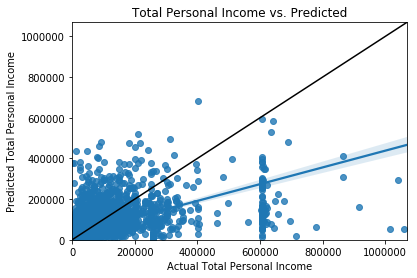

In [26]:
predictions_pers = pers_inc_pipeline.predict(X_test)

# Plot actual vs predicted
fig, ax = plt.subplots()
ax = sns.regplot(y_test, predictions_pers)#, marker='.', linestyle='none')
lower = 0
upper = max(y_test.max(), predictions_pers.max()) + 10000
liner = np.arange(lower, upper)
ax.plot(liner, liner, color='k')
ax.set_xlim(lower, upper)
ax.set_ylim(lower, upper)
ax.set_title('Total Personal Income vs. Predicted')
ax.set_xlabel('Actual Total Personal Income')
ax.set_ylabel('Predicted Total Personal Income')
plt.rcParams["figure.figsize"] = [4,4]

In [28]:
imps_pers = list(zip(pers_inc_pipeline.named_steps['reg'].feature_importances_, 
                     X_train.columns))
sorted(imps_pers, key=lambda tup: tup[0], reverse=True)[:15]

[(0.015547567291145592, 'AGEP'),
 (0.006694876419869801, 'FamType_PU'),
 (0.006608194143419285, 'TotalWorkHrs_PU'),
 (0.004774831141534058, 'FTPTWork'),
 (0.00469248382048341, 'EducAttain'),
 (0.00436351341183179, 'MRNT'),
 (0.0037353994532746382, 'Boro'),
 (0.003696698220815743, 'JWTR'),
 (0.0036964648389549537, 'Ethnicity'),
 (0.0036936192163132564, 'TEN'),
 (0.0030972619116118702, 'WKHP'),
 (0.002844298571018428, 'Povunit_Rel'),
 (0.0027464484440693875, 'AgeCateg'),
 (0.002433785650907912, 'NP'),
 (0.0022940933411346323, 'HousingStatus')]

In [ ]:
# Pull off 'NYCgov_Pov_Stat' for our target variable
y = X['NYCgov_Pov_Stat'].replace({'NYCgov_Pov_Stat': {1: 'Pov', 2:'Not Pov'}})
X = X.drop('NYCgov_Pov_Stat', axis='columns')

# Get train and test - be sure to stratify since this is imbalanced data (poverty ~20% of the set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Transforms for pipeline: 
# 1) categorize to prep for one-hot encoding
# 2) one-hot encode, dropping one to avoid colinearity
# 3) deal with imbalanced data with sampling strategies (poverty is ~20% of total)
# 4) scale data
# 5) classifiers
categorizer = Categorizer(columns=dummy_these)
dummy_encoder = DummyEncoder(drop_first=True)
samplers = [SMOTE(random_state=42), SMOTETomek(random_state=42), TomekLinks(random_state=42)]
#scalers = [StandardScaler(), Normalizer(), PowerTransformer(), QuantileTransformer()]
scalers = [Normalizer()]
scaler = Normalizer()
#classifiers = [LogisticRegression(), SGDClassifier(), AdaBoostClassifier(), BaggingClassifier(), GradientBoostingClassifier(), 
               #RandomForestClassifier(), BalancedBaggingClassifier(), BalancedRandomForestClassifier(), RUSBoostClassifier()]
#classifiers = [BalancedBaggingClassifier(), BaggingClassifier(), RandomForestClassifier(), BalancedRandomForestClassifier(), 
               #AdaBoostClassifier(), GradientBoostingClassifier()]
#classifiers = [RandomForestClassifier(), BalancedRandomForestClassifier()]
classifiers = [BalancedRandomForestClassifier()]

#sampler = TomekLinks(random_state=42)
#scaler = QuantileTransformer()
#clf = LogisticRegression(solver='lbfgs', max_iter=200)
#clf = RandomForestClassifier(n_estimators=100)
#clf = AdaBoostClassifier()
#params={0: {'clf__C': [1, 1e-1, 1e-2, 1e-3], 'clf__max_iter': [1e2, 1e3, 1e4], # Logistic Regression
                               #'clf__solver': ['lbfgs', 'liblinear', 'sag', 'saga']}, 
        #1: {'n_estimators': [1e1, 1e2, 1e3], 'max_features': [5, 10, 50, 100], # Random Forest Classifier
                         #'criterion': ['gini', 'entropy']}
       #}
#params = {0: {'clf__n_estimators': [10, 100, 1000], 'clf__max_features': [5, 10, 50, 100],
              #'clf__criterion': ['gini', 'entropy']},
          #1: {'clf__n_estimators': [10, 100, 1000], 'clf__max_features': [5, 10, 50, 100],
              #'clf__criterion': ['gini', 'entropy'], 'clf_sampling_strategy': [0.05, 0.25, 0.5, 0.75, 0.95]}
         #}

params = {0: {'clf__n_estimators': [1000], 'clf__max_features': [100],
              'clf__sampling_strategy': ['not minority', 'not majority', 'all']}}
          #1: {'clf__n_estimators': [10, 100, 1000], 'clf__max_features': [5, 10, 50, 100],
              #'clf__criterion': ['gini', 'entropy']},
         #}

#parameters = {'clf__n_estimators': [10, 100, 1000], 'clf__max_features': [5, 10, 50, 100], 'clf__criterion': ['gini', 'entropy']}
parameters = {'clf__n_estimators': [100], 'clf__max_features': ['auto'], 'clf__criterion': ['gini']}

cachedir = tempfile.mkdtemp()

#pipeline = imbPipeline(steps=[('cat', categorizer),
                              #('dummies', dummy_encoder),
                              #('sampler', sampler),
                              #('scaler', scaler),
                              #('clf', BalancedRandomForestClassifier())], 
                      #memory=cachedir)
                    
#grid = GridSearchCV(estimator=pipeline, param_grid=parameters, cv=5, n_jobs=-1, pre_dispatch=2, verbose=9)#, scoring=balanced_accuracy_score())
#grid = GridSearchCV(estimator=pipeline, param_grid=parameters, cv=5, n_jobs=-1, verbose=9)

#t0 = time.time()
#grid.fit(X_train, y_train)
#time_to_fit = time.time() - t0
#print('Took: ' + '{:4.2f}'.format(time_to_fit) + 's to fit ')
#print(grid.cv_results_)

#for sampler, i in zip(samplers, range(len(samplers))):
for i in range(1):
    #for scaler, j in zip(scalers, range(len(scalers))):
    for scaler in scalers:
        for k in range(len(classifiers)):
            #pipeline = Pipeline(steps=[#('cat', categorizer),
            pipeline = imbPipeline(steps=[('cat', categorizer),
                                          ('dummies', dummy_encoder),
                                          #('sampler', sampler),
                                          ('scaler', scaler),
                                          ('clf', classifiers[k])],
                                  memory=cachedir)

            #print(pipeline)
            #print(params[i])
            #pipeline.get_params().keys()
            grid = GridSearchCV(estimator=pipeline, param_grid=params[k], cv=3, n_jobs=-1, verbose=9)#, scoring=balanced_accuracy_score())

            t0 = time.time()
            #pipeline.fit(X_train, y_train)
            grid.fit(X_train, y_train)
            time_to_fit = time.time() - t0
            print('Took: ' + '{:4.2f}'.format(time_to_fit) + 's to fit ')
            print(grid.cv_results_)
            print('best estimator: ' + str(grid.best_estimator_))
            print('best params: ' + str(grid.best_params_))
            print('best index: ' + str(grid.best_index_))
            
            #print(str(sampler) + ',' + str(scaler) + ',' + str(classifiers[k]))
            #print(str(scaler) + ',' + str(classifiers[k]))
                  
            #means = grid.cv_results_['mean_test_score']
            #stds = grid.cv_results_['std_test_score']
            #for mean, std, params in zip(means, stds, grid.cv_results_['params']):
                #print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

            #predictions = pipeline.predict(X_test)

#print('Predictions: ' + str(predictions))
#print('Actual:\n' + str(y_small))
            #print('\nBalanced accuracy: ' + str(balanced_accuracy_score(y_test, predictions)))
            #print('Geometric mean: ' + str(geometric_mean_score(y_test, predictions)))
            #print('Confusion matrix:\n' + str(confusion_matrix(y_test, predictions)))
            #print('\nClassification report:\n' + str(classification_report_imbalanced(y_test, predictions)))

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


In [13]:
geometric_mean_score(grid.predict(X_test), y_test)

0.7975358685378098

In [35]:
#tester = BalancedRandomForestClassifier().fit(X=X_train, y=y_train)
#len(tester.feature_importances_)
#X_train.columns
#geometric_mean_score(tester.predict(X_test), y_test)  #0.775727880752169
imps = list(zip(tester.feature_importances_, X_train.columns))
sorted(imps, key=lambda tup: tup[0])[-15:]

[(0.019535791275811728, 'WKW_2'),
 (0.020252231346152935, 'INTP_adj_1'),
 (0.020452137721584687, 'SCHL_2'),
 (0.020767468686063252, 'RNTP_adj'),
 (0.02515045254416771, 'WKHP_2'),
 (0.026205088630138082, 'AGEP_1'),
 (0.02817688155652038, 'SCHL_1'),
 (0.03238306328525264, 'WKW_1'),
 (0.03242418603775719, 'JWTR_1'),
 (0.03587014309356664, 'RETP_adj_1'),
 (0.041251391667779504, 'WKHP_1'),
 (0.05057339662820781, 'SSP_adj_1'),
 (0.052182437399624144, 'WAGP_adj_2'),
 (0.07156076688876317, 'TotalWorkHrs_PU'),
 (0.14873418922209963, 'WAGP_adj_1')]

In [31]:
results = pd.DataFrame({'mean_fit_time': np.array([ 29.3565313 ,  21.269967  , 133.63124331,   6.9153959 ,
        17.71104503, 151.52857844,   8.77863534,  36.48309787,
       353.55145939,  10.91108894,  62.25011571, 604.09919691,
         6.63593658,  18.70342271, 125.81533424,   5.24119258,
        16.36292839, 141.45259889,   7.89260626,  28.13510966,
       273.91240621,   9.28567576,  44.10937214, 356.8786389 ]), 'std_fit_time': np.array([ 0.77492853,  2.90770999, 11.63067571,  0.2850153 ,  0.98171153,
       11.44797585,  0.29892795,  3.36007335, 24.64549427,  0.59362711,
        6.20874779, 40.38846034,  0.20280898,  0.27479866, 10.47984029,
        0.84278515,  1.09157463, 12.09636917,  0.18592348,  1.8504363 ,
       17.28253135,  0.37329269,  4.38992519, 99.02754836]), 'mean_score_time': np.array([ 7.33835514,  8.92508117, 24.09163777,  8.09356125,  7.32807509,
       19.51869694,  7.59556937,  6.94122378, 14.72333399,  7.78833922,
        7.38280678, 15.11881781,  8.04199298,  9.8266205 , 25.7414674 ,
        6.29152044,  8.31556026, 18.50302108,  7.92796397,  7.69944366,
       13.55180319,  7.96719853,  7.42520293, 11.7625773 ]), 'std_score_time': np.array([0.1306685 , 2.03098883, 2.33742256, 0.45626301, 1.50775737,
       3.48599838, 0.21847926, 1.10654311, 2.18771397, 0.04787844,
       1.2097773 , 2.10400838, 0.09428107, 0.18964651, 3.18375043,
       1.19595878, 0.94813268, 1.95163257, 0.19510065, 1.0073612 ,
       1.71333338, 0.16709411, 1.21011483, 2.31377346]), 'param_clf__criterion': np.ma.masked_array(data=['gini', 'gini', 'gini', 'gini', 'gini', 'gini', 'gini',
                   'gini', 'gini', 'gini', 'gini', 'gini', 'entropy',
                   'entropy', 'entropy', 'entropy', 'entropy', 'entropy',
                   'entropy', 'entropy', 'entropy', 'entropy', 'entropy',
                   'entropy'],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_clf__max_features': np.ma.masked_array(data=[5, 5, 5, 10, 10, 10, 50, 50, 50, 100, 100, 100, 5, 5,
                   5, 10, 10, 10, 50, 50, 50, 100, 100, 100],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_clf__n_estimators': np.ma.masked_array(data=[10, 100, 1000, 10, 100, 1000, 10, 100, 1000, 10, 100,
                   1000, 10, 100, 1000, 10, 100, 1000, 10, 100, 1000, 10,
                   100, 1000],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'clf__criterion': 'gini', 'clf__max_features': 5, 'clf__n_estimators': 10}, {'clf__criterion': 'gini', 'clf__max_features': 5, 'clf__n_estimators': 100}, {'clf__criterion': 'gini', 'clf__max_features': 5, 'clf__n_estimators': 1000}, {'clf__criterion': 'gini', 'clf__max_features': 10, 'clf__n_estimators': 10}, {'clf__criterion': 'gini', 'clf__max_features': 10, 'clf__n_estimators': 100}, {'clf__criterion': 'gini', 'clf__max_features': 10, 'clf__n_estimators': 1000}, {'clf__criterion': 'gini', 'clf__max_features': 50, 'clf__n_estimators': 10}, {'clf__criterion': 'gini', 'clf__max_features': 50, 'clf__n_estimators': 100}, {'clf__criterion': 'gini', 'clf__max_features': 50, 'clf__n_estimators': 1000}, {'clf__criterion': 'gini', 'clf__max_features': 100, 'clf__n_estimators': 10}, {'clf__criterion': 'gini', 'clf__max_features': 100, 'clf__n_estimators': 100}, {'clf__criterion': 'gini', 'clf__max_features': 100, 'clf__n_estimators': 1000}, {'clf__criterion': 'entropy', 'clf__max_features': 5, 'clf__n_estimators': 10}, {'clf__criterion': 'entropy', 'clf__max_features': 5, 'clf__n_estimators': 100}, {'clf__criterion': 'entropy', 'clf__max_features': 5, 'clf__n_estimators': 1000}, {'clf__criterion': 'entropy', 'clf__max_features': 10, 'clf__n_estimators': 10}, {'clf__criterion': 'entropy', 'clf__max_features': 10, 'clf__n_estimators': 100}, {'clf__criterion': 'entropy', 'clf__max_features': 10, 'clf__n_estimators': 1000}, {'clf__criterion': 'entropy', 'clf__max_features': 50, 'clf__n_estimators': 10}, {'clf__criterion': 'entropy', 'clf__max_features': 50, 'clf__n_estimators': 100}, {'clf__criterion': 'entropy', 'clf__max_features': 50, 'clf__n_estimators': 1000}, {'clf__criterion': 'entropy', 'clf__max_features': 100, 'clf__n_estimators': 10}, {'clf__criterion': 'entropy', 'clf__max_features': 100, 'clf__n_estimators': 100}, {'clf__criterion': 'entropy', 'clf__max_features': 100, 'clf__n_estimators': 1000}], 'split0_test_score': np.array([0.91245407, 0.91866211, 0.91942227, 0.90903332, 0.91625491,
       0.91980236, 0.91600152, 0.92246294, 0.92296972, 0.91460788,
       0.92702395, 0.92727733, 0.91118713, 0.92018244, 0.91967566,
       0.91308755, 0.92018244, 0.921196  , 0.91435449, 0.92525022,
       0.92715064, 0.91600152, 0.92639047, 0.92854428]), 'split1_test_score': np.array([0.91320324, 0.92004562, 0.92042575, 0.91180943, 0.92080588,
       0.91979219, 0.9175114 , 0.92435378, 0.92549417, 0.91409022,
       0.92967562, 0.92790167, 0.91104916, 0.91953877, 0.92042575,
       0.90927522, 0.92194627, 0.92181956, 0.91586417, 0.92663457,
       0.9270147 , 0.92017233, 0.92904207, 0.93132286]), 'split2_test_score': np.array([0.91116462, 0.92117602, 0.91990876, 0.91040426, 0.92028894,
       0.92180966, 0.91838804, 0.92523128, 0.92700545, 0.9177544 ,
       0.92599164, 0.92789254, 0.91078444, 0.9210493 , 0.92028894,
       0.9153466 , 0.92244329, 0.92054239, 0.91471296, 0.92497782,
       0.92738563, 0.91940185, 0.92687872, 0.92713218]), 'mean_test_score': np.array([0.91227403, 0.91996114, 0.91991891, 0.91041561, 0.9191164 ,
       0.92046798, 0.91730022, 0.92401588, 0.92515628, 0.91548403,
       0.92756378, 0.92769049, 0.91100693, 0.9202568 , 0.92013009,
       0.91256969, 0.92152391, 0.92118601, 0.91497719, 0.92562088,
       0.92718365, 0.91852509, 0.92743707, 0.92899983]), 'std_test_score': np.array([0.00084192, 0.00102804, 0.00040974, 0.00113341, 0.00203455,
       0.00094862, 0.00098567, 0.00115515, 0.00166481, 0.00161909,
       0.00155163, 0.0002922 , 0.00016709, 0.00061889, 0.00032618,
       0.00250546, 0.00097011, 0.00052144, 0.00064403, 0.00072536,
       0.00015322, 0.00181211, 0.00115228, 0.00174085]), 'rank_test_score': np.array([22, 14, 15, 24, 16, 11, 18,  8,  7, 19,  3,  2, 23, 12, 13, 21,  9,
       10, 20,  6,  5, 17,  4,  1], dtype=np.int32), 'split0_train_score': np.array([0.99708547, 1.        , 1.        , 0.99651524, 1.        ,
       1.        , 0.99524805, 1.        , 1.        , 0.99581829,
       1.        , 1.        , 0.99531141, 1.        , 1.        ,
       0.99645188, 1.        , 1.        , 0.9962618 , 1.        ,
       1.        , 0.99746563, 1.        , 1.        ]), 'split1_train_score': np.array([0.99562848, 1.        , 1.        , 0.99664217, 1.        ,
       1.        , 0.99562848, 1.        , 1.        , 0.99619868,
       1.        , 1.        , 0.99588191, 1.        , 1.        ,
       0.99664217, 1.        , 1.        , 0.99581855, 1.        ,
       1.        , 0.99600862, 1.        , 1.        ]), 'split2_train_score': np.array([0.99676908, 1.        , 1.        , 0.99670573, 1.        ,
       1.        , 0.99632563, 1.        , 1.        , 0.99689579,
       1.        , 1.        , 0.99588217, 1.        , 1.        ,
       0.99607222, 0.99993665, 1.        , 0.99569211, 1.        ,
       1.        , 0.99575546, 1.        , 1.        ]), 'mean_train_score': np.array([0.99649435, 1.        , 1.        , 0.99662105, 1.        ,
       1.        , 0.99573405, 1.        , 1.        , 0.99630425,
       1.        , 1.        , 0.99569183, 1.        , 1.        ,
       0.99638876, 0.99997888, 1.        , 0.99592415, 1.        ,
       1.        , 0.9964099 , 1.        , 1.        ]), 'std_train_score': np.array([6.25733424e-04, 0.00000000e+00, 0.00000000e+00, 7.91906591e-05,
       0.00000000e+00, 0.00000000e+00, 4.46206266e-04, 0.00000000e+00,
       0.00000000e+00, 4.46177186e-04, 0.00000000e+00, 0.00000000e+00,
       2.68995301e-04, 0.00000000e+00, 0.00000000e+00, 2.36922985e-04,
       2.98640811e-05, 0.00000000e+00, 2.44267970e-04, 0.00000000e+00,
       0.00000000e+00, 7.53630262e-04, 0.00000000e+00, 0.00000000e+00])})
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__criterion,param_clf__max_features,param_clf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,29.356531,0.774929,7.338355,0.130668,gini,5,10,"{'clf__criterion': 'gini', 'clf__max_features'...",0.912454,0.913203,0.911165,0.912274,0.000842,22,0.997085,0.995628,0.996769,0.996494,0.000626
1,21.269967,2.907710,8.925081,2.030989,gini,5,100,"{'clf__criterion': 'gini', 'clf__max_features'...",0.918662,0.920046,0.921176,0.919961,0.001028,14,1.000000,1.000000,1.000000,1.000000,0.000000
2,133.631243,11.630676,24.091638,2.337423,gini,5,1000,"{'clf__criterion': 'gini', 'clf__max_features'...",0.919422,0.920426,0.919909,0.919919,0.000410,15,1.000000,1.000000,1.000000,1.000000,0.000000
3,6.915396,0.285015,8.093561,0.456263,gini,10,10,"{'clf__criterion': 'gini', 'clf__max_features'...",0.909033,0.911809,0.910404,0.910416,0.001133,24,0.996515,0.996642,0.996706,0.996621,0.000079
4,17.711045,0.981712,7.328075,1.507757,gini,10,100,"{'clf__criterion': 'gini', 'clf__max_features'...",0.916255,0.920806,0.920289,0.919116,0.002035,16,1.000000,1.000000,1.000000,1.000000,0.000000
5,151.528578,11.447976,19.518697,3.485998,gini,10,1000,"{'clf__criterion': 'gini', 'clf__max_features'...",0.919802,0.919792,0.921810,0.920468,0.000949,11,1.000000,1.000000,1.000000,1.000000,0.000000
6,8.778635,0.298928,7.595569,0.218479,gini,50,10,"{'clf__criterion': 'gini', 'clf__max_features'...",0.916002,0.917511,0.918388,0.917300,0.000986,18,0.995248,0.995628,0.996326,0.995734,0.000446
7,36.483098,3.360073,6.941224,1.106543,gini,50,100,"{'clf__criterion': 'gini', 'clf__max_features'...",0.922463,0.924354,0.925231,0.924016,0.001155,8,1.000000,1.000000,1.000000,1.000000,0.000000
8,353.551459,24.645494,14.723334,2.187714,gini,50,1000,"{'clf__criterion': 'gini', 'clf__max_features'...",0.922970,0.925494,0.927005,0.925156,0.001665,7,1.000000,1.000000,1.000000,1.000000,0.000000
9,10.911089,0.593627,7.788339,0.047878,gini,100,10,"{'clf__criterion': 'gini', 'clf__max_features'...",0.914608,0.914090,0.917754,0.915484,0.001619,19,0.995818,0.996199,0.996896,0.996304,0.000446


In [24]:
# Pull off 'NYCgov_Pov_Stat' for our target variable
y = X['NYCgov_Pov_Stat'].replace({'NYCgov_Pov_Stat': {1: 'Pov', 2:'Not Pov'}})
X = X.drop('NYCgov_Pov_Stat', axis='columns')

# Get train and test - be sure to stratify since this is imbalanced data (poverty ~20% of the set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Transforms for pipeline: 
# 1) categorize to prep for one-hot encoding
# 2) one-hot encode, dropping one to avoid colinearity
# 3) deal with imbalanced data with sampling strategies (poverty is ~20% of total)
# 4) scale data
# 5) classifiers
categorizer = Categorizer(columns=dummy_these)
dummy_encoder = DummyEncoder(drop_first=True)
#samplers = [SMOTE(random_state=42), SMOTETomek(random_state=42), TomekLinks(random_state=42)]
scaler = Normalizer()
classifier = BalancedRandomForestClassifier(n_estimators=1000, max_features=100, sampling_strategy='auto')

cachedir = tempfile.mkdtemp()

pipeline = imbPipeline(steps=[('cat', categorizer),
                              ('dummies', dummy_encoder),
                              ('scaler', scaler),
                              ('clf', classifier)], 
                      memory=cachedir)
                    
t0 = time.time()
pipeline.fit(X_train, y_train)
time_to_fit = time.time() - t0
print('Took: ' + '{:4.2f}'.format(time_to_fit) + 's to fit ')

/home/chachi/miniconda3/envs/pandas-tutorial/lib/python3.7/site-packages/imblearn/pipeline.py:197: UserWarning: Persisting input arguments took 1.30s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])
/home/chachi/miniconda3/envs/pandas-tutorial/lib/python3.7/site-packages/imblearn/pipeline.py:197: UserWarning: Persisting input arguments took 1.00s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can

Took: 1928.47s to fit 


In [26]:
#pipeline.named_steps['clf'].feature_importances_
imps = list(zip(pipeline.named_steps['clf'].feature_importances_, X_train.columns))
sorted(imps, key=lambda tup: tup[0])[-15:]
#geometric_mean_score(y_test, pipeline.predict(X_test)) # 0.901335010891502

[(0.0005020056104968013, 'JWTR_4'),
 (0.0006180397991121181, 'Boro_10'),
 (0.0006182323610456678, 'ENG_11'),
 (0.0006666647803905448, 'CIT_10'),
 (0.000845561954102215, 'Ethnicity_3'),
 (0.0010203369930211923, 'JWTR_3'),
 (0.0016273172555736843, 'INTP_adj_2'),
 (0.002282882484302701, 'Ethnicity_11'),
 (0.002428528916065317, 'AGEP_1'),
 (0.0039253585625141215, 'DIS_10'),
 (0.005603247830117554, 'JWTR_2'),
 (0.006984126312808381, 'INTP_adj_1'),
 (0.011814645668473192, 'Boro_1'),
 (0.016108428339244498, 'JWTR_1'),
 (0.05686880032439872, 'ENG_10')]

In [20]:
# Pull off 'NYCgov_Pov_Stat' for our target variable
y = X['NYCgov_Pov_Stat'].replace({'NYCgov_Pov_Stat': {1: 'Pov', 2:'Not Pov'}})
X = X.drop('NYCgov_Pov_Stat', axis='columns')

# Get train and test - be sure to stratify since this is imbalanced data (poverty ~20% of the set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Transforms for pipeline: 
# 1) categorize to prep for one-hot encoding
# 2) one-hot encode, dropping one to avoid colinearity
# 3) deal with imbalanced data with sampling strategies (poverty is ~20% of total)
# 4) scale data
# 5) classifiers
categorizer = Categorizer(columns=dummy_these)
dummy_encoder = DummyEncoder(drop_first=True)
#samplers = [SMOTE(random_state=42), SMOTETomek(random_state=42), TomekLinks(random_state=42)]
scaler = Normalizer()
classifier = RandomForestClassifier(n_estimators=1000, max_features=100)

cachedir = tempfile.mkdtemp()

pipeline = imbPipeline(steps=[('cat', categorizer),
                              ('dummies', dummy_encoder),
                              ('scaler', scaler),
                              ('clf', classifier)], 
                      memory=cachedir)
                    
t0 = time.time()
pipeline.fit(X_train, y_train)
time_to_fit = time.time() - t0
print('Took: ' + '{:4.2f}'.format(time_to_fit) + 's to fit ')

/home/chachi/miniconda3/envs/pandas-tutorial/lib/python3.7/site-packages/imblearn/pipeline.py:197: UserWarning: Persisting input arguments took 1.12s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])
/home/chachi/miniconda3/envs/pandas-tutorial/lib/python3.7/site-packages/imblearn/pipeline.py:197: UserWarning: Persisting input arguments took 0.78s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can

Took: 1172.32s to fit 


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 <a list of 15 Text xticklabel objects>)

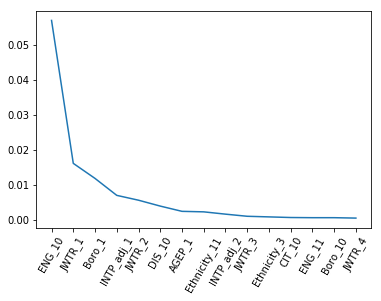

In [49]:
imps = list(zip(X_train.columns, pipeline.named_steps['clf'].feature_importances_))
imps=(sorted(imps, key=lambda tup: tup[1]))
imps.reverse()
#geometric_mean_score(y_test, pipeline.predict(X_test)) # 0.8741667300789631
labels_i = [x[0] for x in imps][:15]
ys_i = [x[1] for x in imps][:15]
plt.plot(labels_i, ys_i)
plt.xticks(rotation=60)

### Feature Engineering - No Financials
This will be as above, but pulling out the financial variables.

In [51]:
X2 = all_2016.copy()

categoricals = ['AGEP', 'CIT', 'SCHL', 'SEX', 'ENG', 'MSP', 'WKW', 'WKHP', 'DIS', 'JWTR', 'Ethnicity', 'Boro', 'NP', 'TEN', 'HHT', 'HousingStatus', 'TotalWorkHrs_PU']

# We'll create separate dataframes for personal and poverty-unit variables, then join them together
personal_columns = ['AGEP', 'CIT', 'SCHL', 'SEX', 'ENG', 'MSP', 'WKW', 'WKHP', 'DIS', 'JWTR', 'Ethnicity', 'Boro']
pu_columns = ['NP', 'TEN', 'HHT', 'HousingStatus', 'TotalWorkHrs_PU', 'NYCgov_Pov_Stat']

# Create a dataframe for the personal columns, including our 3 indicator variables
X2_pers = X2.copy()
X2_pers_columns = ['SERIALNO', 'Povunit_ID', 'SPORDER'] + personal_columns
X2_pers = X2_pers[X2_pers_columns]

# Grouping by SERIALNO and Povunit_ID, put SPORDER (person # in household) at the top as multi-index columns
X2_pers = X2_pers.set_index(['SERIALNO', 'Povunit_ID', 'SPORDER']).unstack('SPORDER').fillna(0)

# Turn the multi-index columns into a single indexed column: 'AGEP_1', 'AGEP_2', 'AGEP_3', etc.
X2_pers.columns = list(map('_'.join, [(y, str(z)) for y, z in (x for x in X2_pers.columns)]))

# Create a dataframe for the poverty-unit columns, including our 3 indicator variables
X2_pu = X2.copy()
X2_pu_columns = ['SERIALNO', 'Povunit_ID', 'SPORDER'] + pu_columns
X2_pu = X2_pu[X2_pu_columns]

# Grouping by SERIALNO and Povunit_ID, put SPORDER (person # in household) at the top as multi-index columns
X2_pu = X2_pu.set_index(['SERIALNO', 'Povunit_ID', 'SPORDER']).unstack('SPORDER').fillna(0)

# Groupby and take the max of SPORDER (these are poverty-unit variables; if there is a nonzero value, it's unique)
X2_pu = X2_pu.stack().groupby(['SERIALNO', 'Povunit_ID']).max()

# Add the personal and poverty-unit dataframes
X2 = X2_pers.add(X2_pu, fill_value=0)
X2.tail()

,,AGEP_1,AGEP_10,AGEP_11,AGEP_12,AGEP_13,AGEP_14,AGEP_15,AGEP_16,AGEP_17,AGEP_18,...,WKW_19,WKW_2,WKW_20,WKW_3,WKW_4,WKW_5,WKW_6,WKW_7,WKW_8,WKW_9
SERIALNO,Povunit_ID,,,,,,,,,,,,,,,,,,,,,
1521345,1,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1521371,1,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1521389,1,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1521399,1,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1521415,1,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
# Pull off 'NYCgov_Pov_Stat' for our target variable
y2 = X2['NYCgov_Pov_Stat'].replace({'NYCgov_Pov_Stat': {1: 'Pov', 2:'Not Pov'}})
X2 = X2.drop('NYCgov_Pov_Stat', axis='columns')

# Get train and test - be sure to stratify since this is imbalanced data (poverty ~20% of the set)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, stratify=y2)

# Transforms for pipeline: 
# 1) categorize to prep for one-hot encoding
# 2) one-hot encode, dropping one to avoid colinearity
# 3) deal with imbalanced data with sampling strategies (poverty is ~20% of total)
# 4) scale data
# 5) classifiers
categorizer = Categorizer(columns=dummy_these)
dummy_encoder = DummyEncoder(drop_first=True)
#samplers = [SMOTE(random_state=42), SMOTETomek(random_state=42), TomekLinks(random_state=42)]
scaler = Normalizer()
classifier = RandomForestClassifier(n_estimators=1000, max_features=100)

cachedir = tempfile.mkdtemp()

pipeline = imbPipeline(steps=[('cat', categorizer),
                              ('dummies', dummy_encoder),
                              ('scaler', scaler),
                              ('clf', classifier)], 
                      memory=cachedir)
                    
t0 = time.time()
pipeline.fit(X2_train, y2_train)
time_to_fit = time.time() - t0
print('Took: ' + '{:4.2f}'.format(time_to_fit) + 's to fit ')

/home/chachi/miniconda3/envs/pandas-tutorial/lib/python3.7/site-packages/imblearn/pipeline.py:197: UserWarning: Persisting input arguments took 1.03s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])
/home/chachi/miniconda3/envs/pandas-tutorial/lib/python3.7/site-packages/imblearn/pipeline.py:197: UserWarning: Persisting input arguments took 0.64s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can

Took: 977.44s to fit 


In [54]:
#pipeline.named_steps['clf'].feature_importances_
imps = list(zip(pipeline.named_steps['clf'].feature_importances_, X2_train.columns))
sorted(imps, key=lambda tup: tup[0])[-15:]
#geometric_mean_score(y2_test, pipeline.predict(X2_test)) # 0.5891144868773415

[(0.0019536750561223435, 'CIT_16'),
 (0.0019766238091623893, 'CIT_8'),
 (0.002074372847437007, 'CIT_19'),
 (0.002103638190090756, 'CIT_7'),
 (0.0021084495403344244, 'CIT_12'),
 (0.002192773240239379, 'CIT_20'),
 (0.0022114526799705417, 'CIT_5'),
 (0.0022167018769647475, 'CIT_15'),
 (0.0023101070754851017, 'CIT_18'),
 (0.0023378895980513356, 'DIS_7'),
 (0.0023659286886432707, 'CIT_6'),
 (0.0024051439784516827, 'CIT_3'),
 (0.0024677871327048293, 'CIT_17'),
 (0.002469216276971846, 'CIT_14'),
 (0.002591447212012863, 'CIT_4')]

In [62]:
all_2016.INTP_adj.describe()
#len(all_2016[all_2016.INTP_adj > 0])
X.loc[X.INTP_adj > 0, 'INTP_adj'].describe()

AttributeError: 'DataFrame' object has no attribute 'INTP_adj'

In [89]:
trials = all_2016.copy()

categoricals = ['AGEP', 'CIT', 'SCHL', 'SEX', 'ENG', 'MSP', 'WKW', 'WKHP', 'DIS', 'JWTR', 'Ethnicity', 'Boro', 'NP', 'TEN', 'HHT', 'HousingStatus', 'TotalWorkHrs_PU']

# We'll create separate dataframes for personal and poverty-unit variables, then join them together
#personal_columns = ['AGEP', 'CIT', 'SCHL', 'SEX', 'ENG', 'MSP', 'WKW', 'WKHP', 'DIS', 'JWTR', 'WAGP_adj', 'INTP_adj', 'SEMP_adj', 'SSP_adj', 'SSIP_adj', 'PA_adj', 'RETP_adj', 'OI_adj', 'Ethnicity', 'Boro']
personal_nums = ['WAGP_adj', 'INTP_adj', 'SEMP_adj', 'SSP_adj', 'SSIP_adj', 'PA_adj', 'RETP_adj', 'OI_adj'] 
#pu_columns = ['NP', 'TEN', 'HHT', 'MRGP_adj', 'RNTP_adj', 'HousingStatus', 'TotalWorkHrs_PU', 'NYCgov_Pov_Stat']

# Create a dataframe for the personal columns, including our 3 indicator variables
#X_pers = X.copy()
#X_pers_columns = ['SERIALNO', 'Povunit_ID', 'SPORDER'] + personal_columns
#X_pers = X_pers[X_pers_columns]

# Grouping by SERIALNO and Povunit_ID, put SPORDER (person # in household) at the top as multi-index columns
#X_pers = X_pers.set_index(['SERIALNO', 'Povunit_ID', 'SPORDER']).unstack('SPORDER').fillna(0)

# Turn the multi-index columns into a single indexed column: 'AGEP_1', 'AGEP_2', 'AGEP_3', etc.
#X_pers.columns = list(map('_'.join, [(y, str(z)) for y, z in (x for x in X_pers.columns)]))

# Create a dataframe for the poverty-unit columns, including our 3 indicator variables
X_trials = trials.copy()
X_trials_columns = ['SERIALNO', 'Povunit_ID', 'SPORDER'] + personal_nums
X_trials = X_trials[X_trials_columns]

# Grouping by SERIALNO and Povunit_ID, put SPORDER (person # in household) at the top as multi-index columns
X_trials = X_trials.set_index(['SERIALNO', 'Povunit_ID', 'SPORDER']).unstack('SPORDER').fillna(0)

# Groupby and take the max of SPORDER (these are poverty-unit variables; if there is a nonzero value, it's unique)
X_trials = X_trials.stack().groupby(['SERIALNO', 'Povunit_ID']).sum()

# Add the personal and poverty-unit dataframes
#X = X_pers.add(X_pu, fill_value=0)
#X.tail()
#X_trials[X_trials.OI_adj > 0].OI_adj.describe()
#X_trials.MRGP_adj.describe()
#all_2016[all_2016.Povunit_Rel == 1].RNTP_adj.describe()
#all_2016.loc[(all_2016.Povunit_Rel == 1) & (all_2016.RNTP_adj > 0)].RNTP_adj.describe()
all_2016['RNTP+MRGP'] = all_2016.RNTP_adj + all_2016.MRGP_adj
all_2016.loc[(all_2016.Povunit_Rel == 1) & (all_2016['RNTP+MRGP'] > 0)]['RNTP+MRGP'].describe()

/home/chachi/miniconda3/envs/pandas-tutorial/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


count    24259.000000
mean      1623.764093
std        994.621840
min          4.030352
25%        967.284480
50%       1410.623200
75%       2115.934800
max       6448.563200
Name: RNTP+MRGP, dtype: float64

In [6]:
fX = all_2016.copy()
print(fX[['SERIALNO', 'SPORDER', 'Povunit_ID', 'ENG', 'WKW', 'TotalWorkHrs_PU']].head(10))
fix_orders = {'ENG': {0:0, 4:1, 3:2, 2:3, 1:4, 5:5}, 'WKW': {0:0, 6:1, 5:2, 4:3, 3:4, 2:5, 1:6}, 
              'TotalWorkHrs_PU': {5:0, 4:1, 3:2, 2:3, 1:4}}
#fX[['SERIALNO', 'SPORDER', 'Povunit_ID', 'ENG', 'WKW', 'TotalWorkHrs_PU']].map(fix_orders).head(10)
fX['ENG'] = fX['ENG'].map(fix_orders['ENG'])
fX['WKW'] = fX['WKW'].map(fix_orders['WKW'])
fX['TotalWorkHrs_PU'] = fX['TotalWorkHrs_PU'].map(fix_orders['TotalWorkHrs_PU'])
print(fX[['SERIALNO', 'SPORDER', 'Povunit_ID', 'ENG', 'WKW', 'TotalWorkHrs_PU']].head(10))

#Number of adults, number of kids, number of retirement-age adults, number of working-age adults, any kids, 
#any retirement-age adults
fX['n_adults'] = fX

        SERIALNO  SPORDER  Povunit_ID  ENG  WKW  TotalWorkHrs_PU
710612        39        1           1  1.0  0.0                5
710613        55        1           1  5.0  1.0                1
710614        55        2           1  5.0  1.0                1
710615        55        3           1  5.0  2.0                1
710616        55        4           1  5.0  5.0                1
710617        55        5           1  5.0  4.0                1
710618        69        1           1  5.0  1.0                3
710619       210        1           1  5.0  1.0                2
710620       261        1           1  5.0  1.0                2
710621       261        2           1  5.0  0.0                2
        SERIALNO  SPORDER  Povunit_ID  ENG  WKW  TotalWorkHrs_PU
710612        39        1           1    4    0                0
710613        55        1           1    5    6                4
710614        55        2           1    5    6                4
710615        55        3

In [15]:
# DON'T USE THIS ONE FOR NOW - USE THE OTHER ONE






def add_columns_by_group(df):
    """EDIT THIS DOCSTRING!!!!!!!!!
    Helper function 
    """
    
    df1 = df.copy()
    #print('df1 columns: ' + str(df1.columns))
    #columns = df1.columns[0]
    columns = df1.columns
    #print('columns: ' + str(columns))
    for column in columns:
        if not column in ['SERIALNO', 'Povunit_ID', 'SPORDER']:
            #print('df1:' + str(df1.head()))
            #print('groups:' + str(groups))
            #print('group names:' + str(group_names))
            #print('categories:' + str(categories[column]))
            #print('category names:' + str(category_names[column]))
            #print('column:' + str(column))
            #print(columns)
            print(df1.head())
            add_pu_columns(df1, groups, group_names, categories[column], category_names[column], column)
            add_pu_columns(df1, groups, group_names, categories[column], category_names[column], 'AGEP')
            df1.drop(column, axis='columns')
    return df1

def add_pu_columns(df, groups, group_names, categories, category_names, column):
    """EDIT THIS DOCSTRING!!!!!!!!!
    Adds columns to dataframe 'df' containing calculations by poverty-unit, restricted by categories, considering groups.
    Calculations include any(), all(), min(), max(), count(), sum(), mean(), and % in given category.
    Input: a dataframe with multi-index consisting of 'SERIALNO', 'Povunit_ID', and 'SPORDER'; a set of masks and list of
    names for the groups; a set of masks and a list of names for the categories; and the column of interest.
    Output: no return value.  Inserts a series of columns into the dataframe including min, max, count, sum, any, all,
    % of total, and mean - within households, focusing on the groups and categories of interest. 
    """
    for group, group_name in zip(groups, group_names):
        for category, category_name in zip(categories, category_names):
            # Grouping by SERIALNO and Povunit_ID, put SPORDER (person # in household) at the top as multi-index columns
            df = df.set_index(['SERIALNO', 'Povunit_ID', 'SPORDER']).unstack('SPORDER').fillna(0)
            stacked = df[group & category].stack().groupby(['SERIALNO', 'Povunit_ID'])[column]
            #print('columns to be stacked ' + str(df[group & category].columns))
            #print('length to be stacked ' + str(len(df[group & category])))
            #print('cat:' + str(category_name) + ', group:' + str(group_name))
            #print(df.loc[group & category].head())
            anys = stacked.any()
            # would love to use .all() here, but it would always be True because we filtered out everyone else
            mins = stacked.min()
            maxes = stacked.max()
            counts = stacked.count()
            sums = stacked.sum()
            means = sums/counts
            # The divisor below only restricts by 'groups' - so the final calculation is within a household, within
            # the group of interest (e.g. adults), what % is in the category of interest (e.g. works 40 hrs/week)
            divisor_for_percents = df[column][group].stack().groupby(['SERIALNO', 'Povunit_ID']).count()
            try:
                percents = counts.div(divisor_for_percents, axis=0)
                alls = percents == 1
            except: # if the calculation failed, leave percents and alls as a column of zeros
                df_len = len(df.groupby(['SERIALNO', 'Povunit_ID']).sum())
                percents = np.zeros(df_len)

                alls = np.zeros(df_len)
            
            # loop through, put in the dataframe, and fill in NAs of appropriate type
            series_and_names = zip([anys, alls, mins, maxes, counts, sums, means, percents], 
                                  ['any', 'all', 'min', 'max', 'count', 'sum', 'mean', '%'])
            for series, series_name in series_and_names:
                column_title = series_name + '_' + group_name + '_' + category_name
                df[column_title] = series
                if series_name in ['any', 'all']:
                    df[column_title] = df[column_title].fillna(False)
                else:
                    df[column_title] = df[column_title].fillna(0)
                    
def engineer_features(df, columns_to_use, categories, category_names, num_processors, AGEP_yes=True):
    """EDIT THIS DOCSTRING!!!!!!!!!
    Create features for the dataframe. This function is heavily custom and was solely created for DRY-ness.
    Input: a poverty dataframe and whether or not to include financial features.
    Output: returns a copy of the dataframe summarized by poverty-unit, with *only* the new features included. 
    Prints progess updates to the screen as it goes.
    """

    time_0 = time.time()

    # Create dataframe to house new features 
    dfc = df.copy() 
    dfc = dfc[['SERIALNO', 'Povunit_ID', 'SPORDER'] + columns_to_use]

    # Split columns_to_use into num_processors groups for use in parallel processing
    n = len(columns_to_use)
    s = num_processors
    labels = [columns_to_use[i * (n//s + 1) : (i+1) * (n//s + 1)] for i in range(s)]
    chunks = []
    for i in range(s):
        chunks.append(dfc[['SERIALNO', 'Povunit_ID', 'SPORDER'] + labels[i]])
        #print(labels[i])

    # engineer features in parallel
    pool = Pool(num_processors)
    
    #curried = lambda x: partial(add_columns_by_group, dfc, groups, group_names, categories, category_names, x)
    #def add_columns_by_group(df, groups, group_names, categories, category_names, columns):
    #curried = partial(add_columns_by_group, dfc, groups, group_names, categories, category_names, chunks)
    
    
    # FIX THIS -- FOLLOW THE EXAMPLE BELOW TO SPLIT DFC INTO CHUNKS AND THEN MAP OVER THEM
    new_df = pd.concat(pool.map(add_columns_by_group, chunks))
    
    # Close the pool
    pool.close()
    pool.join()
#def parallel_feature_calculation(df, partitions=10, processes=4):
    # calculate features in parallel by splitting the dataframe into partitions and using parallel processes
    #pool = Pool(processes)
    #df_split = np.array_split(df, partitions, axis=1)  # split dataframe into partitions column wise
    #df = pd.concat(pool.map(feature_calculation, df_split))
    #pool.close()
    #pool.join()
    #return df

    # add columns with age only, no categories
    add_pu_columns(new_df, groups, group_names, [mask_any_age], ['age'], 'AGEP')

    # We added a column 'TINP' - drop it if we're not doing financials
    if not 'WAGP_adj' in columns_to_use:
        new_df.drop('TINP', axis='columns')

    # Only return the new features that we engineered
    # The variables features_to_mask and max_ppl were created at the beginning of this function
    #columns_to_mask = features_to_mask * max_ppl
    #dfc = dfc.iloc[:, columns_to_mask:].copy()

    # We ended up with multi-level column headers - just keep the top level
    new_df.columns = new_df.columns.get_level_values(0)
    
    time_took = time.time() - time_0
    print('Complete. Took ' + str(time_took) + 's')
    return(new_df)

dfa = all_2016.copy()

# First, some categoricals have odd ordering; remap them
fix_orders = {'ENG': {0:0, 4:1, 3:2, 2:3, 1:4, 5:5}, 'WKW': {0:0, 6:1, 5:2, 4:3, 3:4, 2:5, 1:6}, 
              'TotalWorkHrs_PU': {5:0, 4:1, 3:2, 2:3, 1:4}}
dfa['ENG'] = dfa['ENG'].map(fix_orders['ENG'])
dfa['WKW'] = dfa['WKW'].map(fix_orders['WKW'])
dfa['TotalWorkHrs_PU'] = dfa['TotalWorkHrs_PU'].map(fix_orders['TotalWorkHrs_PU'])

# Add a column for total personal income - will be ignored if we don't need it
dfa['TINP'] = dfa.WAGP_adj + dfa.INTP_adj + dfa.SEMP_adj + dfa.SSP_adj + dfa.SSIP_adj + \
                dfa.PA_adj + dfa.RETP_adj + dfa.OI_adj

# Grouping by SERIALNO and Povunit_ID, put SPORDER (person # in household) at the top as multi-index columns
dfa = dfa.set_index(['SERIALNO', 'Povunit_ID', 'SPORDER']).unstack('SPORDER').fillna(0)

# Create empty dicts for use in adding new columns
categories = {}
category_names = {}

# Create masks for age groups to use in creating new features
mask_adult = (dfa.AgeCateg == 2) | (dfa.AgeCateg == 3)
mask_65_plus = dfa.AgeCateg == 3
mask_18_64 = dfa.AgeCateg == 2
mask_kid = dfa.AgeCateg == 1
mask_any_age = dfa.AgeCateg != 0
mask_any = mask_any_age

groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

# add masks for CIT
mask_non_cit = dfa.CIT == 5
mask_cit = (dfa.CIT != 5) & (dfa.CIT != 0)
mask_naturalized = dfa.CIT == 4

categories['CIT'] = [mask_non_cit, mask_cit, mask_naturalized, mask_any]
category_names['CIT'] = ['non-cit', 'citizen', 'naturalized_cit', 'any_CIT']

# add masks for SCHL
mask_college_degree = (dfa.SCHL >= 21)
mask_HS_diploma = (dfa.SCHL >= 17)
mask_no_diploma = (dfa.SCHL <= 16)

categories['SCHL'] = [mask_college_degree, mask_HS_diploma, mask_no_diploma, mask_HS_diploma & ~mask_college_degree, mask_any]
category_names['SCHL'] = ['college', 'HS', 'no_diploma', 'diploma_no_bachelors', 'any_SCHL']

# add masks for SEX
mask_male = dfa.SEX == 1
mask_female = dfa.SEX == 2

categories['SEX'] = [mask_male, mask_female, mask_any]
category_names['SEX'] = ['male', 'female', 'any_SEX']

# add masks for English ability (ENG)
# Keep in mind we switched ENG above so that 0 is NA, 1 is not at all, 2 is not very well, ..., 5 is only English
mask_no_english = dfa.ENG == 1
mask_eng_nvw = dfa.ENG == 2
mask_sep_well = dfa.ENG == 3
mask_eng_vw = dfa.ENG == 4
mask_only_eng = dfa.ENG == 5

categories['ENG'] = [mask_no_english, mask_eng_nvw, mask_sep_well, mask_eng_vw, mask_only_eng, mask_any]
category_names['ENG'] = ['ENG_no', 'ENG_nvw', 'ENG_well', 'ENG_vw', 'ENG_only', 'ENG_any']

# add masks for marital status (MSP)
mask_married = (dfa.MSP == 1) | (dfa.MSP == 2)
mask_widowed = dfa.MSP == 3
mask_sep_div = (dfa.MSP == 4) | (dfa.MSP == 5)
mask_not_married = dfa.MSP == 6

categories['MSP'] = [mask_married, mask_widowed, mask_sep_div, mask_not_married, mask_any]
category_names['MSP'] = ['married', 'widowed', 'sep/divorced', 'not_married', 'any_MSP']

# add masks for weeks worked (WKW) -- this is *weeks* worked last year, not *hours per week* (that's WKHP)
# Keep in mind we switched WKW above so that 0 is none, 1 is <14 weeks, 2 is 14-26 weeks, etc.
mask_0_WKW = dfa.WKW == 0
mask_u14_WKW = dfa.WKW == 1
mask_14_26_WKW = dfa.WKW == 2
mask_27_39_WKW = dfa.WKW == 3
mask_40_47_WKW = dfa.WKW == 4
mask_48_49_WKW = dfa.WKW == 5
mask_50_52_WKW = dfa.WKW == 6

categories['WKW'] = [mask_0_WKW, mask_u14_WKW, mask_14_26_WKW, mask_27_39_WKW, mask_40_47_WKW, mask_48_49_WKW, mask_50_52_WKW, 
             (mask_40_47_WKW | mask_48_49_WKW | mask_50_52_WKW), ~mask_0_WKW, mask_any]
category_names['WKW'] = ['no_work', '<14WKW', '14-26WKW', '27-39WKW', '40-47WKW', '48-49WKW', '50-52WKW', '>40WKW', 'nonzero_WKW',
                 'any_WKW']

# add masks for usual hours worked per week last 12 months (WKHP)
mask_0_WKHP = dfa.WKHP == 0
mask_u10_WKHP = dfa.WKHP < 10
mask_u15_WKHP = dfa.WKHP < 15
mask_u20_WKHP = dfa.WKHP < 20
mask_u30_WKHP = dfa.WKHP < 30
mask_u40_WKHP = dfa.WKHP < 40
mask_u50_WKHP = dfa.WKHP < 50
mask_50_plus_WKHP = dfa.WKHP >= 50
mask_40_plus_WKHP = dfa.WKHP >= 40

categories['WKHP'] = [mask_0_WKHP, mask_u10_WKHP, mask_u15_WKHP, mask_u20_WKHP, mask_u30_WKHP, mask_u40_WKHP, 
              mask_u50_WKHP, mask_50_plus_WKHP, mask_40_plus_WKHP, mask_any]
category_names['WKHP'] = ['no_work_hrs', '<10_work_hrs', '<15_work_hrs', '<20_work_hrs', '<30_work_hrs', '<40_work_hrs', 
                  '<50_work_hrs', '50_plus_work_hrs', '40_plus_work_hrs', 'any_WKHP']

# add masks for disability status (DIS)
mask_DIS = dfa.DIS == 1
mask_not_DIS = dfa.DIS == 2

categories['DIS'] = [mask_DIS, mask_not_DIS, mask_any]
category_names['DIS'] = ['DIS', 'not_DIS', 'any_DIS']

# add masks for number of people (NP)
mask_1_NP = dfa.NP == 1
mask_2_NP = dfa.NP == 2
mask_3_NP = dfa.NP == 3
mask_4_NP = dfa.NP == 4
mask_5_NP = dfa.NP == 5
mask_p5_NP = dfa.NP > 5
mask_p6_NP = dfa.NP > 6
mask_p8_NP = dfa.NP > 8
mask_p10_NP = dfa.NP > 10
mask_p12_NP = dfa.NP > 12

categories['NP'] = [mask_1_NP, mask_2_NP, mask_3_NP, mask_4_NP, mask_5_NP, mask_p5_NP, mask_p6_NP, mask_p8_NP, mask_p10_NP, 
              mask_p12_NP, mask_any]
category_names['NP'] = ['NP1', 'NP2', 'NP3', 'NP4', 'NP5', 'NP>5', 'NP>6', 'NP>8', 'NP>10', 'NP>12', 'anyNP']

# add masks for means of transportation to work (JWTR)
categories['JWTR'] = [mask_any]
category_names['JWTR'] = ['work_trans']

# add masks for wages (WAGP_adj)
mask_0_WAG = dfa.WAGP_adj == 0
mask_u10_WAG = dfa.WAGP_adj < 10000
mask_u15_WAG = dfa.WAGP_adj < 15000
mask_u20_WAG = dfa.WAGP_adj < 20000
mask_u25_WAG = dfa.WAGP_adj < 25000
mask_u30_WAG = dfa.WAGP_adj < 30000
mask_u35_WAG = dfa.WAGP_adj < 35000
mask_u40_WAG = dfa.WAGP_adj < 40000
mask_u45_WAG = dfa.WAGP_adj < 45000
mask_u50_WAG = dfa.WAGP_adj < 50000
mask_u60_WAG = dfa.WAGP_adj < 60000
mask_u70_WAG = dfa.WAGP_adj < 70000
mask_u80_WAG = dfa.WAGP_adj < 80000

categories['WAGP_adj'] = [mask_0_WAG, mask_u10_WAG, mask_u15_WAG, mask_u20_WAG, mask_u25_WAG, mask_u30_WAG,  mask_u35_WAG, 
              mask_u40_WAG, mask_u45_WAG, mask_u50_WAG, mask_u60_WAG, mask_u70_WAG, mask_u80_WAG, mask_any]
category_names['WAGP_adj'] = ['WAG0', 'WAG<10', 'WAG<15', 'WAG<20', 'WAG<25', 'WAG<30', 'WAG<35', 
                  'WAG<40', 'WAG<45', 'WAG<50', 'WAG<60', 'WAG<70', 'WAG<80', 'WAG_any']

# add masks for interest income (INTP_adj)
# cutoffs taken from quartiles of nonzero values
mask_0_INT = dfa.INTP_adj <= 0
mask_INT_1q = (dfa.INTP_adj > 0) & (dfa.INTP_adj <= 400)
mask_INT_2q = (dfa.INTP_adj > 400) & (dfa.INTP_adj <= 4000)
mask_INT_3q = (dfa.INTP_adj > 4000) & (dfa.INTP_adj <= 15000)
mask_INT_4q = dfa.INTP_adj > 15000

categories['INTP_adj'] = [mask_0_INT, mask_INT_1q, mask_INT_2q, mask_INT_3q, mask_INT_4q, mask_any]
category_names['INTP_adj'] = ['INT0', 'INT1q', 'INT2q', 'INT3q', 'INT4q', 'INT_any']

# add masks for self-employment income (SEMP_adj)
# cutoffs taken from quartiles of nonzero values
mask_0_SEMP = dfa.SEMP_adj <= 0
mask_SEMP_1q = (dfa.SEMP_adj > 0) & (dfa.SEMP_adj <= 5000)
mask_SEMP_2q = (dfa.SEMP_adj > 5000) & (dfa.SEMP_adj <= 15000)
mask_SEMP_3q = (dfa.SEMP_adj > 15000) & (dfa.SEMP_adj <= 35000)
mask_SEMP_4q = dfa.SEMP_adj > 35000

categories['SEMP_adj'] = [mask_0_SEMP, mask_SEMP_1q, mask_SEMP_2q, mask_SEMP_3q, mask_SEMP_4q, mask_any]
category_names['SEMP_adj'] = ['SEMP0', 'SEMP1q', 'SEMP2q', 'SEMP3q', 'SEMP4q', 'SEMP_any']

# add masks for social security income (SSP_adj)
# cutoffs taken from quartiles of nonzero values
# min 10, 25% 8000, 50% 12,000, 75% 18,000, max 50,000
mask_0_SSP = dfa.SSP_adj <= 0
mask_SSP_1q = (dfa.SSP_adj > 0) & (dfa.SSP_adj <= 8000)
mask_SSP_2q = (dfa.SSP_adj > 8000) & (dfa.SSP_adj <= 12000)
mask_SSP_3q = (dfa.SSP_adj > 12000) & (dfa.SSP_adj <= 18000)
mask_SSP_4q = dfa.SSP_adj > 18000

categories['SSP_adj'] = [mask_0_SSP, mask_SSP_1q, mask_SSP_2q, mask_SSP_3q, mask_SSP_4q, mask_any]
category_names['SSP_adj'] = ['SSP0', 'SSP1q', 'SSP2q', 'SSP3q', 'SSP4q', 'SSP_any']

# add masks for supplemental security income (SSIP_adj)
# cutoffs taken from quartiles of nonzero values
mask_0_SSIP = dfa.SSIP_adj <= 0 
mask_SSIP_1q = (dfa.SSIP_adj > 0) & (dfa.SSIP_adj <= 5500) 
mask_SSIP_2q = (dfa.SSIP_adj > 5500) & (dfa.SSIP_adj <= 8000) 
mask_SSIP_3q = (dfa.SSIP_adj > 8000)

categories['SSIP_adj'] = [mask_0_SSIP, mask_SSIP_1q, mask_SSIP_2q, mask_SSIP_3q, mask_any]
category_names['SSIP_adj'] = ['SSIP0', 'SSIP1q', 'SSIP2q', 'SSIP3q', 'SSIP_any']

# add masks for public assistance income (PA_adj)
# cutoffs taken from quartiles of nonzero values
mask_0_PA = dfa.PA_adj <= 0 
mask_PA_1q = (dfa.PA_adj > 0) & (dfa.PA_adj <= 900) 
mask_PA_2q = (dfa.PA_adj > 900)

categories['PA_adj'] = [mask_0_PA, mask_PA_1q, mask_PA_2q, mask_any]
category_names['PA_adj'] = ['PA0', 'PA1q', 'PA2q', 'PA_any']

# add masks for retirement income (RETP_adj)
# cutoffs taken from quartiles of nonzero values
mask_RETP_1q = (dfa.RETP_adj > 0) & (dfa.RETP_adj <= 6000) 
mask_RETP_2q = (dfa.RETP_adj > 6000) & (dfa.RETP_adj <= 13400) 
mask_RETP_3q = (dfa.RETP_adj > 13400)

categories['RETP_adj'] = [mask_RETP_1q, mask_RETP_2q, mask_RETP_3q, mask_any]
category_names['RETP_adj'] = ['RETP1q', 'RETP2q', 'RETP3q', 'RETP_any']

# add masks for other income (OI_adj)
# cutoffs taken from quartiles of nonzero values
mask_OI_1q = (dfa.OI_adj > 0) & (dfa.OI_adj <= 2000) 
mask_OI_2q = (dfa.OI_adj > 2000) & (dfa.OI_adj <= 6000) 
mask_OI_3q = (dfa.OI_adj > 6000)

categories['OI_adj'] = [mask_OI_1q, mask_OI_2q, mask_OI_3q, mask_any]
category_names['OI_adj'] = ['OI1q', 'OI2q', 'OI3q', 'OI_any']

# add masks for ethnicity
mask_white = dfa.Ethnicity == 1
mask_black = dfa.Ethnicity == 2
mask_asian = dfa.Ethnicity == 3
mask_hisp = dfa.Ethnicity == 4
mask_other = dfa.Ethnicity == 5

categories['Ethnicity'] = [mask_white, mask_black, mask_asian, mask_hisp, mask_other, mask_any]
category_names['Ethnicity'] = ['White', 'Black', 'Asian', 'Hisp', 'ETH_other', 'ETH_any']

# add masks for our constructed column 'TINP'
mask_0_TINP = dfa.TINP == 0
mask_u10_TINP = dfa.TINP < 10000
mask_u15_TINP = dfa.TINP < 15000
mask_u20_TINP = dfa.TINP < 20000
mask_u25_TINP = dfa.TINP < 25000
mask_u30_TINP = dfa.TINP < 30000
mask_u35_TINP = dfa.TINP < 35000
mask_u40_TINP = dfa.TINP < 40000
mask_u45_TINP = dfa.TINP < 45000
mask_u50_TINP = dfa.TINP < 50000
mask_u60_TINP = dfa.TINP < 60000
mask_u70_TINP = dfa.TINP < 70000
mask_u80_TINP = dfa.TINP < 80000

categories['TINP'] = [mask_0_TINP, mask_u10_TINP, mask_u15_TINP, mask_u20_TINP, mask_u25_TINP, mask_u30_TINP, 
                      mask_u35_TINP, mask_u40_TINP, mask_u45_TINP, mask_u50_TINP, mask_u60_TINP, mask_u70_TINP, 
                      mask_u80_TINP, mask_any]
category_names['TINP'] = ['TINP0', 'TINP<10', 'TINP<15', 'TINP<20', 'TINP<25', 'TINP<30', 'TINP<35', 
              'TINP<40', 'TINP<45', 'TINP<50', 'TINP<60', 'TINP<70', 'TINP<80', 'TINP_any']

financial_columns = ['WAGP_adj', 'INTP_adj', 'SEMP_adj', 'SSP_adj', 'SSIP_adj', 'PA_adj', 'RETP_adj', 'OI_adj']
non_fin_columns = ['CIT', 'SCHL', 'SEX', 'ENG', 'MSP', 'WKW', 'WKHP', 'DIS', 'NP', 'JWTR', 'Ethnicity']

#new_features = engineer_features(all_2016, include_financials=True)

#new_features.to_csv('data/EngineeredFeatures.csv')

#def engineer_features(df, columns_to_use, categories, category_names, num_processors, AGEP_yes=True):

test_new = engineer_features(all_2016, non_fin_columns, categories, category_names, num_processors=4, AGEP_yes=True)

test_new.to_csv('data/testnewfunctions.csv')

        SERIALNO  Povunit_ID  SPORDER  CIT  SCHL  SEX
710612        39           1        1    1  18.0    1
710613        55           1        1    1  20.0    1
710614        55           1        2    1  16.0    2
710615        55           1        3    1  21.0    1
710616        55           1        4    1  16.0    1
        SERIALNO  Povunit_ID  SPORDER  ENG  MSP  WKW
710612        39           1        1  1.0  6.0  0.0
710613        55           1        1  5.0  1.0  1.0
710614        55           1        2  5.0  1.0  1.0
710615        55           1        3  5.0  6.0  2.0
710616        55           1        4  5.0  6.0  5.0
        SERIALNO  Povunit_ID  SPORDER  WKHP  DIS  NP
710612        39           1        1     0  1.0   1
710613        55           1        1    32  2.0   5
710614        55           1        2    40  2.0   5
710615        55           1        3    10  2.0   5
710616        55           1        4    40  2.0   5
        SERIALNO  Povunit_ID  SPORDER  J

KeyError: 'SERIALNO'

### Feature Engineering - Coding Categorical Variables for One-Hot Encoding
We need to do a little cleanup on the data before one-hot encoding. Some of our columns are categorical, and we need
them to have type Categorical before one-hot encoding.  

Normally we could just pass this to a pre-processor like 
dask-ml's 'Categorizer'; but remember that we split up each column like 'SCHL' into 20 columns 'SCHL_1', 'SCHL_2', etc. 
Moreover, some of these columns, like 'SCHL_20', will be pretty sparse since there are very few households with 20
people. So we want to be sure that when we code each 'SCHL_n' column, we have ALL of the possible SCHL values encoded in
the Categorical so that we don't get an error when we try to generalize to unseen data.

Some categories are unordered (e.g. disability
status), and we have to be aware of personal categories vs poverty-unit categories; the poverty-unit categories only show
up in one column each, while the personal categories show up in many columns each (suffixed with '\_1', '\_2', etc.).

Again this is one-off code poorly disguised as a function, solely for DRY purposes. 'Tighter' code would be to pull out
the hard-coded lists and turn the loops into helper functions - falling back on YAGNI and 3-strikes rule for now (we're
at 2 strikes).

In [6]:
def code_categoricals(df, old_df):
    """Turn the categorical columns of df into true Categorical types in preparation for one-hot encoding, and return a 
    dictionary of columns to pass to the one-hot encoder.
    Input: the dataframe of interest, and the 'old' dataframe with the original categories. (The dataframe at this
    point will include columns like 'AGEP_1', 'AGEP_2', etc. which may not have all of the values, so we refer to old_df.)
    Output: returns a 2-tuple of the dataframe with columns transformed, and a dictionary to pass to the one-hot encoder.)
    """
    
    dfc = df.copy()
    
    # Number of enumerated columns for each feature ('AGEP_1', 'AGEP_2', etc.)
    # This is equal to the maximum number of people in any household, which is the max of SPORDER
    n = old_df.SPORDER.max()

    # All the categoricals that we'll have to set up
    categoricals = ['AGEP', 'CIT', 'SCHL', 'SEX', 'ENG', 'MSP', 'WKW', 'WKHP', 'DIS', 'JWTR', 'Ethnicity', 'Boro', 'NP', 'TEN', 'HHT', 'HousingStatus', 'TotalWorkHrs_PU']
    personal_categoricals = ['AGEP', 'CIT', 'SCHL', 'SEX', 'ENG', 'MSP', 'WKW', 'WKHP', 'DIS', 'JWTR', 'Ethnicity', 'Boro']
    pu_categoricals = ['NP', 'TEN', 'HHT', 'HousingStatus', 'TotalWorkHrs_PU']

    categories = {} # Dict for each initial categorical

    # Some categoricals have no ordering
    unordered = ['DIS', 'SEX', 'MSP', 'JWTR', 'Ethnicity', 'Boro', 'TEN', 'HHT', 'HousingStatus']

    # Loop through and assign appropriate category structure for personal categoricals
    for feature in personal_categoricals:
        cats = old_df[feature].unique() # Get all of the category values, to use in assigning the type of Categorical
        if not 0 in cats:
            # Even if 0 was not in the original categorization - here it means 'no person', so we need it
            cats = np.append(cats, 0)
        cats.sort()
        # Loop through and assign for each suffixed column '_1', '_2', etc.
        for i in range(1,n+1):
            suffixed_name = feature + '_' + str(i)
            # Assign Categorical type to columns
            if feature in unordered:
                categories[suffixed_name] = pd.Categorical(cats, ordered=False)
                dfc[suffixed_name] = pd.Categorical(dfc[suffixed_name], ordered=False, categories=cats)
            else: # Category is ordered
                categories[suffixed_name] = pd.Categorical(cats, ordered=True, categories=cats)
                dfc[suffixed_name] = pd.Categorical(dfc[suffixed_name], ordered=True, categories=cats)

    # Loop through and assign appropriate category structure for poverty-unit categoricals
    for feature in pu_categoricals:
        cats = old_df[feature].unique() # Get all of the category values, to use in assigning the type of Categorical
        if not 0 in cats:
            # Even if 0 was not in the original categorization - here it means 'no person', so we need it
            cats = np.append(cats, 0)
        cats.sort()
        # Assign Categorical type to columns
        if feature in unordered:
            categories[feature] = pd.Categorical(cats, ordered=False)
            dfc[feature] = pd.Categorical(dfc[feature], ordered=False, categories=cats)
        else: # Category is ordered
            categories[feature] = pd.Categorical(cats, ordered=True, categories=cats)
            dfc[feature] = pd.Categorical(dfc[feature], ordered=True, categories=cats)

    # Create a dictionary 'dummy_these' that we'll pass to our dummy-maker later
    # The poverty-unit categoricals can be passed as-is. For the personal categoricals, we'll have features 
    # like 'AGEP_1', 'AGEP_2', ..., 'AGEP_20' - so we have to loop through and assign categories.
    dummy_these = {}

    for i in range(1,n+1):
        for feature in personal_categoricals:
            name = feature + '_' + str(i)
            dummy_these[name] = categories[name]

    for feature in pu_categoricals:
        dummy_these[feature] = categories[name]
    
    return(dfc, dummy_these)

#X_and_y, dummy_these = code_categoricals(X_and_y, all_2016)
#X_and_y.to_csv('data/FeaturesCoded.csv')


    
#for col in cols:
#    if rama[col].dtype == 'bool':
#        cats = rama[col].unique()
#        cats.sort()
#        rama[col] = pd.Categorical(rama[col], ordered=True, categories=cats)
#    if rama[col].dtype == 'int64':
#        cats = rama[col].unique()
#        cats.sort()
#        rama[col] = pd.Categorical(rama[col], ordered=True, categories=cats)

#rama.info()

#for col in cols:
    #if rama[col].dtype == 'category':
        # ind = cols.get_loc(col)
        # categorical_features += ind
        # categorical_names[ind] = cats # (cats from above)

### Full data set with grid search and RandomForestClassifier

In [7]:
print(len(X_and_y.columns))
# Take a small subset of the data to run POC
#X_small = X.iloc[:50, :].copy()
X_and_y = X_and_y.copy()

# Pull off 'NYCgov_Pov_Stat' for our target variable
y = X_and_y['NYCgov_Pov_Stat']
y.replace({1: 'Pov', 2:'Not Pov'}, inplace=True)
X = X_and_y.drop('NYCgov_Pov_Stat', axis='columns')

# Get train and test - be sure to stratify since this is imbalanced data (poverty ~20% of the set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

categorizer = Categorizer(columns=dummy_these)
dummy_encoder = DummyEncoder(drop_first=True)
#samplers = [SMOTE(random_state=42), SMOTETomek(random_state=42), TomekLinks(random_state=42)]
scaler = Normalizer()
clf =                  RandomForestClassifier(n_jobs=-1, max_features='auto', random_state=42)
balanced_clf = BalancedRandomForestClassifier(n_jobs=-1, max_features='auto', random_state=42)

cachedir = tempfile.mkdtemp(dir='/mnt/ssd/tmp')

# Create empty dictionaries to hold results
results_plain = {}
results_balanced = {}

for classifier, results_dict in zip([clf, balanced_clf], [results_plain, results_balanced]):

    pipeline = imbPipeline(steps=[#('cat', categorizer), # No need for Categorizer since we already did it
                                  ('dummies', dummy_encoder), 
                                  #('sampler', sampler), 
                                  ('scaler', scaler), 
                                  ('clf', classifier)], 
                           memory=cachedir)
    
    params = {'clf__n_estimators': [10, 100, 1000]}
    
    grid = GridSearchCV(pipeline, params, n_jobs=-1, cv=3, verbose=9)

    t0 = time.time()
    grid.fit(X_train, y_train)

    time_to_fit = time.time() - t0
    print('Took: ' + '{:4.2f}'.format(time_to_fit) + 's to fit ')
    
    print(grid.best_estimator_)
    print(grid.best_score_)
    print(grid.best_params_)
    print(grid.cv_results_)

5621
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:  3.6min remaining:  4.5min
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:  5.3min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 11.8min finished
/home/ubuntu/.local/lib/python3.5/site-packages/imblearn/pipeline.py:197: UserWarning: Persisting input arguments took 3.34s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])
/home/ubuntu/.local/lib/python3.5/site-packages/imblearn/pipeline.py:197: UserWarning: Persisting input arguments took 3.51s to run.
If this happens often in your code, it can cause performance

Took: 1020.30s to fit 
Pipeline(memory='/mnt/ssd/tmp/tmp5ozdrgyr',
     steps=[('dummies', DummyEncoder(columns=None, drop_first=True)), ('scaler', Normalizer(copy=True, norm='l2')), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0...mators=1000, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])
0.9234668018246326
{'clf__n_estimators': 1000}
{'std_score_time': array([ 1.16240683,  3.84877212, 10.16093959]), 'mean_test_score': array([0.91518838, 0.92253759, 0.9234668 ]), 'split2_test_score': array([0.91572678, 0.91990876, 0.92206311]), 'std_train_score': array([7.87808717e-05, 0.00000000e+00, 0.00000000e+00]), 'params': [{'clf__n_estimators': 10}, {'clf__n_estimators': 100}, {'clf__n_estimators': 1000}], 'split0_train_score': array([0.99543813, 1.        , 1.        ]), 'std_test_score': array([0.00040945, 0.0

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:  2.3min remaining:  2.9min
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:  3.1min remaining:  1.5min


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGKILL(-9)}

### Full data set with n_estimators = 1000 and RandomForestClassifier

In [15]:
print(len(X_and_y.columns))
X_and_y = X_and_y.copy()

# Pull off 'NYCgov_Pov_Stat' for our target variable
y = X_and_y['NYCgov_Pov_Stat']
y.replace({1: 'Pov', 2:'Not Pov'}, inplace=True)
X = X_and_y.drop('NYCgov_Pov_Stat', axis='columns')

# Get train and test - be sure to stratify since this is imbalanced data (poverty ~20% of the set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

categorizer = Categorizer(columns=dummy_these)
dummy_encoder = DummyEncoder(drop_first=True)
#samplers = [SMOTE(random_state=42), SMOTETomek(random_state=42), TomekLinks(random_state=42)]
scaler = Normalizer()
classifier = RandomForestClassifier(n_estimators=1000, n_jobs=-1, max_features='auto', random_state=42, oob_score=True)

cachedir = tempfile.mkdtemp(dir='/mnt/ssd/tmp')

# Create empty dictionaries to hold results

pipeline = imbPipeline(steps=[('dummies', dummy_encoder), 
                              ('scaler', scaler), 
                              ('clf', classifier)], 
                       memory=cachedir)

t0 = time.time()
pipeline.fit(X_train, y_train)

time_to_fit = time.time() - t0
print('Took: ' + '{:4.2f}'.format(time_to_fit) + 's to fit ')

predictions = pipeline.predict(X_test)

print('\nBalanced accuracy: ' + str(balanced_accuracy_score(y_test, predictions)))
print('Geometric mean: ' + str(geometric_mean_score(y_test, predictions)))
print('Confusion matrix:\n' + str(confusion_matrix(y_test, predictions)))
print('\nClassification report:\n' + str(classification_report_imbalanced(y_test, predictions)))
print('\nOOB score: ' + str(pipeline.named_steps['clf'].oob_score_))
print('n_estimators: ' + str(pipeline.named_steps['clf'].n_estimators))

5621


/home/ubuntu/.local/lib/python3.5/site-packages/imblearn/pipeline.py:197: UserWarning: Persisting input arguments took 2.94s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])
/home/ubuntu/.local/lib/python3.5/site-packages/imblearn/pipeline.py:197: UserWarning: Persisting input arguments took 3.15s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


Took: 477.30s to fit 

Balanced accuracy: 0.8802950749897955
Geometric mean: 0.8772013286319785
Confusion matrix:
[[4483  216]
 [ 236  984]]

Classification report:
                   pre       rec       spe        f1       geo       iba       sup

    Not Pov       0.95      0.95      0.81      0.95      0.88      0.78      4699
        Pov       0.82      0.81      0.95      0.81      0.88      0.76      1220

avg / total       0.92      0.92      0.84      0.92      0.88      0.78      5919



AttributeError: 'Pipeline' object has no attribute 'named_features'

In [16]:
print('\nOOB score: ' + str(pipeline.named_steps['clf'].oob_score_))
print('n_estimators: ' + str(pipeline.named_steps['clf'].n_estimators))


OOB score: 0.9254096975840513

n_estimators: 1000


In [17]:
tester = list(zip(pipeline.named_steps['clf'].feature_importances_, pipeline.named_steps['dummies'].transformed_columns_))
sorted(tester, key=lambda tup: tup[0], reverse=True)[:15]

[(0.00670862784332334, 'any_adult_TINP<20'),
 (0.0066194372159959405, '%_adult_TINP<20'),
 (0.006479640639032289, '%_anyage_WAG<45'),
 (0.006334087270109876, '%_anyage_any_WKHP'),
 (0.0062931342915874214, '%_anyage_TINP<15'),
 (0.005944444651839958, 'all_anyage_WAG_any'),
 (0.005501383040418589, 'all_anyage_WAG<60'),
 (0.005464648575639451, '%_anyage_WAG<20'),
 (0.005377005353263044, 'any_anyage_WAG<50'),
 (0.005214485567674988, 'any_anyage_any_WKHP'),
 (0.0051429150100985345, 'all_anyage_TINP<20'),
 (0.00510779175422798, '%_anyage_WAG<70'),
 (0.005029627256854295, 'any_anyage_TINP<25'),
 (0.005021266220117347, 'all_anyage_age'),
 (0.004970895146790292, 'any_anyage_SSP_any')]

### Mini data set with n_estimators = 10 and RandomForestClassifier - prep for LIME

In [144]:
print(len(X_and_y.columns))
X_and_y_small = X_and_y.iloc[:50,:].copy()

# Pull off 'NYCgov_Pov_Stat' for our target variable
y = X_and_y_small['NYCgov_Pov_Stat']
y.replace({'Not Pov': 0, 'Pov': 1}, inplace=True)
X = X_and_y_small.drop('NYCgov_Pov_Stat', axis='columns')

# Get train and test - be sure to stratify since this is imbalanced data (poverty ~20% of the set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

categorizer = Categorizer(columns=dummy_these)
dummy_encoder = DummyEncoder(drop_first=True)
#samplers = [SMOTE(random_state=42), SMOTETomek(random_state=42), TomekLinks(random_state=42)]
scaler = Normalizer()
classifier = RandomForestClassifier(n_estimators=10, n_jobs=-1, max_features='auto', random_state=42, oob_score=True)

cachedir = tempfile.mkdtemp(dir='/mnt/ssd/tmp')

# Create empty dictionaries to hold results

pipeline = imbPipeline(steps=[('dummies', dummy_encoder), 
                              ('scaler', scaler), 
                              ('clf', classifier)], 
                       memory=cachedir)

t0 = time.time()
pipeline.fit(X_train, y_train)

time_to_fit = time.time() - t0
print('Took: ' + '{:4.2f}'.format(time_to_fit) + 's to fit ')

predictions = pipeline.predict(X_test)

print('\nBalanced accuracy: ' + str(balanced_accuracy_score(y_test, predictions)))
print('Geometric mean: ' + str(geometric_mean_score(y_test, predictions)))
print('Confusion matrix:\n' + str(confusion_matrix(y_test, predictions)))
print('\nClassification report:\n' + str(classification_report_imbalanced(y_test, predictions)))
print('\nOOB score: ' + str(pipeline.named_steps['clf'].oob_score_))
print('n_estimators: ' + str(pipeline.named_steps['clf'].n_estimators))

5618
Took: 7.72s to fit 

Balanced accuracy: 1.0
Geometric mean: 1.0
Confusion matrix:
[[7 0]
 [0 3]]

Classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      1.00      1.00      1.00      1.00         7
          1       1.00      1.00      1.00      1.00      1.00      1.00         3

avg / total       1.00      1.00      1.00      1.00      1.00      1.00        10


OOB score: 0.8
n_estimators: 10


In [147]:
time_0 = time.time()
# Specify the prediction function for use with LIME
predict_fn = lambda x: pipeline.named_steps['clf'].predict_proba(pipeline.predict(x))

explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names = X_train.columns)#,
                                                   #class_names=['Pov', 'Not Pov']),
                                                   #categorical_features=categorical_features, 
                                                   #categorical_names=categorical_names)

np.random.seed(42)
i = 7
exp = explainer.explain_instance(X_test.values[i], predict_fn, num_features=5)
exp.show_in_notebook(show_all=False)
time_took = time.time() - time_0
print('Took ' + str(time_took) + ' s')

/home/ubuntu/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

### Full data set with n_estimators = 5000 and RandomForestClassifier

In [103]:
print(len(X_and_y.columns))
X_and_y = X_and_y.copy()

# Pull off 'NYCgov_Pov_Stat' for our target variable
y = X_and_y['NYCgov_Pov_Stat']
y.replace({1: 'Pov', 2:'Not Pov'}, inplace=True)
X = X_and_y.drop('NYCgov_Pov_Stat', axis='columns')

# Get train and test - be sure to stratify since this is imbalanced data (poverty ~20% of the set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

dummy_encoder = DummyEncoder(drop_first=True)
scaler = Normalizer()
classifier = RandomForestClassifier(n_estimators=5000, n_jobs=-1, max_features='auto', random_state=42, oob_score=True)

cachedir = tempfile.mkdtemp(dir='/mnt/ssd/tmp')

pipeline = imbPipeline(steps=[('dummies', dummy_encoder), 
                              ('scaler', scaler), 
                              ('clf', classifier)], 
                       memory=cachedir)

t0 = time.time()
pipeline.fit(X_train, y_train)

time_to_fit = time.time() - t0
print('Took: ' + '{:4.2f}'.format(time_to_fit) + 's to fit ')

predictions = pipeline.predict(X_test)

print('\nBalanced accuracy: ' + str(balanced_accuracy_score(y_test, predictions)))
print('Geometric mean: ' + str(geometric_mean_score(y_test, predictions)))
print('Confusion matrix:\n' + str(confusion_matrix(y_test, predictions)))
print('\nClassification report:\n' + str(classification_report_imbalanced(y_test, predictions)))
print('\nOOB score: ' + str(pipeline.named_steps['clf'].oob_score_))
print('n_estimators: ' + str(pipeline.named_steps['clf'].n_estimators))

5621


/home/ubuntu/.local/lib/python3.5/site-packages/imblearn/pipeline.py:197: UserWarning: Persisting input arguments took 2.88s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])
/home/ubuntu/.local/lib/python3.5/site-packages/imblearn/pipeline.py:197: UserWarning: Persisting input arguments took 2.85s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


Took: 1370.52s to fit 

Balanced accuracy: 0.8801138365679478
Geometric mean: 0.8768956359864453
Confusion matrix:
[[4489  210]
 [ 238  982]]

Classification report:
                   pre       rec       spe        f1       geo       iba       sup

    Not Pov       0.95      0.96      0.80      0.95      0.88      0.78      4699
        Pov       0.82      0.80      0.96      0.81      0.88      0.76      1220

avg / total       0.92      0.92      0.84      0.92      0.88      0.78      5919


OOB score: 0.9264656191924312
n_estimators: 5000


### Full data set with n_estimators = 1000 and RandomForestClassifier using StandardScaler

In [98]:
X_and_y = pd.read_csv('data/FeaturesCoded.csv', index_col=[0,1], header=0)
print(len(X_and_y.columns))
X_and_y = X_and_y.copy()

# Pull off 'NYCgov_Pov_Stat' for our target variable
y = X_and_y['NYCgov_Pov_Stat']
y.replace({1: 'Pov', 2:'Not Pov'}, inplace=True)
X = X_and_y.drop('NYCgov_Pov_Stat', axis='columns')

# Get train and test - be sure to stratify since this is imbalanced data (poverty ~20% of the set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

dummy_encoder = DummyEncoder(drop_first=True)
scaler = StandardScaler()
classifier = RandomForestClassifier(n_estimators=1000, n_jobs=-1, max_features='auto', random_state=42, oob_score=True)

cachedir = tempfile.mkdtemp(dir='/mnt/ssd/tmp')

# Create empty dictionaries to hold results

pipeline = imbPipeline(steps=[('dummies', dummy_encoder), 
                              ('scaler', scaler), 
                              ('clf', classifier)], 
                       memory=cachedir)

t0 = time.time()
pipeline.fit(X_train, y_train)

time_to_fit = time.time() - t0
print('Took: ' + '{:4.2f}'.format(time_to_fit) + 's to fit ')

predictions = pipeline.predict(X_test)

print('\nBalanced accuracy: ' + str(balanced_accuracy_score(y_test, predictions)))
print('Geometric mean: ' + str(geometric_mean_score(y_test, predictions)))
print('Confusion matrix:\n' + str(confusion_matrix(y_test, predictions)))
print('\nClassification report:\n' + str(classification_report_imbalanced(y_test, predictions)))
print('\nOOB score: ' + str(pipeline.named_steps['clf'].oob_score_))
print('n_estimators: ' + str(pipeline.named_steps['clf'].n_estimators))

5621


/home/ubuntu/.local/lib/python3.5/site-packages/imblearn/pipeline.py:197: UserWarning: Persisting input arguments took 2.88s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])
/home/ubuntu/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/ubuntu/.local/lib/python3.5/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/home/ubuntu/.local/lib/python3.5/sit

Took: 242.49s to fit 


/home/ubuntu/.local/lib/python3.5/site-packages/imblearn/pipeline.py:349: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Balanced accuracy: 0.8617460464207591
Geometric mean: 0.8568130733410114
Confusion matrix:
[[4482  217]
 [ 281  939]]

Classification report:
                   pre       rec       spe        f1       geo       iba       sup

    Not Pov       0.94      0.95      0.77      0.95      0.86      0.75      4699
        Pov       0.81      0.77      0.95      0.79      0.86      0.72      1220

avg / total       0.91      0.92      0.81      0.92      0.86      0.74      5919


OOB score: 0.9227487751309342
n_estimators: 1000


### Full data set with grid search and BalancedRandomForestClassifier

In [9]:
print(len(X_and_y.columns))
# Take a small subset of the data to run POC
#X_small = X.iloc[:50, :].copy()
X_and_y = X_and_y.copy()

# Pull off 'NYCgov_Pov_Stat' for our target variable
y = X_and_y['NYCgov_Pov_Stat']
y.replace({1: 'Pov', 2:'Not Pov'}, inplace=True)
X = X_and_y.drop('NYCgov_Pov_Stat', axis='columns')

# Get train and test - be sure to stratify since this is imbalanced data (poverty ~20% of the set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

categorizer = Categorizer(columns=dummy_these)
dummy_encoder = DummyEncoder(drop_first=True)
#samplers = [SMOTE(random_state=42), SMOTETomek(random_state=42), TomekLinks(random_state=42)]
scaler = Normalizer()
balanced_clf = BalancedRandomForestClassifier(n_jobs=-1, max_features='auto', random_state=42)

cachedir = tempfile.mkdtemp(dir='/mnt/ssd/tmp')

pipeline = imbPipeline(steps=[#('cat', categorizer), # No need for Categorizer since we already did it
                              ('dummies', dummy_encoder), 
                              #('sampler', sampler), 
                              ('scaler', scaler), 
                              ('clf', balanced_clf)], 
                       memory=cachedir)

params = {'clf__n_estimators': [10, 100, 1000]}

#grid = GridSearchCV(pipeline, params, n_jobs=-1, cv=3, verbose=9)
grid = GridSearchCV(pipeline, params, n_jobs=3, cv=3, verbose=9)

t0 = time.time()
grid.fit(X_train, y_train)

time_to_fit = time.time() - t0
print('Took: ' + '{:4.2f}'.format(time_to_fit) + 's to fit ')

print(grid.best_estimator_)
print(grid.best_score_)
print(grid.best_params_)
print(grid.cv_results_)

5621
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:  2.0min
[Parallel(n_jobs=3)]: Done   6 out of   9 | elapsed:  5.0min remaining:  2.5min
[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed: 26.9min finished
/home/ubuntu/.local/lib/python3.5/site-packages/imblearn/pipeline.py:197: UserWarning: Persisting input arguments took 3.35s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])
/home/ubuntu/.local/lib/python3.5/site-packages/imblearn/pipeline.py:197: UserWarning: Persisting input arguments took 3.50s to run.
If this happens often in your code, it can cause performance problems 
(results wil

Took: 2310.83s to fit 
Pipeline(memory='/mnt/ssd/tmp/tmpogjb52hr',
     steps=[('dummies', DummyEncoder(columns=None, drop_first=True)), ('scaler', Normalizer(copy=True, norm='l2')), ('clf', BalancedRandomForestClassifier(bootstrap=True, class_weight=None,
                criterion='gini', max_depth=None, max_features='auto',
                max_leaf_nodes=None, min_imp...tate=42, replacement=False,
                sampling_strategy='auto', verbose=0, warm_start=False))])
0.8971109984794728
{'clf__n_estimators': 1000}
{'std_score_time': array([ 0.43724339,  6.47117318, 10.0884839 ]), 'mean_test_score': array([0.89453455, 0.89706876, 0.897111  ]), 'split2_test_score': array([0.89798505, 0.89925231, 0.89887213]), 'std_train_score': array([0.00174429, 0.00211428, 0.00166577]), 'params': [{'clf__n_estimators': 10}, {'clf__n_estimators': 100}, {'clf__n_estimators': 1000}], 'split0_train_score': array([0.92023063, 0.92130774, 0.92225813]), 'std_test_score': array([0.00300425, 0.00211323, 0.0

### Full data set with n_estimators = 1000 and BalancedRandomForestClassifier using StandardScaler

In [102]:
print(len(X_and_y.columns))
X_and_y = X_and_y.copy()

# Pull off 'NYCgov_Pov_Stat' for our target variable
y = X_and_y['NYCgov_Pov_Stat']
y.replace({1: 'Pov', 2:'Not Pov'}, inplace=True)
X = X_and_y.drop('NYCgov_Pov_Stat', axis='columns')

# Get train and test - be sure to stratify since this is imbalanced data (poverty ~20% of the set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

categorizer = Categorizer(columns=dummy_these)
dummy_encoder = DummyEncoder(drop_first=True)
scaler = StandardScaler()
classifier = BalancedRandomForestClassifier(n_estimators=1000, n_jobs=-1, max_features='auto', oob_score=True,
                                            random_state=42)

cachedir = tempfile.mkdtemp(dir='/mnt/ssd/tmp')

pipeline = imbPipeline(steps=[('dummies', dummy_encoder), 
                              ('scaler', scaler), 
                              ('clf', classifier)], 
                       memory=cachedir)

t0 = time.time()
pipeline.fit(X_train, y_train)

time_to_fit = time.time() - t0
print('Took: ' + '{:4.2f}'.format(time_to_fit) + 's to fit ')

predictions = pipeline.predict(X_test)

print('\nBalanced accuracy: ' + str(balanced_accuracy_score(y_test, predictions)))
print('Geometric mean: ' + str(geometric_mean_score(y_test, predictions)))
print('Confusion matrix:\n' + str(confusion_matrix(y_test, predictions)))
print('\nClassification report:\n' + str(classification_report_imbalanced(y_test, predictions)))
print('\nOOB score: ' + str(pipeline.named_steps['clf'].oob_score_))
print('n_estimators: ' + str(pipeline.named_steps['clf'].n_estimators))

5621


/home/ubuntu/.local/lib/python3.5/site-packages/imblearn/pipeline.py:197: UserWarning: Persisting input arguments took 2.88s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])
/home/ubuntu/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/ubuntu/.local/lib/python3.5/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/home/ubuntu/.local/lib/python3.5/sit

Took: 328.13s to fit 


/home/ubuntu/.local/lib/python3.5/site-packages/imblearn/pipeline.py:349: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Balanced accuracy: 0.9080515910256455
Geometric mean: 0.9076684804536956
Confusion matrix:
[[4143  556]
 [  80 1140]]

Classification report:
                   pre       rec       spe        f1       geo       iba       sup

    Not Pov       0.98      0.88      0.93      0.93      0.91      0.82      4699
        Pov       0.67      0.93      0.88      0.78      0.91      0.83      1220

avg / total       0.92      0.89      0.92      0.90      0.91      0.82      5919


OOB score: 0.9238046967393141
n_estimators: 1000


### Full data set with n_estimators = 1000 and BalancedRandomForestClassifier with sampling_strategy changes

In [30]:
print(len(X_and_y.columns))
X_and_y = X_and_y.copy()

# Pull off 'NYCgov_Pov_Stat' for our target variable
y = X_and_y['NYCgov_Pov_Stat']
y.replace({1: 'Pov', 2:'Not Pov'}, inplace=True)
X = X_and_y.drop('NYCgov_Pov_Stat', axis='columns')

# Get train and test - be sure to stratify since this is imbalanced data (poverty ~20% of the set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

categorizer = Categorizer(columns=dummy_these)
dummy_encoder = DummyEncoder(drop_first=True)
#samplers = [SMOTE(random_state=42), SMOTETomek(random_state=42), TomekLinks(random_state=42)]
scaler = Normalizer()
classifier = BalancedRandomForestClassifier(n_estimators=1000, sampling_strategy=1.0, replacement=True, n_jobs=-1, 
                                            max_features='auto', random_state=42)

cachedir = tempfile.mkdtemp(dir='/mnt/ssd/tmp')

pipeline = imbPipeline(steps=[('dummies', dummy_encoder), 
                              ('scaler', scaler), 
                              ('clf', classifier)], 
                       memory=cachedir)

t0 = time.time()
pipeline.fit(X_train, y_train)

time_to_fit = time.time() - t0
print('Took: ' + '{:4.2f}'.format(time_to_fit) + 's to fit ')

predictions = pipeline.predict(X_test)

print('\nBalanced accuracy: ' + str(balanced_accuracy_score(y_test, predictions)))
print('Geometric mean: ' + str(geometric_mean_score(y_test, predictions)))
print('Confusion matrix:\n' + str(confusion_matrix(y_test, predictions)))
print('\nClassification report:\n' + str(classification_report_imbalanced(y_test, predictions)))
#print('\nOOB score: ' + str(pipeline.named_steps['clf'].oob_score_))
print('n_estimators: ' + str(pipeline.named_steps['clf'].n_estimators))

5621


/home/ubuntu/.local/lib/python3.5/site-packages/imblearn/pipeline.py:197: UserWarning: Persisting input arguments took 2.90s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])
/home/ubuntu/.local/lib/python3.5/site-packages/imblearn/pipeline.py:197: UserWarning: Persisting input arguments took 3.12s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


Took: 337.53s to fit 

Balanced accuracy: 0.9113460659575284
Geometric mean: 0.9108903240199582
Confusion matrix:
[[4147  552]
 [  73 1147]]

Classification report:
                   pre       rec       spe        f1       geo       iba       sup

    Not Pov       0.98      0.88      0.94      0.93      0.91      0.82      4699
        Pov       0.68      0.94      0.88      0.79      0.91      0.83      1220

avg / total       0.92      0.89      0.93      0.90      0.91      0.83      5919

n_estimators: 1000


In [42]:
print(len(X_and_y.columns))
X_and_y = X_and_y.copy()

# Pull off 'NYCgov_Pov_Stat' for our target variable
#X_and_y['NYCgov_Pov_Stat'] = X_and_y['NYCgov_Pov_Stat'].replace({'Pov': 1, 'Not Pov': 2})
#X_and_y['NYCgov_Pov_Stat'] = X_and_y['NYCgov_Pov_Stat'].replace({1: 'Pov', 2:'Not Pov'})
#X_and_y['NYCgov_Pov_Stat'] = pd.Categorical(X_and_y['NYCgov_Pov_Stat'], ordered=False, categories=['Pov', 'Not Pov'])
y = X_and_y['NYCgov_Pov_Stat']

X = X_and_y.drop('NYCgov_Pov_Stat', axis='columns')

print(y.tail())
# Get train and test - be sure to stratify since this is imbalanced data (poverty ~20% of the set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

categorizer = Categorizer(columns=dummy_these)
dummy_encoder = DummyEncoder(drop_first=True)
#samplers = [SMOTE(random_state=42), SMOTETomek(random_state=42), TomekLinks(random_state=42)]
scaler = Normalizer()

sampling_strat = {2: 5919, 1: 17757}

classifier = BalancedRandomForestClassifier(n_estimators=1000, sampling_strategy=sampling_strat, replacement=True, 
                                            n_jobs=-1, max_features='auto', random_state=42)

cachedir = tempfile.mkdtemp(dir='/mnt/ssd/tmp')

pipeline = imbPipeline(steps=[('dummies', dummy_encoder), 
                              ('scaler', scaler), 
                              ('clf', classifier)], 
                       memory=cachedir)

t0 = time.time()
pipeline.fit(X_train, y_train)

time_to_fit = time.time() - t0
print('Took: ' + '{:4.2f}'.format(time_to_fit) + 's to fit ')

predictions = pipeline.predict(X_test)

print('\nBalanced accuracy: ' + str(balanced_accuracy_score(y_test, predictions)))
print('Geometric mean: ' + str(geometric_mean_score(y_test, predictions)))
print('Confusion matrix:\n' + str(confusion_matrix(y_test, predictions)))
print('\nClassification report:\n' + str(classification_report_imbalanced(y_test, predictions)))
#print('\nOOB score: ' + str(pipeline.named_steps['clf'].oob_score_))
print('n_estimators: ' + str(pipeline.named_steps['clf'].n_estimators))

5621
SERIALNO  Povunit_ID
1521345   1             2
1521371   1             1
1521389   1             2
1521399   1             1
1521415   1             2
Name: NYCgov_Pov_Stat, dtype: int64


/home/ubuntu/.local/lib/python3.5/site-packages/imblearn/pipeline.py:197: UserWarning: Persisting input arguments took 2.84s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])
/home/ubuntu/.local/lib/python3.5/site-packages/imblearn/pipeline.py:197: UserWarning: Persisting input arguments took 3.08s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


ValueError: The {2} target class is/are not present in the data.

In [ ]:
tester = list(zip(pipeline.named_steps['clf'].feature_importances_, pipeline.named_steps['dummies'].transformed_columns_))
sorted(tester, key=lambda tup: tup[0], reverse=True)[:15]

### Full data set but no grid search, only 10 estimators

In [8]:
# Take a small subset of the data to run POC
#X_small = X.iloc[:50, :].copy()
X_small = X.copy()

# Pull off 'NYCgov_Pov_Stat' for our target variable
y = X_small['NYCgov_Pov_Stat']
y.replace({1: 'Pov', 2:'Not Pov'}, inplace=True)
X = X_small.drop('NYCgov_Pov_Stat', axis='columns')

# Get train and test - be sure to stratify since this is imbalanced data (poverty ~20% of the set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

categorizer = Categorizer(columns=dummy_these)
dummy_encoder = DummyEncoder(drop_first=True)
#samplers = [SMOTE(random_state=42), SMOTETomek(random_state=42), TomekLinks(random_state=42)]
scaler = Normalizer()
clf =                  RandomForestClassifier(n_jobs=-1, n_estimators=10, max_features='auto', random_state=42)
balanced_clf = BalancedRandomForestClassifier(n_jobs=-1, n_estimators=10, max_features='auto', random_state=42)

cachedir = tempfile.mkdtemp()

# Create empty dictionaries to hold results
results_plain = {}
results_balanced = {}

for classifier, results_dict in zip([clf, balanced_clf], [results_plain, results_balanced]):

    pipeline = imbPipeline(steps=[#('cat', categorizer), # No need for Categorizer since we already did it
                                  ('dummies', dummy_encoder), 
                                  #('sampler', sampler), 
                                  ('scaler', scaler), 
                                  ('clf', classifier)], 
                           memory=cachedir)

    t0 = time.time()
    pipeline.fit(X_train, y_train)

    time_to_fit = time.time() - t0
    print('Took: ' + '{:4.2f}'.format(time_to_fit) + 's to fit ')
    
    predictions = pipeline.predict(X_test)
    results_dict['balanced_accuracy_score'] = balanced_accuracy_score(y_test, predictions)
    results_dict['geometric_mean_score'] = geometric_mean_score(y_test, predictions)
    results_dict['confusion_matrix'] = confusion_matrix(y_test, predictions)
    results_dict['classification_report'] = classification_report_imbalanced(y_test, predictions)
    results_dict['feature_importances_'] = pipeline.named_steps['clf'].feature_importances_
    results_dict['transformed_columns_'] = pipeline.named_steps['dummies'].transformed_columns_
    print(str(results_dict))

/home/ubuntu/.local/lib/python3.5/site-packages/imblearn/pipeline.py:197: UserWarning: Persisting input arguments took 3.33s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])
/home/ubuntu/.local/lib/python3.5/site-packages/imblearn/pipeline.py:197: UserWarning: Persisting input arguments took 3.50s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


Took: 70.75s to fit 
{'confusion_matrix': array([[4503,  196],
       [ 295,  925]]), 'geometric_mean_score': 0.8523916799769762, 'balanced_accuracy_score': 0.8582428594852759, 'feature_importances_': array([1.08379062e-04, 2.28520176e-04, 6.73097969e-05, ...,
       0.00000000e+00, 1.17332300e-04, 0.00000000e+00]), 'classification_report': '                   pre       rec       spe        f1       geo       iba       sup\n\n    Not Pov       0.94      0.96      0.76      0.95      0.85      0.74      4699\n        Pov       0.83      0.76      0.96      0.79      0.85      0.71      1220\n\navg / total       0.92      0.92      0.80      0.92      0.85      0.74      5919\n', 'transformed_columns_': Index(['WAGP_adj_1', 'WAGP_adj_2', 'WAGP_adj_3', 'WAGP_adj_4', 'WAGP_adj_5',
       'WAGP_adj_6', 'WAGP_adj_7', 'WAGP_adj_8', 'WAGP_adj_9', 'WAGP_adj_10',
       ...
       'HousingStatus_5', 'HousingStatus_6', 'HousingStatus_7',
       'HousingStatus_8', 'HousingStatus_9', 'TotalWorkHrs_

/home/ubuntu/.local/lib/python3.5/site-packages/imblearn/pipeline.py:197: UserWarning: Persisting input arguments took 3.33s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


Took: 54.02s to fit 
{'confusion_matrix': array([[4175,  524],
       [  93, 1127]]), 'geometric_mean_score': 0.905956948071855, 'balanced_accuracy_score': 0.906128701956119, 'feature_importances_': array([0.00021626, 0.00045376, 0.        , ..., 0.        , 0.        ,
       0.        ]), 'classification_report': '                   pre       rec       spe        f1       geo       iba       sup\n\n    Not Pov       0.98      0.89      0.92      0.93      0.91      0.82      4699\n        Pov       0.68      0.92      0.89      0.79      0.91      0.82      1220\n\navg / total       0.92      0.90      0.92      0.90      0.91      0.82      5919\n', 'transformed_columns_': Index(['WAGP_adj_1', 'WAGP_adj_2', 'WAGP_adj_3', 'WAGP_adj_4', 'WAGP_adj_5',
       'WAGP_adj_6', 'WAGP_adj_7', 'WAGP_adj_8', 'WAGP_adj_9', 'WAGP_adj_10',
       ...
       'HousingStatus_5', 'HousingStatus_6', 'HousingStatus_7',
       'HousingStatus_8', 'HousingStatus_9', 'TotalWorkHrs_PU_1',
       'TotalWorkHr

In [9]:
tester = list(zip(results_plain['feature_importances_'], results_plain['transformed_columns_']))
sorted(tester, key=lambda tup: tup[0], reverse=True)[:15]

[(0.053261627357831756, 'all_adult_any_WKHP'),
 (0.053249850993936886, 'any_anyage_TINP_any'),
 (0.052582859245591876, 'all_anyage_ETH_any'),
 (0.052276741730780694, 'all_anyage_SSP_any'),
 (0.05225465701237826, 'any_adult_WAG<50'),
 (0.05157735756906421, '%_anyage_TINP<25'),
 (0.05144051199957207, 'any_anyage_TINP<70'),
 (0.051439137088152176, 'all_anyage_any_WKW'),
 (0.05046858251637465, 'all_adult_TINP<80'),
 (0.03912715924380138, 'count_anyage_WAG<10'),
 (0.011321463620562803, 'all_adult_TINP<25'),
 (0.007184924649845273, 'MRNT'),
 (0.006452386132367269, '%_anyage_ETH_any'),
 (0.0050534530833320915, '%_anyage_ENG_any'),
 (0.004529686603494478, 'any_anyage_PA0')]

In [10]:
tester = list(zip(results_balanced['feature_importances_'], results_balanced['transformed_columns_']))
sorted(tester, key=lambda tup: tup[0], reverse=True)[:15]

[(0.06510250878867069, 'any_adult_TINP<20'),
 (0.06396830168664602, 'all_adult_SSIP_any'),
 (0.063710355411885, 'all_anyage_WAG<35'),
 (0.06274658841068068, 'all_anyage_WAG<60'),
 (0.06236858347937092, 'all_anyage_TINP_any'),
 (0.062242303320543556, 'any_adult_any_SEX'),
 (0.062148568051467415, 'all_anyage_WAG<30'),
 (0.06142120639451819, '%_anyage_ENG_any'),
 (0.06139662533699729, 'all_adult_TINP<80'),
 (0.060671661137871404, 'all_anyage_WAG<45'),
 (0.00716956500302484, 'any_anyage_TINP<15'),
 (0.006895951467055411, 'count_18-64_WAG<30'),
 (0.006417046063640315, '%_anyage_TINP<25'),
 (0.005957844465198908, 'count_anyage_WAG<60'),
 (0.0058310843547457, 'all_kid_TINP<40')]

### Using NYCgov_Pov_Gap instead of NYCGov_Pov_Stat
We've been looking at poverty status as a classification problem (yes or no), but we can also view it as a regression 
problem.  Poverty status is essentially whether (Total Poverty-Unit Income) is less than (Poverty-Unit Threshold); but
rather than viewing that as a yes-no, the data set has a feature 'NYCgov_Pov_Gap' which is, for households in poverty, 
the difference between the two.

So, let's run the models against 'NYCgov_Pov_Gap' to see where that gets us.

In [58]:
X_pg_ef = pd.read_csv('data/EngineeredFeatures.csv', index_col=[0,1], header=0) # Reuse existing; no change here
X_pg = pers_and_pu_features(all_2016, include_financials=True, target_column='NYCgov_PovGap')

X_pg = X_pg.join(X_pg_ef)

X_pg.to_csv('data/PGFeatures.csv')

X_pg, dummy_these = code_categoricals(X_pg, all_2016)
X_pg.to_csv('data/PGFeaturesCoded.csv')

df_pers complete
df_pu complete


In [15]:
X_pg = pd.read_csv('data/PGFeaturesCoded.csv', index_col=[0,1], header=0) # Reuse existing; no change here
X_pg.head()

,,AGEP_1,AGEP_2,AGEP_3,AGEP_4,AGEP_5,AGEP_6,AGEP_7,AGEP_8,AGEP_9,AGEP_10,...,mean_anyage_TINP<80,%_anyage_TINP<80,any_anyage_TINP_any,all_anyage_TINP_any,min_anyage_TINP_any,max_anyage_TINP_any,count_anyage_TINP_any,sum_anyage_TINP_any,mean_anyage_TINP_any,%_anyage_TINP_any
SERIALNO,Povunit_ID,,,,,,,,,,,,,,,,,,,,,
39,1,51,0,0,0,0,0,0,0,0,0,...,51.0,1.0,True,True,51.0,51.0,1,51.0,51.0,1.0
55,1,60,52,26,20,20,0,0,0,0,0,...,29.5,0.8,True,True,20.0,60.0,5,178.0,35.6,1.0
69,1,39,0,0,0,0,0,0,0,0,0,...,0.0,0.0,True,True,39.0,39.0,1,39.0,39.0,1.0
210,1,26,0,0,0,0,0,0,0,0,0,...,0.0,0.0,True,True,26.0,26.0,1,26.0,26.0,1.0
261,1,36,36,6,5,1,0,0,0,0,0,...,12.0,0.8,True,True,1.0,36.0,5,84.0,16.8,1.0


In [16]:
# Take a small subset of the data to run POC
#X_small = X_pg.iloc[:50, :].copy()
X_small = X_pg.copy()

# Pull off 'NYCgov_Pov_Stat' for our target variable
y = X_small['NYCgov_PovGap']
X = X_small.drop('NYCgov_PovGap', axis='columns')

# Get train and test - no stratifying here since we're doing regression, not classification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorizer = Categorizer(columns=dummy_these)
dummy_encoder = DummyEncoder(drop_first=True)
scaler = Normalizer()
regressor = RandomForestRegressor(n_jobs=-1, n_estimators=10, max_features='auto', random_state=42)

cachedir = tempfile.mkdtemp()

# Create empty dictionaries to hold results
results = {}

pipeline = imbPipeline(steps=[#('cat', categorizer), # No need for Categorizer since we already did it
                              ('dummies', dummy_encoder), 
                              ('scaler', scaler), 
                              ('reg', regressor)], 
                       memory=cachedir)

t0 = time.time()
pipeline.fit(X_train, y_train)

time_to_fit = time.time() - t0
print('Took: ' + '{:4.2f}'.format(time_to_fit) + 's to fit ')
    
results['training score'] = pipeline.score(X_train, y_train)
results['test score'] = pipeline.score(X_test, y_test)
results['feature_importances_'] = pipeline.named_steps['reg'].feature_importances_
results['transformed_columns_'] = pipeline.named_steps['dummies'].transformed_columns_
print(str(results))

/home/ubuntu/.local/lib/python3.5/site-packages/imblearn/pipeline.py:197: UserWarning: Persisting input arguments took 3.09s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])
/home/ubuntu/.local/lib/python3.5/site-packages/imblearn/pipeline.py:197: UserWarning: Persisting input arguments took 3.04s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


Took: 435.60s to fit 
{'test score': 0.7637718358117817, 'feature_importances_': array([2.65924486e-04, 3.53370510e-04, 2.74746009e-04, ...,
       3.13643695e-05, 2.95436761e-06, 1.88089018e-05]), 'transformed_columns_': Index(['AGEP_1', 'AGEP_2', 'AGEP_3', 'AGEP_4', 'AGEP_5', 'AGEP_6', 'AGEP_7',
       'AGEP_8', 'AGEP_9', 'AGEP_10',
       ...
       'mean_anyage_TINP<80', '%_anyage_TINP<80', 'any_anyage_TINP_any',
       'all_anyage_TINP_any', 'min_anyage_TINP_any', 'max_anyage_TINP_any',
       'count_anyage_TINP_any', 'sum_anyage_TINP_any', 'mean_anyage_TINP_any',
       '%_anyage_TINP_any'],
      dtype='object', length=5548), 'training score': 0.9532494932642507}


In [18]:
tester = list(zip(results['feature_importances_'], results['transformed_columns_']))
sorted(tester, key=lambda tup: tup[0], reverse=True)[:15]

[(0.5412542900219832, 'count_adult_SSIP0'),
 (0.044764803688412166, 'MRNT'),
 (0.03575995019220828, '%_anyage_TINP<15'),
 (0.026273516905920235, 'count_adult_PA0'),
 (0.024040902798597847, 'HousingStatus'),
 (0.022162946243779853, 'count_adult_TINP<15'),
 (0.011547900963612707, 'sum_anyage_TINP0'),
 (0.011313230636374887, 'any_anyage_TINP<15'),
 (0.004726736757495178, 'count_adult_TINP0'),
 (0.004470881799395084, 'count_anyage_SSIP0'),
 (0.003804604176778878, 'TEN'),
 (0.0036939593046493293, 'count_kid_not_DIS'),
 (0.003354132355255112, 'Boro_2'),
 (0.0029390726833299747, 'max_anyage_TINP0'),
 (0.002557372194562785, 'RNTP_adj')]

In [20]:
X_small.head()

,,AGEP_1,AGEP_2,AGEP_3,AGEP_4,AGEP_5,AGEP_6,AGEP_7,AGEP_8,AGEP_9,AGEP_10,...,mean_anyage_TINP<80,%_anyage_TINP<80,any_anyage_TINP_any,all_anyage_TINP_any,min_anyage_TINP_any,max_anyage_TINP_any,count_anyage_TINP_any,sum_anyage_TINP_any,mean_anyage_TINP_any,%_anyage_TINP_any
SERIALNO,Povunit_ID,,,,,,,,,,,,,,,,,,,,,
39,1,51,0,0,0,0,0,0,0,0,0,...,51.0,1.0,True,True,51.0,51.0,1,51.0,51.0,1.0
55,1,60,52,26,20,20,0,0,0,0,0,...,29.5,0.8,True,True,20.0,60.0,5,178.0,35.6,1.0
69,1,39,0,0,0,0,0,0,0,0,0,...,0.0,0.0,True,True,39.0,39.0,1,39.0,39.0,1.0
210,1,26,0,0,0,0,0,0,0,0,0,...,0.0,0.0,True,True,26.0,26.0,1,26.0,26.0,1.0
261,1,36,36,6,5,1,0,0,0,0,0,...,12.0,0.8,True,True,1.0,36.0,5,84.0,16.8,1.0


### Using NYCgov_Pov_Gap instead of NYCGov_Pov_Stat, with no Financials
This is running the models against 'NYCgov_Pov_Gap', without financials.

In [46]:
# Reuse existing csv with no financials
X_pg_eng_no_fin = pd.read_csv('data/EngineeredFeaturesNoFin.csv', index_col=[0,1], header=0)

X_pg_no_fin = pers_and_pu_features(all_2016, include_financials=True, target_column='NYCgov_PovGap')

X_pg_no_fin.join(X_pg_eng_no_fin)

X_pg_no_fin.to_csv('data/PGFeaturesNoFin.csv')

X_pg_no_fin, dummy_these = code_categoricals(X_pg_no_fin, all_2016)
X_pg_no_fin.to_csv('data/PGFeaturesCodedNoFin.csv')

df_pers complete
df_pu complete


In [51]:
# Take a small subset of the data to run POC
X_small = X_pg_no_fin.iloc[:50, :].copy()

# Pull off 'NYCgov_Pov_Stat' for our target variable
y = X_small['NYCgov_PovGap']
X = X_small.drop('NYCgov_PovGap', axis='columns')

# Get train and test - no stratifying here since we're doing regression, not classification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorizer = Categorizer(columns=dummy_these)
dummy_encoder = DummyEncoder(drop_first=True)
scaler = Normalizer()
regressor = RandomForestRegressor(n_jobs=-1, n_estimators=10, max_features='auto', random_state=42)
#balanced_clf = BalancedRandomForestRegressor(n_jobs=-1, n_estimators=10, max_features='auto', random_state=42)

cachedir = tempfile.mkdtemp()

# Create empty dictionaries to hold results
results = {}
#results_balanced_no_fin = {}

#for classifier, results_dict in zip([clf, balanced_clf], [results_plain_no_fin, results_balanced_no_fin]):

pipeline = imbPipeline(steps=[#('cat', categorizer), # No need for Categorizer since we already did it
                              ('dummies', dummy_encoder), 
                              ('scaler', scaler), 
                              ('reg', regressor)], 
                       memory=cachedir)

t0 = time.time()
pipeline.fit(X_train, y_train)

time_to_fit = time.time() - t0
print('Took: ' + '{:4.2f}'.format(time_to_fit) + 's to fit ')
    
#results['training score'] = pipeline.named_steps['reg'].score(X_train, y_train)
results['training score'] = pipeline.score(X_train, y_train)
results['test score'] = pipeline.score(X_test, y_test)
results['feature_importances_'] = pipeline.named_steps['reg'].feature_importances_
results['transformed_columns_'] = pipeline.named_steps['dummies'].transformed_columns_
print(str(results))

Took: 2.55s to fit 
{'training score': 0.8864178444566567, 'transformed_columns_': Index(['WAGP_adj_1', 'WAGP_adj_2', 'WAGP_adj_3', 'WAGP_adj_4', 'WAGP_adj_5',
       'WAGP_adj_6', 'WAGP_adj_7', 'WAGP_adj_8', 'WAGP_adj_9', 'WAGP_adj_10',
       ...
       'HousingStatus_5', 'HousingStatus_6', 'HousingStatus_7',
       'HousingStatus_8', 'HousingStatus_9', 'TotalWorkHrs_PU_1',
       'TotalWorkHrs_PU_2', 'TotalWorkHrs_PU_3', 'TotalWorkHrs_PU_4',
       'TotalWorkHrs_PU_5'],
      dtype='object', length=5285), 'feature_importances_': array([0., 0., 0., ..., 0., 0., 0.]), 'test score': 0.20693738704979336}


### Using NYCgov_Income instead of NYCGov_Pov_Stat or NYCgov_Pov_Gap
This is running the models against 'NYCgov_Income' - since the poverty calculation comes down to income vs threshold,
and the initial poverty classifier shows the feature importance is primarily income-related, let's see what we can do to
predict household income and find the relative importance of variables there.

In [30]:
# Reuse existing csv 
X_pg_eng = pd.read_csv('data/EngineeredFeatures.csv', index_col=[0,1], header=0)

X_pg_inc = pers_and_pu_features(all_2016, include_financials=True, target_column='NYCgov_Income')

X_pg_inc = X_pg_inc.join(X_pg_eng)

X_pg_inc.to_csv('data/PGFeaturesInc.csv')

X_pg_inc, dummy_these = code_categoricals(X_pg_inc, all_2016)
X_pg_inc.to_csv('data/PGFeaturesCodedInc.csv')

df_pers complete
df_pu complete


In [32]:
# Take a small subset of the data to run POC
#X_small = X_pg_inc.iloc[:50, :].copy()
X_small = X_pg_inc.copy()

# Pull off 'NYCgov_Pov_Stat' for our target variable
y = X_small['NYCgov_Income']
X = X_small.drop('NYCgov_Income', axis='columns')

# Get train and test - no stratifying here since we're doing regression, not classification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorizer = Categorizer(columns=dummy_these)
dummy_encoder = DummyEncoder(drop_first=True)
scaler = Normalizer()
regressor = RandomForestRegressor(n_jobs=-1, n_estimators=10, max_features='auto', random_state=42)
#balanced_clf = BalancedRandomForestRegressor(n_jobs=-1, n_estimators=10, max_features='auto', random_state=42)

cachedir = tempfile.mkdtemp()

# Create empty dictionaries to hold results
results = {}
#results_balanced_no_fin = {}

#for classifier, results_dict in zip([clf, balanced_clf], [results_plain_no_fin, results_balanced_no_fin]):

pipeline = imbPipeline(steps=[#('cat', categorizer), # No need for Categorizer since we already did it
                              ('dummies', dummy_encoder), 
                              ('scaler', scaler), 
                              ('reg', regressor)], 
                       memory=cachedir)

t0 = time.time()
pipeline.fit(X_train, y_train)

time_to_fit = time.time() - t0
print('Took: ' + '{:4.2f}'.format(time_to_fit) + 's to fit ')
    
#results['training score'] = pipeline.named_steps['reg'].score(X_train, y_train)
results['training score'] = pipeline.score(X_train, y_train)
results['test score'] = pipeline.score(X_test, y_test)
results['feature_importances_'] = pipeline.named_steps['reg'].feature_importances_
results['transformed_columns_'] = pipeline.named_steps['dummies'].transformed_columns_
print(str(results))

/home/ubuntu/.local/lib/python3.5/site-packages/imblearn/pipeline.py:197: UserWarning: Persisting input arguments took 3.18s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])
/home/ubuntu/.local/lib/python3.5/site-packages/imblearn/pipeline.py:197: UserWarning: Persisting input arguments took 3.35s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


Took: 296.30s to fit 
{'test score': 0.9729990614809677, 'feature_importances_': array([1.76265322e-02, 1.33508395e-03, 1.86835875e-04, ...,
       7.67294103e-05, 9.75315989e-03, 0.00000000e+00]), 'transformed_columns_': Index(['WAGP_adj_1', 'WAGP_adj_2', 'WAGP_adj_3', 'WAGP_adj_4', 'WAGP_adj_5',
       'WAGP_adj_6', 'WAGP_adj_7', 'WAGP_adj_8', 'WAGP_adj_9', 'WAGP_adj_10',
       ...
       'HousingStatus_5', 'HousingStatus_6', 'HousingStatus_7',
       'HousingStatus_8', 'HousingStatus_9', 'TotalWorkHrs_PU_1',
       'TotalWorkHrs_PU_2', 'TotalWorkHrs_PU_3', 'TotalWorkHrs_PU_4',
       'TotalWorkHrs_PU_5'],
      dtype='object', length=10405), 'training score': 0.9904116648702307}


In [33]:
tester = list(zip(results['feature_importances_'], results['transformed_columns_']))
sorted(tester, key=lambda tup: tup[0], reverse=True)[:15]

[(0.10587798972092581, 'any_anyage_SSP0'),
 (0.09244462976532644, 'min_adult_ETH_any'),
 (0.06807623458215825, 'all_adult_TINP<60'),
 (0.046101140457224174, 'mean_adult_SSIP_any'),
 (0.0459944407453176, 'min_adult_any_SEX'),
 (0.04577931790616139, 'min_adult_any_MSP'),
 (0.045658913558330134, 'mean_adult_INT_any'),
 (0.0455650902679534, 'mean_adult_any_MSP'),
 (0.04538766138869088, 'min_adult_SSP_any'),
 (0.04423539636490374, 'min_adult_PA_any'),
 (0.044052367770687724, 'min_adult_TINP_any'),
 (0.040786907341829416, 'all_anyage_TINP<50'),
 (0.029136605204614197, '%_adult_TINP<50'),
 (0.01762653216880664, 'WAGP_adj_1'),
 (0.016079479946236118, 'all_anyage_TINP<60')]

### Using NYCgov_Income instead of NYCGov_Pov_Stat or NYCgov_Pov_Gap - No Financials
With the financials, we had everything we needed to actually calculate the NYCgov_Income.  So let's see how predictive
we can get without the financials.

In [104]:
# Reuse existing csv 
X_eng_inc_no_fin = pd.read_csv('data/EngineeredFeaturesNoFin.csv', index_col=[0,1], header=0)

X_inc_no_fin = pers_and_pu_features(all_2016, include_financials=False, target_column='NYCgov_Income')

X_inc_no_fin = X_inc_no_fin.join(X_eng_inc_no_fin)

#X_pg_inc.to_csv('data/PGFeaturesInc.csv')

X_inc_no_fin, dummy_these = code_categoricals(X_inc_no_fin, all_2016)
#X_pg_inc.to_csv('data/PGFeaturesCodedInc.csv')

df_pers complete
df_pu complete


In [105]:
print(len(X_inc_no_fin.columns))
# Take a small subset of the data to run POC
#X_small = X_pg_inc.iloc[:50, :].copy()
X_small = X_inc_no_fin.copy()

# Pull off 'NYCgov_Pov_Stat' for our target variable
y = X_small['NYCgov_Income']
X = X_small.drop('NYCgov_Income', axis='columns')

# Get train and test - no stratifying here since we're doing regression, not classification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorizer = Categorizer(columns=dummy_these)
dummy_encoder = DummyEncoder(drop_first=True)
scaler = Normalizer()
regressor = RandomForestRegressor(n_jobs=-1, n_estimators=100, max_features='auto', oob_score=True, random_state=42)
#balanced_clf = BalancedRandomForestRegressor(n_jobs=-1, n_estimators=10, max_features='auto', random_state=42)

cachedir = tempfile.mkdtemp()

# Create empty dictionaries to hold results
results = {}
#results_balanced_no_fin = {}

#for classifier, results_dict in zip([clf, balanced_clf], [results_plain_no_fin, results_balanced_no_fin]):

pipeline = imbPipeline(steps=[#('cat', categorizer), # No need for Categorizer since we already did it
                              ('dummies', dummy_encoder), 
                              ('scaler', scaler), 
                              ('reg', regressor)], 
                       memory=cachedir)

t0 = time.time()
pipeline.fit(X_train, y_train)

time_to_fit = time.time() - t0
print('Took: ' + '{:4.2f}'.format(time_to_fit) + 's to fit ')
    
#results['training score'] = pipeline.named_steps['reg'].score(X_train, y_train)
results['training score'] = pipeline.score(X_train, y_train)
results['test score'] = pipeline.score(X_test, y_test)
results['feature_importances_'] = pipeline.named_steps['reg'].feature_importances_
results['transformed_columns_'] = pipeline.named_steps['dummies'].transformed_columns_
print(str(results))

2829


/home/ubuntu/.local/lib/python3.5/site-packages/imblearn/pipeline.py:197: UserWarning: Persisting input arguments took 1.58s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])
/home/ubuntu/.local/lib/python3.5/site-packages/imblearn/pipeline.py:197: UserWarning: Persisting input arguments took 1.69s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


Took: 624.82s to fit 
{'training score': 0.9266131362072498, 'feature_importances_': array([0.00450581, 0.00378747, 0.00159843, ..., 0.00644462, 0.17289086,
       0.        ]), 'transformed_columns_': Index(['MRGP_adj', 'RNTP_adj', 'MRNT', 'count_18-64_age', 'sum_18-64_age',
       'mean_18-64_age', '%_18-64_age', 'any_kid_age', 'all_kid_age',
       'min_kid_age',
       ...
       'HousingStatus_5', 'HousingStatus_6', 'HousingStatus_7',
       'HousingStatus_8', 'HousingStatus_9', 'TotalWorkHrs_PU_1',
       'TotalWorkHrs_PU_2', 'TotalWorkHrs_PU_3', 'TotalWorkHrs_PU_4',
       'TotalWorkHrs_PU_5'],
      dtype='object', length=7685), 'test score': 0.5113921081129593}


In [11]:
tester = list(zip(results['feature_importances_'], results['transformed_columns_']))
sorted(tester, key=lambda tup: tup[0], reverse=True)[:15]

[(0.17647828610194521, 'TotalWorkHrs_PU_4'),
 (0.05120298914905345, 'TEN_3'),
 (0.03737420027016401, 'all_adult_college'),
 (0.02621767443123551, 'sum_adult_college'),
 (0.023151071578155193, 'MSP_2_1.0'),
 (0.018641885619837577, 'sum_anyage_college'),
 (0.018538562622136528, 'Boro_2_3'),
 (0.012198687139389928, 'Boro_1_3'),
 (0.010936901048609376, 'any_18-64_>40WKW'),
 (0.008332179551431998, 'sum_anyage_sep/divorced'),
 (0.007195776195791315, 'Boro_3_3'),
 (0.005849933739184079, 'JWTR_1_7.0'),
 (0.005405100453006394, 'SCHL_1_23.0'),
 (0.0053595862132493005, 'AGEP_11_6'),
 (0.0049020987620536785, 'any_adult_>40WKW')]

### Feature Engineering - No Financials
This will be as above, but pulling out the financial variables.

In [37]:
#X_no_fin_new_features = engineer_features(all_2016, include_financials=False)
#X_no_fin_new_features.to_csv('data/EngineeredFeaturesNoFin.csv')
#X_no_fin_new_features = pd.read_csv('data/EngineeredFeaturesNoFin.csv', index_col=[0,1], header=0)

#X_no_fin = pers_and_pu_features(all_2016, include_financials=False, target_column='NYCgov_Pov_Stat')

#X_no_fin = X_no_fin.join(X_no_fin_new_features)

#X_no_fin.to_csv('data/FeaturesNoFin.csv')
#X_no_fin = pd.read_csv('data/FeaturesNoFin.csv', index_col=[0,1], header=0)

#X_no_fin, dummy_these = code_categoricals(X_no_fin, all_2016)
#X_no_fin.to_csv('data/FeaturesNoFinCoded.csv')

df_pers complete
df_pu complete


In [11]:
X_no_fin = pd.read_csv('data/FeaturesNoFinCoded.csv', index_col=[0,1], header=0)

In [33]:
# Take a small subset of the data to run POC
#X_small = X_no_fin.iloc[:50, :].copy()
X_small = X_no_fin.copy()

# Pull off 'NYCgov_Pov_Stat' for our target variable
y = X_small['NYCgov_Pov_Stat']
y.replace({1: 'Pov', 2:'Not Pov'}, inplace=True)
X = X_small.drop('NYCgov_Pov_Stat', axis='columns')

# Get train and test - be sure to stratify since this is imbalanced data (poverty ~20% of the set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

categorizer = Categorizer(columns=dummy_these)
dummy_encoder = DummyEncoder(drop_first=True)
#samplers = [SMOTE(random_state=42), SMOTETomek(random_state=42), TomekLinks(random_state=42)]
scaler = Normalizer()
clf =                  RandomForestClassifier(n_jobs=-1, n_estimators=10, max_features='auto', random_state=42)
balanced_clf = BalancedRandomForestClassifier(n_jobs=-1, n_estimators=10, max_features='auto', random_state=42)

cachedir = tempfile.mkdtemp()

# Create empty dictionaries to hold results
results_plain_no_fin = {}
results_balanced_no_fin = {}

for classifier, results_dict in zip([clf, balanced_clf], [results_plain_no_fin, results_balanced_no_fin]):

    pipeline = imbPipeline(steps=[('cat', categorizer), # No need for Categorizer since we already did it
                                  ('dummies', dummy_encoder), 
                                  #('sampler', sampler), 
                                  ('scaler', scaler), 
                                  ('clf', classifier)], 
                           memory=cachedir)

    t0 = time.time()
    pipeline.fit(X_train, y_train)

    time_to_fit = time.time() - t0
    print('Took: ' + '{:4.2f}'.format(time_to_fit) + 's to fit ')
    
    predictions = pipeline.predict(X_test)
    results_dict['balanced_accuracy_score'] = balanced_accuracy_score(y_test, predictions)
    results_dict['geometric_mean_score'] = geometric_mean_score(y_test, predictions)
    results_dict['confusion_matrix'] = confusion_matrix(y_test, predictions)
    results_dict['classification_report'] = classification_report_imbalanced(y_test, predictions)
    results_dict['feature_importances_'] = pipeline.named_steps['clf'].feature_importances_
    results_dict['transformed_columns_'] = pipeline.named_steps['dummies'].transformed_columns_
    print(str(results_dict))

/home/ubuntu/.local/lib/python3.5/site-packages/imblearn/pipeline.py:197: UserWarning: Persisting input arguments took 0.54s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])
/home/ubuntu/.local/lib/python3.5/site-packages/imblearn/pipeline.py:197: UserWarning: Persisting input arguments took 0.51s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


Took: 16.60s to fit 
{'balanced_accuracy_score': 0.6087474139946064, 'confusion_matrix': array([[4527,  172],
       [ 910,  310]]), 'geometric_mean_score': 0.49477011127488796, 'feature_importances_': array([0.00374215, 0.01136674, 0.01506289, ..., 0.00948223, 0.00527128,
       0.        ]), 'classification_report': '                   pre       rec       spe        f1       geo       iba       sup\n\n    Not Pov       0.83      0.96      0.25      0.89      0.49      0.26      4699\n        Pov       0.64      0.25      0.96      0.36      0.49      0.23      1220\n\navg / total       0.79      0.82      0.40      0.78      0.49      0.26      5919\n', 'transformed_columns_': Index(['MRGP_adj', 'RNTP_adj', 'MRNT', 'AGEP_1_1', 'AGEP_1_2', 'AGEP_1_3',
       'AGEP_1_4', 'AGEP_1_5', 'AGEP_1_6', 'AGEP_1_7',
       ...
       'HousingStatus_5', 'HousingStatus_6', 'HousingStatus_7',
       'HousingStatus_8', 'HousingStatus_9', 'TotalWorkHrs_PU_1',
       'TotalWorkHrs_PU_2', 'TotalWorkHrs

In [34]:
tester = list(zip(results_plain_no_fin['feature_importances_'], results_plain_no_fin['transformed_columns_']))
sorted(tester, key=lambda tup: tup[0], reverse=True)[:15]

[(0.0333263835863417, 'WKW_1_6.0'),
 (0.019089687064374118, 'TEN_3'),
 (0.018658342125886018, 'TotalWorkHrs_PU_1'),
 (0.015062894956498082, 'MRNT'),
 (0.014952220424570705, 'TotalWorkHrs_PU_2'),
 (0.014058264808781803, 'DIS_1_2.0'),
 (0.011368339383472542, 'WKW_2_6.0'),
 (0.01136674338124465, 'RNTP_adj'),
 (0.01131130342588219, 'ENG_1_5.0'),
 (0.010803276411116742, 'CIT_1_1'),
 (0.01055147678313992, 'HousingStatus_6'),
 (0.010142020554241103, 'Ethnicity_1_1'),
 (0.009638502918302148, 'SEX_1_2'),
 (0.009620946071791698, 'JWTR_1_4.0'),
 (0.009482233140690393, 'TotalWorkHrs_PU_3')]

In [35]:
tester = list(zip(results_balanced_no_fin['feature_importances_'], results_balanced_no_fin['transformed_columns_']))
sorted(tester, key=lambda tup: tup[0], reverse=True)[:15]

[(0.03820723190748078, 'TotalWorkHrs_PU_4'),
 (0.030424103555162847, 'WKW_2_6.0'),
 (0.028615346415553754, 'WKHP_1_40'),
 (0.027021511173145822, 'WKW_1_6.0'),
 (0.022908203636657767, 'TotalWorkHrs_PU_2'),
 (0.021245426174740102, 'JWTR_1_4.0'),
 (0.018196157138579097, 'Ethnicity_2_1'),
 (0.017950247133279758, 'Ethnicity_1_1'),
 (0.01705998306092355, 'TotalWorkHrs_PU_3'),
 (0.016393462842024538, 'SCHL_1_22.0'),
 (0.015787585540996484, 'WKHP_2_40'),
 (0.014786053558510643, 'TEN_3'),
 (0.014167886506504471, 'SCHL_1_21.0'),
 (0.013906358546812292, 'ENG_1_5.0'),
 (0.01309187152147428, 'JWTR_2_4.0')]

### No Financials, with SMOTEENN sampling strategy

In [78]:
#tester_ef = pd.read_csv('data/EngineeredFeaturesNoFin.csv', index_col=[0,1], header=0)
#tester_ef.head()
#len(tester.columns) #249
#len(tester_ef.columns) #2580
#tester_joined = tester.join(tester_ef)
#tester_joined.head() #2829 columns
tester = pd.read_csv('data/Features.csv', index_col=[0,1], header=0)
tester, dummies = code_categoricals(tester, all_2016)
tester.to_csv('data/TestingCoding.csv')
print('saved it')
tester = pd.read_csv('data/TestingCoding.csv', index_col=[0,1], header=0)
tester.info()

saved it
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 29595 entries, (39, 1) to (1521415, 1)
Columns: 5621 entries, AGEP_1 to %_anyage_TINP_any
dtypes: bool(1297), float64(4178), int64(146)
memory usage: 1013.2 MB


In [40]:
X_and_y = pd.read_csv('data/FeaturesNoFinCoded.csv', index_col=[0,1], header=0)
print(len(X_and_y.columns))

# Pull off 'NYCgov_Pov_Stat' for our target variable
y = X_and_y['NYCgov_Pov_Stat']
y.replace({1: 'Pov', 2:'Not Pov'}, inplace=True)
X = X_and_y.drop('NYCgov_Pov_Stat', axis='columns')

# Get train and test - be sure to stratify since this is imbalanced data (poverty ~20% of the set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

categorizer = Categorizer(columns=dummy_these)
dummy_encoder = DummyEncoder(drop_first=True)
sampler = SMOTEENN(random_state=42)
scaler = Normalizer()
clf = BalancedRandomForestClassifier(n_jobs=-1, n_estimators=1000, max_features='auto', random_state=42)

cachedir = tempfile.mkdtemp(dir='/mnt/ssd/tmp')

# Create empty dictionaries to hold results
results = {}

pipeline = imbPipeline(steps=[#('cat', categorizer), # No need for Categorizer since we already did it
                              ('dummies', dummy_encoder), 
                              ('sampler', sampler), 
                              ('scaler', scaler), 
                              ('clf', classifier)], 
                       memory=cachedir)

t0 = time.time()
pipeline.fit(X_train, y_train)

time_to_fit = time.time() - t0
print('Took: ' + '{:4.2f}'.format(time_to_fit) + 's to fit ')

predictions = pipeline.predict(X_test)
results_dict['balanced_accuracy_score'] = balanced_accuracy_score(y_test, predictions)
results_dict['geometric_mean_score'] = geometric_mean_score(y_test, predictions)
results_dict['confusion_matrix'] = confusion_matrix(y_test, predictions)
results_dict['classification_report'] = classification_report_imbalanced(y_test, predictions)
results_dict['feature_importances_'] = pipeline.named_steps['clf'].feature_importances_
results_dict['transformed_columns_'] = pipeline.named_steps['dummies'].transformed_columns_
print(str(results_dict))

2829


/home/ubuntu/.local/lib/python3.5/site-packages/imblearn/pipeline.py:197: UserWarning: Persisting input arguments took 1.50s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])
/home/ubuntu/.local/lib/python3.5/site-packages/imblearn/pipeline.py:200: UserWarning: Persisting input arguments took 4.73s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  cloned_transformer, Xt, yt, **

Took: 903.82s to fit 
{'balanced_accuracy_score': 0.7483153897411029, 'confusion_matrix': array([[3701,  998],
       [ 355,  865]]), 'geometric_mean_score': 0.7472827519843549, 'feature_importances_': array([0.00101219, 0.001638  , 0.00023066, ..., 0.00143429, 0.00032838,
       0.00031573]), 'classification_report': '                   pre       rec       spe        f1       geo       iba       sup\n\n    Not Pov       0.91      0.79      0.71      0.85      0.75      0.56      4699\n        Pov       0.46      0.71      0.79      0.56      0.75      0.55      1220\n\navg / total       0.82      0.77      0.73      0.79      0.75      0.56      5919\n', 'transformed_columns_': Index(['AGEP_1', 'AGEP_2', 'AGEP_3', 'AGEP_4', 'AGEP_5', 'AGEP_6', 'AGEP_7',
       'AGEP_8', 'AGEP_9', 'AGEP_10',
       ...
       'mean_anyage_ETH_other', '%_anyage_ETH_other', 'any_anyage_ETH_any',
       'all_anyage_ETH_any', 'min_anyage_ETH_any', 'max_anyage_ETH_any',
       'count_anyage_ETH_any', 'sum_a

In [41]:
tester = list(zip(results_dict['feature_importances_'], results_dict['transformed_columns_']))
sorted(tester, key=lambda tup: tup[0], reverse=True)[:15]

[(0.05414204498575277, 'max_adult_40_plus_work_hrs'),
 (0.0299772802107448, '%_18-64_<30_work_hrs'),
 (0.029120004226272207, '%_anyage_40_plus_work_hrs'),
 (0.02813508930255575, 'max_anyage_40_plus_work_hrs'),
 (0.02807103273303036, 'any_anyage_>40WKW'),
 (0.027730196434804382, 'min_anyage_40_plus_work_hrs'),
 (0.026378429827302253, 'min_adult_>40WKW'),
 (0.022687981522365352, 'mean_18-64_50-52WKW'),
 (0.022232016123656696, 'all_18-64_<15_work_hrs'),
 (0.014389072985389828, 'any_adult_>40WKW'),
 (0.01381564852426873, 'count_adult_50-52WKW'),
 (0.01178808204087493, 'all_anyage_<40_work_hrs'),
 (0.011526602791514214, 'max_18-64_no_diploma'),
 (0.008817078681850138, 'sum_anyage_>40WKW'),
 (0.008134514402889726, 'sum_anyage_no_diploma')]

In [12]:
tester = X_and_y.copy()
tester = tester.loc[:, tester.astype('float64').std() > .3] #4203 columns

print(len(tester.columns))

# Pull off 'NYCgov_Pov_Stat' for our target variable
y = tester['NYCgov_Pov_Stat']
y.replace({2:0}, inplace=True) # Original coding is 1 in pov, 2 not in pov
X = tester.drop('NYCgov_Pov_Stat', axis='columns')

# Get train and test - be sure to stratify since this is imbalanced data (poverty ~20% of the set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

scaler = Normalizer()
classifier = RandomForestClassifier(n_estimators=1000, n_jobs=-1, max_features='auto', random_state=42, oob_score=True)
cachedir = tempfile.mkdtemp(dir='/mnt/ssd/tmp')

rf_pipeline = imbPipeline(steps=[('scaler', scaler), ('clf', classifier)], memory=cachedir)

t0 = time.time()
rf_pipeline.fit(X_train, y_train)

time_to_fit = time.time() - t0
print('Took: ' + '{:4.2f}'.format(time_to_fit) + 's to fit ')

predictions = rf_pipeline.predict(X_test)

print('\nAccuracy: ' + str(rf_pipeline.score(X_test, y_test)))
print('Balanced accuracy: ' + str(balanced_accuracy_score(y_test, predictions)))
print('Geometric mean: ' + str(geometric_mean_score(y_test, predictions)))
print('Confusion matrix:\n' + str(confusion_matrix(y_test, predictions)))
print('\nClassification report:\n' + str(classification_report_imbalanced(y_test, predictions)))
print('OOB score: ' + str(rf_pipeline.named_steps['clf'].oob_score_))
print('n_estimators: ' + str(rf_pipeline.named_steps['clf'].n_estimators))

4203


/home/ubuntu/.local/lib/python3.5/site-packages/imblearn/pipeline.py:197: UserWarning: Persisting input arguments took 2.09s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


Took: 225.46s to fit 

Accuracy: 0.9241425916539956
Balanced accuracy: 0.8790971396076599
Geometric mean: 0.875750180666023
Confusion matrix:
[[4491  208]
 [ 241  979]]

Classification report:
                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.95      0.96      0.80      0.95      0.88      0.78      4699
        1.0       0.82      0.80      0.96      0.81      0.88      0.76      1220

avg / total       0.92      0.92      0.83      0.92      0.88      0.77      5919

OOB score: 0.9260010136847441
n_estimators: 1000


In [8]:
print(len(X_and_y.columns))

# Pull off 'NYCgov_Pov_Stat' for our target variable
y = X_and_y['NYCgov_Pov_Stat']
y.replace({2:0}, inplace=True) # Original coding is 1 in pov, 2 not in pov
X = X_and_y.drop('NYCgov_Pov_Stat', axis='columns')

# Get train and test - be sure to stratify since this is imbalanced data (poverty ~20% of the set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

scaler = Normalizer()
classifier = RandomForestClassifier(n_estimators=1000, n_jobs=-1, max_features='auto', random_state=42, oob_score=True)
cachedir = tempfile.mkdtemp(dir='/mnt/ssd/tmp')

rf_pipeline = imbPipeline(steps=[('scaler', scaler), ('clf', classifier)], memory=cachedir)

t0 = time.time()
rf_pipeline.fit(X_train, y_train)

time_to_fit = time.time() - t0
print('Took: ' + '{:4.2f}'.format(time_to_fit) + 's to fit ')

predictions = rf_pipeline.predict(X_test)

print('\nAccuracy: ' + str(rf_pipeline.score(X_test, y_test)))
print('Balanced accuracy: ' + str(balanced_accuracy_score(y_test, predictions)))
print('Geometric mean: ' + str(geometric_mean_score(y_test, predictions)))
print('Confusion matrix:\n' + str(confusion_matrix(y_test, predictions)))
print('\nClassification report:\n' + str(classification_report_imbalanced(y_test, predictions)))
print('OOB score: ' + str(rf_pipeline.named_steps['clf'].oob_score_))
print('n_estimators: ' + str(rf_pipeline.named_steps['clf'].n_estimators))

5916


/home/ubuntu/.local/lib/python3.5/site-packages/imblearn/pipeline.py:197: UserWarning: Persisting input arguments took 2.67s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


Took: 312.12s to fit 

Accuracy: 0.9241425916539956
Balanced accuracy: 0.8794005700550169
Geometric mean: 0.8760997784301491
Confusion matrix:
[[4490  209]
 [ 240  980]]

Classification report:
                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.95      0.96      0.80      0.95      0.88      0.78      4699
        1.0       0.82      0.80      0.96      0.81      0.88      0.76      1220

avg / total       0.92      0.92      0.83      0.92      0.88      0.77      5919

OOB score: 0.9281128569015036
n_estimators: 1000


In [9]:
rf_imps = list(zip(rf_pipeline.named_steps['clf'].feature_importances_, X_train.columns))
sorted(rf_imps, key=lambda tup: tup[0], reverse=True)[:15]

[(0.008738746575772808, 'any_anyage_any_SEX'),
 (0.007793420790104585, 'all_anyage_TINP<20'),
 (0.007184138721496747, 'any_adult_TINP<20'),
 (0.006653662791125626, 'all_anyage_WAG<60'),
 (0.006535150897617367, 'any_anyage_ETH_any'),
 (0.006433470037326151, 'all_anyage_work_trans'),
 (0.006420108118935234, 'all_adult_TINP<20'),
 (0.00603712066356437, '%_anyage_SEMP_any'),
 (0.005989984744940004, 'any_anyage_TINP<70'),
 (0.0056792764598369684, '%_anyage_TINP<25'),
 (0.0054738810580131836, 'all_anyage_TINP<35'),
 (0.005471542245196101, '%_anyage_TINP<45'),
 (0.005455904001405748, 'any_anyage_TINP<40'),
 (0.0053834925472248125, '%_anyage_RETP_any'),
 (0.005367176152264387, 'any_anyage_any_DIS')]